In [1]:
import librosa # for mel-spectrogram estimation
import soundfile # for opening .flac audio
from matplotlib import pyplot as plt
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tqdm import tqdm_notebook as tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import find_peaks
from IPython.display import clear_output

plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
clean_audio, framerate = soundfile.read('audio_samples/' + '20-205-0000.flac')
noisy_audio, framerate = soundfile.read('audio_samples/' + '20-205-0000_noisy.wav')

In [3]:
print(len(clean_audio) / float(framerate)) # length in seconds
print(len(noisy_audio) / float(framerate))

11.85
11.85


In [4]:
# normalized log-mel-spectrogram of clean and noisy audios
clean_mel = 1 + np.log(1.e-12 + librosa.feature.melspectrogram(clean_audio, sr=16000, n_fft=1024, hop_length=256, fmin=20, fmax=8000, n_mels=80)).T / 10.
noisy_mel = 1 + np.log(1.e-12 + librosa.feature.melspectrogram(noisy_audio, sr=16000, n_fft=1024, hop_length=256, fmin=20, fmax=8000, n_mels=80)).T / 10.

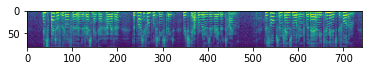

In [5]:
plt.imshow(clean_mel.T)

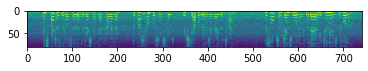

In [6]:
plt.imshow(noisy_mel.T)

# Чтение данных 

In [2]:
data_dir = '/home/warden/voice_data/'
train_numbers = np.array(os.listdir(data_dir + 'train/clean')).astype(int)
val_numbers = np.array(os.listdir(data_dir + 'val/clean')).astype(int)


def read_dir(dir_):
    ret = []
    for elem in sorted(os.listdir(dir_)):
        elem = os.path.join(dir_, elem)
        ret.append(np.load(elem))
    return ret

train_clean = {number: read_dir(os.path.join(data_dir + 'train/clean', str(number))) for number in train_numbers}
train_noisy = {number: read_dir(os.path.join(data_dir + 'train/noisy', str(number))) for number in train_numbers}
val_clean = {number: read_dir(os.path.join(data_dir + 'val/clean', str(number))) for number in val_numbers}
val_noisy = {number: read_dir(os.path.join(data_dir + 'val/noisy', str(number))) for number in val_numbers}

In [3]:
def random_pair(clean=train_clean, noisy=train_noisy):
    key = np.random.choice(list(clean.keys()))
    ind = np.random.choice(range(len(clean[key])))
    fig, (ax1, ax2) = plt.subplots(2, 1)
    
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='2%', pad=0.05)
    im = ax1.imshow(clean[key][ind].astype(float).T)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax1.set_title('clean', fontsize=15)
    
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='2%', pad=0.05)
    im = ax2.imshow(noisy[key][ind].astype(float).T)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax2.set_title('noisy', fontsize=15)
    plt.show()
    return clean[key][ind], noisy[key][ind]

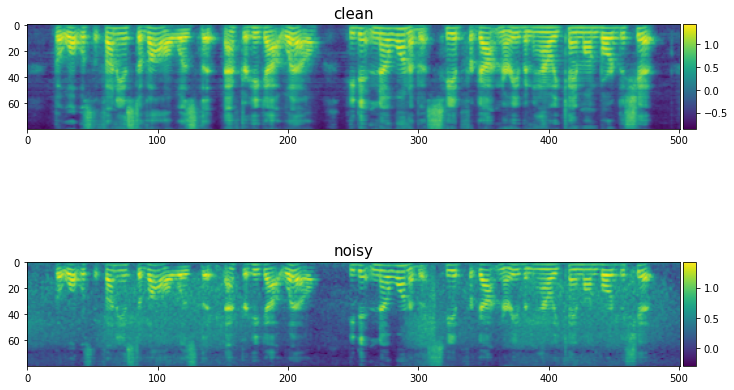

In [4]:
_ = random_pair()

In [5]:
def read_norm_dir(dir_):
    ret = []
    min_ = None
    max_ = None
    for elem in sorted(os.listdir(dir_)):
        elem = np.load(os.path.join(dir_, elem))
        el_min = np.quantile(elem, 0.01)
        el_max = np.quantile(elem, 0.99)
        
        if min_ is None or el_min < min_:
            min_ = el_min
        if max_ is None or el_max > max_:
            max_ = el_max
            
        ret.append(elem)
    for i in range(len(ret)):
        ret[i] = (ret[i] - min_)/(max_ - min_)
    return ret

norm_train_clean = {number: read_norm_dir(os.path.join(data_dir + 'train/clean', str(number))) for number in train_numbers}
norm_train_noisy = {number: read_norm_dir(os.path.join(data_dir + 'train/noisy', str(number))) for number in train_numbers}
norm_val_clean = {number: read_norm_dir(os.path.join(data_dir + 'val/clean', str(number))) for number in val_numbers}
norm_val_noisy = {number: read_norm_dir(os.path.join(data_dir + 'val/noisy', str(number))) for number in val_numbers}

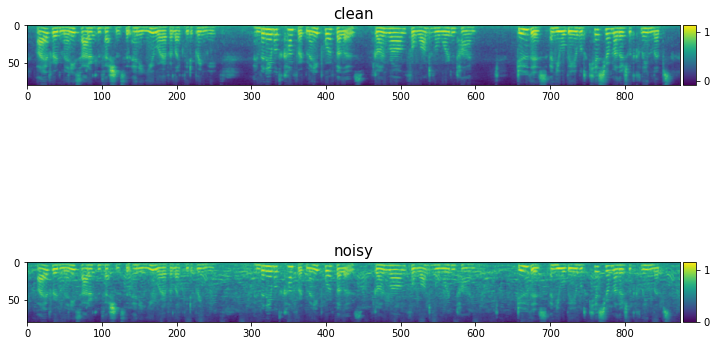

In [8]:
random_pair(norm_train_clean, norm_train_noisy)

In [9]:
print('train size: ', 2*sum([len(item) for _, item in norm_train_clean.items()]))
print('val size: ', 2*sum([len(item) for _, item in norm_val_clean.items()]))

train size:  24000
val size:  4000


In [134]:
def extract_norming_params(data):
    min_ = None
    max_ = None
    for _, val in data.items():
        for elem in val:
            el_min = np.quantile(elem, 0.01)
            el_max = np.quantile(elem, 0.99)

            if min_ is None or el_min < min_:
                min_ = el_min
            if max_ is None or el_max > max_:
                max_ = el_max
    return min_, max_ 

def get_norm_function(clean, noisy):
    min_noisy, max_noisy = extract_norming_params(noisy)
    min_clean, max_clean = extract_norming_params(clean)
    min_ = (min_noisy + min_clean)/2
    max_ = (max_noisy + max_clean)/2
    
    scale = max_ - min_
    
    def norm(img):
        return (img - min_)/scale
    
    def restore(img):
        return img*scale + min_
    
    return norm, restore, scale

Прежде всего всегда имеет смысл попробовать самые простые подходы. Они могут вообще решить все проблемы, а если нет, то станут отправной точкой для сложных.

# Классификация 

## Бэйзлайн

посмотрев на картинки, самечаем, что на чистых данных есть фон с большим количеством околонулевых значений, а на шумных - нет. попробуем отсекать по нижней квантили.

In [95]:
def img_to_quantiles(img, single=True, q=0.05):
    quantiles = np.quantile(img, q, axis=0)
    if single:
        quantiles = np.array([np.mean(quantiles)])
    return quantiles

def numbers_to_dataset(clean, noisy, numbers, img_to_features):
    X = None
    Y = None
    for num in numbers:
        samples = [img_to_features(img) for img in clean[num]] + [img_to_features(img) for img in noisy[num]]
        labels = [1]*len(clean[num]) + [0]*len(noisy[num])
        zip_ = list(zip(samples, labels)) 
        np.random.shuffle(zip_)
        samples, labels = list(zip(*zip_))
        samples = np.array(samples)
        labels = np.array(labels)
        if X is None:
            X = samples
            Y = labels
        else:
            X = np.vstack([X, samples])
            Y = np.hstack([Y, labels])
    return X, Y

In [13]:
X_val, Y_val = numbers_to_dataset(val_clean, val_noisy, val_clean.keys(), img_to_quantiles)
X_train, Y_train = numbers_to_dataset(train_clean, train_noisy, train_clean.keys(), img_to_quantiles)
len(X_val)

4000

In [14]:
def stats(row):
    print(f'mean: {np.mean(row)}\tvar: {np.var(row)},\t5%: {np.quantile(row, .05)},\t95%: {np.quantile(row, .95)}')
stats(X_train[Y_train==1].reshape(-1))
stats(X_train[Y_train==0].reshape(-1))

mean: -0.4415304573729759	var: 0.09438289393932807,	5%: -0.8939397277832031,	95%: -0.06487725614011305
mean: 0.06668516535234949	var: 0.025246861135088575,	5%: -0.23825008082389829,	95%: 0.2748931929729878


In [121]:
def stats(row):
    print(f'mean: {np.mean(row)}\tvar: {np.var(row)},\t5%: {np.quantile(row, .05)},\t95%: {np.quantile(row, .95)}')
stats(X_val[Y_val==1].reshape(-1))
stats(X_val[Y_val==0].reshape(-1))

mean: -0.36859721687767666	var: 0.09948860518995194,	5%: -0.8680200195312501,	95%: 0.09466552734375
mean: 0.11246309427034111	var: 0.08321284954401602,	5%: -0.39150390625,	95%: 0.5361328125


Даже если обрезать по среднему значению нижней квантили, уже можно получить неплохое качество

In [146]:
def train_test_split(img_to_features, n_splits=5, train_clean=train_clean, train_noisy=train_noisy):
    kf = KFold(n_splits=n_splits, shuffle=False)
    train = []
    test = []
    
    processed_X = {}
    processed_Y = {}
    
    train_numbers = np.array(list(train_clean.keys()))
    for num in train_numbers:
        X, Y = numbers_to_dataset(train_clean, train_noisy, [num], img_to_features)
        processed_X[num] = X
        processed_Y[num] = Y
    
    for i, (train_inds, test_inds) in enumerate(kf.split(train_numbers)):
        train_nums = train_numbers[train_inds]
        test_nums = train_numbers[test_inds]
        
        X = np.vstack([processed_X[num] for num in train_nums]) 
        Y = np.hstack([processed_Y[num] for num in train_nums]) 
        
        X_test = np.vstack([processed_X[num] for num in test_nums]) 
        Y_test = np.hstack([processed_Y[num] for num in test_nums]) 
        
        train.append((X, Y))
        test.append((X_test, Y_test))
    
    return train, test


def test_model(model, train_folds, test_folds):
    scores = []
    for i, ((X, Y), (X_test, Y_test)) in enumerate(zip(train_folds, test_folds)):
        model.fit(X, Y)
        scores.append(accuracy_score(model.predict(X_test), Y_test))
        print(f'fold {i}: {scores[-1]}')
    print('mean: ', np.mean(scores))

In [55]:
train_folds, test_folds = train_test_split(img_to_quantiles)
test_model(LogisticRegression(solver='lbfgs'), train_folds, test_folds)

fold 0: 0.8840311986863711
fold 1: 0.8849653379549394
fold 2: 0.8835416666666667
fold 3: 0.907000407000407
fold 4: 0.9043351396415173


In [60]:
train_folds, test_folds = train_test_split(lambda x: img_to_quantiles(x, q=0.01))
test_model(LogisticRegression(solver='lbfgs'), train_folds, test_folds)

fold 0: 0.8633004926108374
fold 1: 0.8730502599653379
fold 2: 0.8710416666666667
fold 3: 0.8931623931623932
fold 4: 0.8797415589829095


In [61]:
train_folds, test_folds = train_test_split(lambda x: img_to_quantiles(x, q=0.1))
test_model(LogisticRegression(solver='lbfgs'), train_folds, test_folds)

fold 0: 0.8944991789819376
fold 1: 0.8949306759098787
fold 2: 0.88625
fold 3: 0.9086284086284087
fold 4: 0.9099624843684869


In [63]:
train_folds, test_folds = train_test_split(lambda x: img_to_quantiles(x, single=False, q=0.1))
test_model(LogisticRegression(solver='lbfgs', max_iter=200), train_folds, test_folds)

fold 0: 0.9495073891625616
fold 1: 0.9399913344887348
fold 2: 0.9420833333333334
fold 3: 0.9552299552299552
fold 4: 0.944977073780742


In [104]:
test_model(LogisticRegression(solver='lbfgs', max_iter=800), train_folds, test_folds)

fold 0: 0.9478653530377669
fold 1: 0.9432409012131716
fold 2: 0.93125
fold 3: 0.9454619454619455
fold 4: 0.9495623176323468


Попробуем также посмотреть на отношение максимального значения амплитуды к квантили.

In [89]:
for number in train_numbers:
    minval = 0
    for img in train_clean[number]:
        newval = np.min(img)
        if newval < minval:
            minval = newval
            
    for img in train_noisy[number]:
        newval = np.min(img)
        if newval < minval:
            minval = newval
minval 

-1.148

In [93]:
def img_to_norm_quantiles(img, single=True, q=0.05):
    quantiles = np.quantile(img, q, axis=0)
    maxvals = np.max(img, axis=0)
    img += 1.2 
    quantiles = np.clip(quantiles, 1e-3, None) # if in val will be values lower than 1.2 
    ret = maxvals/quantiles
    if single:
        ret = np.array([np.mean(ret)])
    return ret 

In [99]:
train_folds, test_folds = train_test_split(lambda x: img_to_norm_quantiles(x, single=False, q=0.01))

In [100]:
test_model(LogisticRegression(solver='lbfgs', max_iter=500), train_folds, test_folds)

fold 0: 0.9142036124794746
fold 1: 0.915944540727903
fold 2: 0.9185416666666667
fold 3: 0.9214489214489214
fold 4: 0.9197582325969154


In [126]:
ffun = lambda x: img_to_quantiles(x, single=False, q=0.1)
X_train, Y_train = numbers_to_dataset(train_clean, train_noisy, train_clean.keys(), ffun)
X_val, Y_val = numbers_to_dataset(val_clean, val_noisy, val_clean.keys(), ffun)

In [127]:
baseline_model = LogisticRegression(solver='lbfgs', max_iter=800)
baseline_model.fit(X_train, Y_train)

print(f'baseline score: {accuracy_score(baseline_model.predict(X_val), Y_val)}')

baseline score: 0.5


In [128]:
np.allclose(baseline_model.predict(X_val), np.ones(len(Y_val)))

True

In [124]:
ffun = lambda x: img_to_norm_quantiles(x, single=False, q=0.1)
X_train, Y_train = numbers_to_dataset(train_clean, train_noisy, train_clean.keys(), ffun)
X_val, Y_val = numbers_to_dataset(val_clean, val_noisy, val_clean.keys(), ffun)

In [125]:
baseline_model = LogisticRegression(solver='lbfgs', max_iter=800)
baseline_model.fit(X_train, Y_train)

print(f'baseline score: {accuracy_score(baseline_model.predict(X_val), Y_val)}')

baseline score: 0.721


На этом моменте я понимаю, что данные в train и val из разных доменов (причем понять это из трейна нельзя - я обучался и тестировался на разных спикерах).
По идее мы не должны использовать val при подборе параметров, поэтому формально это просто не вполне корректно поставленная задача. Но можно еще нормировать данные. 

In [154]:
train_folds, test_folds = train_test_split(lambda x: img_to_quantiles(x, single=False, q=0.1), train_clean=norm_train_clean, train_noisy=norm_train_noisy)
test_model(LogisticRegression(solver='lbfgs', max_iter=200), train_folds, test_folds)

fold 0: 0.9123563218390804
fold 1: 0.9217937608318891
fold 2: 0.9091666666666667
fold 3: 0.9251119251119251
fold 4: 0.8999583159649854
mean:  0.9136773980829094


In [155]:
train_folds, test_folds = train_test_split(lambda x: img_to_quantiles(x, single=False, q=0.01), train_clean=norm_train_clean, train_noisy=norm_train_noisy)
test_model(LogisticRegression(solver='lbfgs', max_iter=200), train_folds, test_folds)

fold 0: 0.9035303776683087
fold 1: 0.9146447140381283
fold 2: 0.901875
fold 3: 0.9171754171754172
fold 4: 0.8874531054606086
mean:  0.9049357228684926


In [156]:
train_folds, test_folds = train_test_split(lambda x: img_to_quantiles(x, single=False, q=0.05), train_clean=norm_train_clean, train_noisy=norm_train_noisy)
test_model(LogisticRegression(solver='lbfgs', max_iter=200), train_folds, test_folds)

fold 0: 0.9166666666666666
fold 1: 0.9228769497400346
fold 2: 0.910625
fold 3: 0.9253154253154253
fold 4: 0.8993330554397666
mean:  0.9149634194323786


In [157]:
train_folds, test_folds = train_test_split(lambda x: img_to_quantiles(x, single=True, q=0.05), train_clean=norm_train_clean, train_noisy=norm_train_noisy)
test_model(LogisticRegression(solver='lbfgs', max_iter=200), train_folds, test_folds)

fold 0: 0.8230706075533661
fold 1: 0.8429376083188909
fold 2: 0.826875
fold 3: 0.8654863654863655
fold 4: 0.8207586494372655
mean:  0.8358256461591775


In [158]:
ffun = lambda x: img_to_quantiles(x, single=False, q=0.05)
X_train, Y_train = numbers_to_dataset(norm_train_clean, norm_train_noisy, train_clean.keys(), ffun)
X_val, Y_val = numbers_to_dataset(norm_val_clean, norm_val_noisy, norm_val_clean.keys(), ffun)

In [159]:
baseline_model = LogisticRegression(solver='lbfgs', max_iter=800)
baseline_model.fit(X_train, Y_train)

print(f'baseline score: {accuracy_score(baseline_model.predict(X_val), Y_val)}')

baseline score: 0.914


В итоге бэйзлайн классификации - это логрегрессия на квантилях по каждой частоте. Линейная модель - потому что интуитивно при малых значениях квантили сигнал чистый, при больших - шумный, более сложные модели не имеют особого смысла. Дальнейшее улучшение должно быть связано с обогащением признаков.

## Улучшение

In [98]:
from models import Classifier
from training import validate, train, SpectrogramDataset, collate_fn
from utils import load_best_model, train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### сырые данные

In [99]:
train_part_clean, train_part_noisy, test_part_clean, test_part_noisy = train_test_split(train_clean, train_noisy)

In [100]:
model = Classifier(gradient_clip=50, blocks=(24, 24, 48, 48)) # 96.40 
cp_folder = 'checkpoints/classification_checkpoints4'

train_dataset = SpectrogramDataset(train_part_clean, train_part_noisy)
test_dataset = SpectrogramDataset(test_part_clean, test_part_noisy)
print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1, collate_fn=collate_fn) 
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=collate_fn) 

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

train: 9607, test: 2393


In [101]:
train(model, optimizer, criterion, train_loader, test_loader, n_epochs=30, n_verbose=30, jupyter=True, checkpoints=cp_folder)

[0, 30] avg_acc: 76.04 avg_loss: 0.485
[0, 60] avg_acc: 88.28 avg_loss: 0.287
[0, 90] avg_acc: 90.16 avg_loss: 0.278
[0, 120] avg_acc: 89.32 avg_loss: 0.250
[0, 150] avg_acc: 88.54 avg_loss: 0.278
[0, 180] avg_acc: 91.41 avg_loss: 0.252
[0, 210] avg_acc: 90.10 avg_loss: 0.243
[0, 240] avg_acc: 90.42 avg_loss: 0.237
[0, 270] avg_acc: 91.41 avg_loss: 0.224
[0, 300] avg_acc: 91.04 avg_loss: 0.244

validating



epoch 0 train | acc: 88.71, loss: 0.27747296237470304
epoch 0 test | acc: 91.83, loss: 0.23554766178131104
saving checkpoint to checkpoints/classification_checkpoints4/epoch_0__acc_91.83.pth


[1, 30] avg_acc: 89.69 avg_loss: 0.253
[1, 60] avg_acc: 91.09 avg_loss: 0.242
[1, 90] avg_acc: 92.40 avg_loss: 0.233
[1, 120] avg_acc: 93.91 avg_loss: 0.189
[1, 150] avg_acc: 92.71 avg_loss: 0.213
[1, 180] avg_acc: 92.34 avg_loss: 0.202
[1, 210] avg_acc: 92.03 avg_loss: 0.216
[1, 240] avg_acc: 93.07 avg_loss: 0.188
[1, 270] avg_acc: 93.44 avg_loss: 0.184
[1, 300] avg_acc: 93.39 avg_loss: 0.182

validating



epoch 1 train | acc: 92.38, loss: 0.21033243302788054
epoch 1 test | acc: 92.38, loss: 0.20650379359722137
saving checkpoint to checkpoints/classification_checkpoints4/epoch_1__acc_92.38.pth


[2, 30] avg_acc: 92.55 avg_loss: 0.204
[2, 60] avg_acc: 94.17 avg_loss: 0.175
[2, 90] avg_acc: 94.01 avg_loss: 0.183
[2, 120] avg_acc: 94.74 avg_loss: 0.174
[2, 150] avg_acc: 94.11 avg_loss: 0.173
[2, 180] avg_acc: 94.27 avg_loss: 0.169
[2, 210] avg_acc: 94.06 avg_loss: 0.165
[2, 240] avg_acc: 93.54 avg_loss: 0.160
[2, 270] avg_acc: 92.19 avg_loss: 0.214
[2, 300] avg_acc: 94.11 avg_loss: 0.191

validating



epoch 2 train | acc: 93.77, loss: 0.1809891661833291
epoch 2 test | acc: 93.41, loss: 0.19198432564735413
saving checkpoint to checkpoints/classification_checkpoints4/epoch_2__acc_93.41.pth


[3, 30] avg_acc: 94.32 avg_loss: 0.173
[3, 60] avg_acc: 94.17 avg_loss: 0.170
[3, 90] avg_acc: 94.11 avg_loss: 0.162
[3, 120] avg_acc: 94.90 avg_loss: 0.149
[3, 150] avg_acc: 95.10 avg_loss: 0.147
[3, 180] avg_acc: 95.00 avg_loss: 0.145
[3, 210] avg_acc: 93.39 avg_loss: 0.183
[3, 240] avg_acc: 95.16 avg_loss: 0.161
[3, 270] avg_acc: 95.00 avg_loss: 0.137
[3, 300] avg_acc: 95.89 avg_loss: 0.139

validating



epoch 3 train | acc: 94.70, loss: 0.15632669708112942
epoch 3 test | acc: 92.99, loss: 0.19673685729503632
saving checkpoint to checkpoints/classification_checkpoints4/epoch_3__acc_92.99.pth


[4, 30] avg_acc: 94.17 avg_loss: 0.167
[4, 60] avg_acc: 95.16 avg_loss: 0.161
[4, 90] avg_acc: 95.31 avg_loss: 0.135
[4, 120] avg_acc: 94.95 avg_loss: 0.150
[4, 150] avg_acc: 94.79 avg_loss: 0.154
[4, 180] avg_acc: 95.21 avg_loss: 0.144
[4, 210] avg_acc: 95.68 avg_loss: 0.128
[4, 240] avg_acc: 95.26 avg_loss: 0.149
[4, 270] avg_acc: 95.05 avg_loss: 0.155
[4, 300] avg_acc: 94.90 avg_loss: 0.165

validating



epoch 4 train | acc: 95.04, loss: 0.15063263484558395
epoch 4 test | acc: 93.64, loss: 0.1780211478471756
saving checkpoint to checkpoints/classification_checkpoints4/epoch_4__acc_93.64.pth


[5, 30] avg_acc: 95.83 avg_loss: 0.144
[5, 60] avg_acc: 95.42 avg_loss: 0.140
[5, 90] avg_acc: 95.05 avg_loss: 0.156
[5, 120] avg_acc: 95.21 avg_loss: 0.134
[5, 150] avg_acc: 95.42 avg_loss: 0.137
[5, 180] avg_acc: 95.68 avg_loss: 0.151
[5, 210] avg_acc: 94.58 avg_loss: 0.138
[5, 240] avg_acc: 94.95 avg_loss: 0.139
[5, 270] avg_acc: 95.36 avg_loss: 0.152
[5, 300] avg_acc: 94.84 avg_loss: 0.139

validating



epoch 5 train | acc: 95.25, loss: 0.14296974621069589
epoch 5 test | acc: 93.64, loss: 0.17533038556575775
saving checkpoint to checkpoints/classification_checkpoints4/epoch_5__acc_93.64.pth


[6, 30] avg_acc: 95.78 avg_loss: 0.134
[6, 60] avg_acc: 95.57 avg_loss: 0.131
[6, 90] avg_acc: 95.78 avg_loss: 0.139
[6, 120] avg_acc: 93.75 avg_loss: 0.169
[6, 150] avg_acc: 95.83 avg_loss: 0.126
[6, 180] avg_acc: 95.83 avg_loss: 0.131
[6, 210] avg_acc: 95.99 avg_loss: 0.133
[6, 240] avg_acc: 94.84 avg_loss: 0.139
[6, 270] avg_acc: 96.20 avg_loss: 0.131
[6, 300] avg_acc: 95.78 avg_loss: 0.146

validating



epoch 6 train | acc: 95.55, loss: 0.13779160404497404
epoch 6 test | acc: 93.93, loss: 0.17106710374355316
saving checkpoint to checkpoints/classification_checkpoints4/epoch_6__acc_93.93.pth


[7, 30] avg_acc: 96.51 avg_loss: 0.124
[7, 60] avg_acc: 96.51 avg_loss: 0.117
[7, 90] avg_acc: 96.25 avg_loss: 0.112
[7, 120] avg_acc: 95.26 avg_loss: 0.148
[7, 150] avg_acc: 95.83 avg_loss: 0.125
[7, 180] avg_acc: 95.10 avg_loss: 0.151
[7, 210] avg_acc: 95.62 avg_loss: 0.132
[7, 240] avg_acc: 95.62 avg_loss: 0.142
[7, 270] avg_acc: 95.47 avg_loss: 0.140
[7, 300] avg_acc: 95.99 avg_loss: 0.130

validating



epoch 7 train | acc: 95.76, loss: 0.13346692544726835
epoch 7 test | acc: 93.99, loss: 0.1717251092195511
saving checkpoint to checkpoints/classification_checkpoints4/epoch_7__acc_93.99.pth


[8, 30] avg_acc: 95.16 avg_loss: 0.153
[8, 60] avg_acc: 95.42 avg_loss: 0.146
[8, 90] avg_acc: 96.20 avg_loss: 0.124
[8, 120] avg_acc: 95.73 avg_loss: 0.125
[8, 150] avg_acc: 96.46 avg_loss: 0.111
[8, 180] avg_acc: 96.98 avg_loss: 0.097
[8, 210] avg_acc: 96.25 avg_loss: 0.131
[8, 240] avg_acc: 95.47 avg_loss: 0.131
[8, 270] avg_acc: 96.15 avg_loss: 0.129
[8, 300] avg_acc: 96.30 avg_loss: 0.119

validating



epoch 8 train | acc: 95.98, loss: 0.12722380216112764
epoch 8 test | acc: 93.63, loss: 0.17799748480319977
saving checkpoint to checkpoints/classification_checkpoints4/epoch_8__acc_93.63.pth


[9, 30] avg_acc: 94.79 avg_loss: 0.141
[9, 60] avg_acc: 96.51 avg_loss: 0.108
[9, 90] avg_acc: 96.25 avg_loss: 0.115
[9, 120] avg_acc: 96.46 avg_loss: 0.134
[9, 150] avg_acc: 95.42 avg_loss: 0.135
[9, 180] avg_acc: 96.04 avg_loss: 0.144
[9, 210] avg_acc: 95.89 avg_loss: 0.136
[9, 240] avg_acc: 95.99 avg_loss: 0.112
[9, 270] avg_acc: 96.46 avg_loss: 0.102
[9, 300] avg_acc: 95.57 avg_loss: 0.130

validating



epoch 9 train | acc: 95.95, loss: 0.12544905584911967
epoch 9 test | acc: 93.99, loss: 0.16289398074150085
saving checkpoint to checkpoints/classification_checkpoints4/epoch_9__acc_93.99.pth


[10, 30] avg_acc: 95.68 avg_loss: 0.136
[10, 60] avg_acc: 95.99 avg_loss: 0.130
[10, 90] avg_acc: 95.83 avg_loss: 0.125
[10, 120] avg_acc: 96.25 avg_loss: 0.107
[10, 150] avg_acc: 95.83 avg_loss: 0.126
[10, 180] avg_acc: 96.30 avg_loss: 0.126
[10, 210] avg_acc: 96.41 avg_loss: 0.109
[10, 240] avg_acc: 95.99 avg_loss: 0.116
[10, 270] avg_acc: 96.09 avg_loss: 0.127
[10, 300] avg_acc: 96.09 avg_loss: 0.111

validating



epoch 10 train | acc: 96.04, loss: 0.12105707718412148
epoch 10 test | acc: 93.78, loss: 0.18655380606651306
saving checkpoint to checkpoints/classification_checkpoints4/epoch_10__acc_93.78.pth


[11, 30] avg_acc: 96.41 avg_loss: 0.105
[11, 60] avg_acc: 97.08 avg_loss: 0.098
[11, 90] avg_acc: 95.47 avg_loss: 0.141
[11, 120] avg_acc: 95.05 avg_loss: 0.130
[11, 150] avg_acc: 96.15 avg_loss: 0.116
[11, 180] avg_acc: 96.56 avg_loss: 0.110
[11, 210] avg_acc: 96.61 avg_loss: 0.106
[11, 240] avg_acc: 95.83 avg_loss: 0.120
[11, 270] avg_acc: 95.62 avg_loss: 0.133
[11, 300] avg_acc: 96.56 avg_loss: 0.118

validating



epoch 11 train | acc: 96.12, loss: 0.11771415744558521
epoch 11 test | acc: 94.36, loss: 0.16656476259231567
saving checkpoint to checkpoints/classification_checkpoints4/epoch_11__acc_94.36.pth


[12, 30] avg_acc: 96.56 avg_loss: 0.112
[12, 60] avg_acc: 96.46 avg_loss: 0.106
[12, 90] avg_acc: 96.35 avg_loss: 0.108
[12, 120] avg_acc: 95.73 avg_loss: 0.138
[12, 150] avg_acc: 95.83 avg_loss: 0.109
[12, 180] avg_acc: 96.25 avg_loss: 0.112
[12, 210] avg_acc: 96.09 avg_loss: 0.124
[12, 240] avg_acc: 96.15 avg_loss: 0.119
[12, 270] avg_acc: 96.25 avg_loss: 0.119
[12, 300] avg_acc: 96.56 avg_loss: 0.118

validating



epoch 12 train | acc: 96.24, loss: 0.11598828594599452
epoch 12 test | acc: 94.18, loss: 0.1726471185684204
saving checkpoint to checkpoints/classification_checkpoints4/epoch_12__acc_94.18.pth


[13, 30] avg_acc: 96.15 avg_loss: 0.101
[13, 60] avg_acc: 96.46 avg_loss: 0.104
[13, 90] avg_acc: 96.67 avg_loss: 0.110
[13, 120] avg_acc: 97.03 avg_loss: 0.105
[13, 150] avg_acc: 95.73 avg_loss: 0.123
[13, 180] avg_acc: 96.82 avg_loss: 0.108
[13, 210] avg_acc: 96.72 avg_loss: 0.114
[13, 240] avg_acc: 96.88 avg_loss: 0.106
[13, 270] avg_acc: 96.51 avg_loss: 0.111
[13, 300] avg_acc: 96.56 avg_loss: 0.109

validating



epoch 13 train | acc: 96.56, loss: 0.10887319609473314
epoch 13 test | acc: 94.81, loss: 0.15018704533576965
saving checkpoint to checkpoints/classification_checkpoints4/epoch_13__acc_94.81.pth


[14, 30] avg_acc: 96.41 avg_loss: 0.108
[14, 60] avg_acc: 96.67 avg_loss: 0.112
[14, 90] avg_acc: 97.24 avg_loss: 0.110
[14, 120] avg_acc: 96.82 avg_loss: 0.111
[14, 150] avg_acc: 96.35 avg_loss: 0.116
[14, 180] avg_acc: 96.09 avg_loss: 0.112
[14, 210] avg_acc: 96.93 avg_loss: 0.101
[14, 240] avg_acc: 96.04 avg_loss: 0.115
[14, 270] avg_acc: 96.72 avg_loss: 0.116
[14, 300] avg_acc: 96.56 avg_loss: 0.096

validating



epoch 14 train | acc: 96.59, loss: 0.10921318354889552
epoch 14 test | acc: 94.34, loss: 0.1702023148536682
saving checkpoint to checkpoints/classification_checkpoints4/epoch_14__acc_94.34.pth


[15, 30] avg_acc: 96.25 avg_loss: 0.126
[15, 60] avg_acc: 96.35 avg_loss: 0.113
[15, 90] avg_acc: 96.25 avg_loss: 0.120
[15, 120] avg_acc: 97.34 avg_loss: 0.096
[15, 150] avg_acc: 97.19 avg_loss: 0.087
[15, 180] avg_acc: 96.93 avg_loss: 0.096
[15, 210] avg_acc: 96.15 avg_loss: 0.126
[15, 240] avg_acc: 96.09 avg_loss: 0.120
[15, 270] avg_acc: 96.72 avg_loss: 0.096
[15, 300] avg_acc: 96.25 avg_loss: 0.103

validating



epoch 15 train | acc: 96.54, loss: 0.10824988325717441
epoch 15 test | acc: 94.27, loss: 0.14894473552703857
saving checkpoint to checkpoints/classification_checkpoints4/epoch_15__acc_94.27.pth


[16, 30] avg_acc: 95.94 avg_loss: 0.108
[16, 60] avg_acc: 97.03 avg_loss: 0.093
[16, 90] avg_acc: 96.82 avg_loss: 0.112
[16, 120] avg_acc: 96.77 avg_loss: 0.102
[16, 150] avg_acc: 97.45 avg_loss: 0.099
[16, 180] avg_acc: 97.03 avg_loss: 0.102
[16, 210] avg_acc: 95.83 avg_loss: 0.123
[16, 240] avg_acc: 96.46 avg_loss: 0.110
[16, 270] avg_acc: 96.20 avg_loss: 0.109
[16, 300] avg_acc: 96.46 avg_loss: 0.120

validating



epoch 16 train | acc: 96.56, loss: 0.10819954149722062
epoch 16 test | acc: 94.86, loss: 0.1398565173149109
saving checkpoint to checkpoints/classification_checkpoints4/epoch_16__acc_94.86.pth


[17, 30] avg_acc: 97.34 avg_loss: 0.091
[17, 60] avg_acc: 96.72 avg_loss: 0.111
[17, 90] avg_acc: 96.46 avg_loss: 0.102
[17, 120] avg_acc: 96.51 avg_loss: 0.110
[17, 150] avg_acc: 95.83 avg_loss: 0.128
[17, 180] avg_acc: 96.98 avg_loss: 0.100
[17, 210] avg_acc: 96.88 avg_loss: 0.097
[17, 240] avg_acc: 96.72 avg_loss: 0.103
[17, 270] avg_acc: 96.15 avg_loss: 0.117
[17, 300] avg_acc: 96.93 avg_loss: 0.093

validating



epoch 17 train | acc: 96.66, loss: 0.10482049839837211
epoch 17 test | acc: 94.89, loss: 0.1493789255619049
saving checkpoint to checkpoints/classification_checkpoints4/epoch_17__acc_94.89.pth


[18, 30] avg_acc: 96.77 avg_loss: 0.107
[18, 60] avg_acc: 97.08 avg_loss: 0.099
[18, 90] avg_acc: 96.93 avg_loss: 0.111
[18, 120] avg_acc: 96.56 avg_loss: 0.102
[18, 150] avg_acc: 96.93 avg_loss: 0.092
[18, 180] avg_acc: 96.67 avg_loss: 0.109
[18, 210] avg_acc: 97.03 avg_loss: 0.094
[18, 240] avg_acc: 96.77 avg_loss: 0.091
[18, 270] avg_acc: 96.77 avg_loss: 0.105
[18, 300] avg_acc: 96.56 avg_loss: 0.120

validating



epoch 18 train | acc: 96.79, loss: 0.10308937936637588
epoch 18 test | acc: 94.95, loss: 0.13348756730556488
saving checkpoint to checkpoints/classification_checkpoints4/epoch_18__acc_94.95.pth


[19, 30] avg_acc: 96.46 avg_loss: 0.116
[19, 60] avg_acc: 96.88 avg_loss: 0.098
[19, 90] avg_acc: 97.40 avg_loss: 0.095
[19, 120] avg_acc: 96.51 avg_loss: 0.116
[19, 150] avg_acc: 96.82 avg_loss: 0.101
[19, 180] avg_acc: 96.61 avg_loss: 0.097
[19, 210] avg_acc: 96.51 avg_loss: 0.102
[19, 240] avg_acc: 97.19 avg_loss: 0.094
[19, 270] avg_acc: 97.29 avg_loss: 0.083
[19, 300] avg_acc: 96.46 avg_loss: 0.116

validating



epoch 19 train | acc: 96.80, loss: 0.10180344771705196
epoch 19 test | acc: 95.11, loss: 0.13714627921581268
saving checkpoint to checkpoints/classification_checkpoints4/epoch_19__acc_95.11.pth


[20, 30] avg_acc: 96.93 avg_loss: 0.104
[20, 60] avg_acc: 96.93 avg_loss: 0.100
[20, 90] avg_acc: 96.61 avg_loss: 0.107
[20, 120] avg_acc: 96.15 avg_loss: 0.115
[20, 150] avg_acc: 96.04 avg_loss: 0.112
[20, 180] avg_acc: 97.14 avg_loss: 0.096
[20, 210] avg_acc: 97.14 avg_loss: 0.102
[20, 240] avg_acc: 96.67 avg_loss: 0.101
[20, 270] avg_acc: 97.08 avg_loss: 0.097
[20, 300] avg_acc: 96.41 avg_loss: 0.101

validating



epoch 20 train | acc: 96.70, loss: 0.10352652155456947
epoch 20 test | acc: 95.34, loss: 0.14259594678878784
saving checkpoint to checkpoints/classification_checkpoints4/epoch_20__acc_95.34.pth


[21, 30] avg_acc: 96.25 avg_loss: 0.104
[21, 60] avg_acc: 97.40 avg_loss: 0.085
[21, 90] avg_acc: 95.99 avg_loss: 0.115
[21, 120] avg_acc: 96.82 avg_loss: 0.089
[21, 150] avg_acc: 96.72 avg_loss: 0.110
[21, 180] avg_acc: 96.82 avg_loss: 0.101
[21, 210] avg_acc: 96.93 avg_loss: 0.099
[21, 240] avg_acc: 96.56 avg_loss: 0.109
[21, 270] avg_acc: 96.88 avg_loss: 0.101
[21, 300] avg_acc: 97.19 avg_loss: 0.092

validating



epoch 21 train | acc: 96.74, loss: 0.10145327599217924
epoch 21 test | acc: 94.53, loss: 0.16460464894771576
saving checkpoint to checkpoints/classification_checkpoints4/epoch_21__acc_94.53.pth


[22, 30] avg_acc: 96.93 avg_loss: 0.104
[22, 60] avg_acc: 96.30 avg_loss: 0.119
[22, 90] avg_acc: 96.88 avg_loss: 0.109
[22, 120] avg_acc: 97.24 avg_loss: 0.086
[22, 150] avg_acc: 96.56 avg_loss: 0.107
[22, 180] avg_acc: 97.14 avg_loss: 0.096
[22, 210] avg_acc: 96.82 avg_loss: 0.092
[22, 240] avg_acc: 96.98 avg_loss: 0.089
[22, 270] avg_acc: 96.77 avg_loss: 0.092
[22, 300] avg_acc: 97.24 avg_loss: 0.094

validating



epoch 22 train | acc: 96.87, loss: 0.09886915247850243
epoch 22 test | acc: 94.08, loss: 0.18887850642204285
saving checkpoint to checkpoints/classification_checkpoints4/epoch_22__acc_94.08.pth


[23, 30] avg_acc: 95.26 avg_loss: 0.127
[23, 60] avg_acc: 96.67 avg_loss: 0.096
[23, 90] avg_acc: 96.35 avg_loss: 0.119
[23, 120] avg_acc: 96.98 avg_loss: 0.099
[23, 150] avg_acc: 97.24 avg_loss: 0.094
[23, 180] avg_acc: 97.55 avg_loss: 0.085
[23, 210] avg_acc: 97.24 avg_loss: 0.095
[23, 240] avg_acc: 96.98 avg_loss: 0.100
[23, 270] avg_acc: 96.35 avg_loss: 0.099
[23, 300] avg_acc: 96.82 avg_loss: 0.098

validating



epoch 23 train | acc: 96.76, loss: 0.1009262444210112
epoch 23 test | acc: 95.44, loss: 0.1363614797592163
saving checkpoint to checkpoints/classification_checkpoints4/epoch_23__acc_95.44.pth


[24, 30] avg_acc: 96.41 avg_loss: 0.106
[24, 60] avg_acc: 96.51 avg_loss: 0.103
[24, 90] avg_acc: 96.67 avg_loss: 0.101
[24, 120] avg_acc: 97.14 avg_loss: 0.085
[24, 150] avg_acc: 96.98 avg_loss: 0.087
[24, 180] avg_acc: 97.14 avg_loss: 0.101
[24, 210] avg_acc: 97.19 avg_loss: 0.095
[24, 240] avg_acc: 96.41 avg_loss: 0.109
[24, 270] avg_acc: 97.29 avg_loss: 0.088
[24, 300] avg_acc: 97.24 avg_loss: 0.091

validating



epoch 24 train | acc: 96.88, loss: 0.09643810288207079
epoch 24 test | acc: 95.27, loss: 0.1428200751543045
saving checkpoint to checkpoints/classification_checkpoints4/epoch_24__acc_95.27.pth


[25, 30] avg_acc: 96.46 avg_loss: 0.098
[25, 60] avg_acc: 96.72 avg_loss: 0.105
[25, 90] avg_acc: 97.29 avg_loss: 0.077
[25, 120] avg_acc: 97.50 avg_loss: 0.091
[25, 150] avg_acc: 96.56 avg_loss: 0.107
[25, 180] avg_acc: 97.08 avg_loss: 0.100
[25, 210] avg_acc: 96.77 avg_loss: 0.106
[25, 240] avg_acc: 96.72 avg_loss: 0.096
[25, 270] avg_acc: 97.24 avg_loss: 0.093
[25, 300] avg_acc: 97.14 avg_loss: 0.105

validating



epoch 25 train | acc: 96.96, loss: 0.09732369491613882
epoch 25 test | acc: 95.68, loss: 0.1277647465467453
saving checkpoint to checkpoints/classification_checkpoints4/epoch_25__acc_95.68.pth


[26, 30] avg_acc: 97.29 avg_loss: 0.081
[26, 60] avg_acc: 97.24 avg_loss: 0.096
[26, 90] avg_acc: 96.04 avg_loss: 0.113
[26, 120] avg_acc: 95.78 avg_loss: 0.113
[26, 150] avg_acc: 96.93 avg_loss: 0.099
[26, 180] avg_acc: 96.77 avg_loss: 0.102
[26, 210] avg_acc: 97.24 avg_loss: 0.091
[26, 240] avg_acc: 97.55 avg_loss: 0.076
[26, 270] avg_acc: 97.19 avg_loss: 0.101
[26, 300] avg_acc: 96.72 avg_loss: 0.097

validating



epoch 26 train | acc: 96.89, loss: 0.09690704926897917
epoch 26 test | acc: 95.77, loss: 0.1285947859287262
saving checkpoint to checkpoints/classification_checkpoints4/epoch_26__acc_95.77.pth


[27, 30] avg_acc: 97.14 avg_loss: 0.077
[27, 60] avg_acc: 97.24 avg_loss: 0.093
[27, 90] avg_acc: 96.72 avg_loss: 0.110
[27, 120] avg_acc: 97.19 avg_loss: 0.094
[27, 150] avg_acc: 96.51 avg_loss: 0.096
[27, 180] avg_acc: 97.03 avg_loss: 0.076
[27, 210] avg_acc: 96.15 avg_loss: 0.108
[27, 240] avg_acc: 96.88 avg_loss: 0.099
[27, 270] avg_acc: 96.72 avg_loss: 0.105
[27, 300] avg_acc: 97.29 avg_loss: 0.090

validating



epoch 27 train | acc: 96.90, loss: 0.09465499678657598
epoch 27 test | acc: 94.83, loss: 0.13988786935806274
saving checkpoint to checkpoints/classification_checkpoints4/epoch_27__acc_94.83.pth


[28, 30] avg_acc: 96.88 avg_loss: 0.091
[28, 60] avg_acc: 96.56 avg_loss: 0.099
[28, 90] avg_acc: 97.14 avg_loss: 0.088
[28, 120] avg_acc: 96.82 avg_loss: 0.097
[28, 150] avg_acc: 97.45 avg_loss: 0.091
[28, 180] avg_acc: 97.81 avg_loss: 0.073
[28, 210] avg_acc: 97.19 avg_loss: 0.089
[28, 240] avg_acc: 97.03 avg_loss: 0.097
[28, 270] avg_acc: 96.56 avg_loss: 0.113
[28, 300] avg_acc: 97.45 avg_loss: 0.089

validating



epoch 28 train | acc: 97.10, loss: 0.09232061490899206
epoch 28 test | acc: 95.05, loss: 0.13745780289173126
saving checkpoint to checkpoints/classification_checkpoints4/epoch_28__acc_95.05.pth


[29, 30] avg_acc: 97.45 avg_loss: 0.092
[29, 60] avg_acc: 96.98 avg_loss: 0.097
[29, 90] avg_acc: 97.08 avg_loss: 0.089
[29, 120] avg_acc: 97.50 avg_loss: 0.084
[29, 150] avg_acc: 96.77 avg_loss: 0.100
[29, 180] avg_acc: 97.81 avg_loss: 0.081
[29, 210] avg_acc: 96.82 avg_loss: 0.098
[29, 240] avg_acc: 96.56 avg_loss: 0.105
[29, 270] avg_acc: 97.81 avg_loss: 0.074
[29, 300] avg_acc: 96.51 avg_loss: 0.099

validating



epoch 29 train | acc: 97.14, loss: 0.09181427735018473
epoch 29 test | acc: 95.57, loss: 0.12698592245578766
saving checkpoint to checkpoints/classification_checkpoints4/epoch_29__acc_95.57.pth


In [104]:
val_dataset = SpectrogramDataset(val_clean, val_noisy)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=collate_fn) 
print(f'val: {len(val_dataset)}')

best_model = load_best_model(model, cp_folder)
acc, loss, false_clean, false_noisy = validate(best_model, val_loader, criterion, jupyter=True, mode='classification')
print(f'val acc: {acc*100:.2f}, loss: {loss}')

val: 2000
loading epoch_27__acc_96.07.pth



val acc: 96.40, loss: 0.12377756088972092


### нормированные данные

In [133]:
model = Classifier(gradient_clip=50)
cp_folder = 'checkpoints/norm_classification_checkpoints'
norm_fun, restore_fun, scale = get_norm_function(train_part_clean, train_part_noisy)

train_dataset = SpectrogramDataset(train_part_clean, train_part_noisy, norm_fun)
test_dataset = SpectrogramDataset(test_part_clean, test_part_noisy, norm_fun)
print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1, collate_fn=collate_fn) 
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=collate_fn) 

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-3)

NameError: name 'get_norm_function' is not defined

In [9]:
train(model, optimizer, criterion, train_loader, test_loader, n_epochs=30, n_verbose=30, jupyter=True, checkpoints=cp_folder)

[0, 30] avg_acc: 50.05 avg_loss: 1.530
[0, 60] avg_acc: 53.18 avg_loss: 0.691
[0, 90] avg_acc: 57.55 avg_loss: 0.655
[0, 120] avg_acc: 70.26 avg_loss: 0.658
[0, 150] avg_acc: 70.99 avg_loss: 0.594
[0, 180] avg_acc: 67.14 avg_loss: 0.659
[0, 210] avg_acc: 79.69 avg_loss: 0.504
[0, 240] avg_acc: 79.90 avg_loss: 0.451
[0, 270] avg_acc: 85.26 avg_loss: 0.359
[0, 300] avg_acc: 84.43 avg_loss: 0.353

validating



epoch 0 train | acc: 69.92, loss: 0.6442113630597378
epoch 0 test | acc: 76.80, loss: 0.5152638554573059
saving checkpoint to checkpoints/norm_classification_checkpoints/epoch_0__acc_76.80.pth


[1, 30] avg_acc: 75.62 avg_loss: 0.561
[1, 60] avg_acc: 86.41 avg_loss: 0.343
[1, 90] avg_acc: 87.19 avg_loss: 0.336
[1, 120] avg_acc: 89.43 avg_loss: 0.280
[1, 150] avg_acc: 86.77 avg_loss: 0.332
[1, 180] avg_acc: 85.99 avg_loss: 0.343
[1, 210] avg_acc: 87.71 avg_loss: 0.304
[1, 240] avg_acc: 87.71 avg_loss: 0.298
[1, 270] avg_acc: 89.27 avg_loss: 0.263
[1, 300] avg_acc: 91.56 avg_loss: 0.226

validating



epoch 1 train | acc: 86.74, loss: 0.3303294043455805
epoch 1 test | acc: 74.82, loss: 0.6872733235359192
saving checkpoint to checkpoints/norm_classification_checkpoints/epoch_1__acc_74.82.pth


[2, 30] avg_acc: 85.83 avg_loss: 0.353
[2, 60] avg_acc: 88.91 avg_loss: 0.302
[2, 90] avg_acc: 91.46 avg_loss: 0.227
[2, 120] avg_acc: 91.20 avg_loss: 0.234
[2, 150] avg_acc: 91.67 avg_loss: 0.214
[2, 180] avg_acc: 90.26 avg_loss: 0.253
[2, 210] avg_acc: 87.76 avg_loss: 0.334
[2, 240] avg_acc: 91.88 avg_loss: 0.222
[2, 270] avg_acc: 92.60 avg_loss: 0.209
[2, 300] avg_acc: 92.08 avg_loss: 0.223

validating



epoch 2 train | acc: 90.37, loss: 0.2569423510733237
epoch 2 test | acc: 89.71, loss: 0.2455875128507614
saving checkpoint to checkpoints/norm_classification_checkpoints/epoch_2__acc_89.71.pth


[3, 30] avg_acc: 93.12 avg_loss: 0.195
[3, 60] avg_acc: 92.50 avg_loss: 0.209
[3, 90] avg_acc: 92.29 avg_loss: 0.185
[3, 120] avg_acc: 91.98 avg_loss: 0.206
[3, 150] avg_acc: 92.71 avg_loss: 0.206
[3, 180] avg_acc: 94.01 avg_loss: 0.180
[3, 210] avg_acc: 94.06 avg_loss: 0.177
[3, 240] avg_acc: 94.48 avg_loss: 0.179
[3, 270] avg_acc: 91.93 avg_loss: 0.213
[3, 300] avg_acc: 92.29 avg_loss: 0.198

validating



epoch 3 train | acc: 92.96, loss: 0.1942620691394687
epoch 3 test | acc: 89.41, loss: 0.29014480113983154
saving checkpoint to checkpoints/norm_classification_checkpoints/epoch_3__acc_89.41.pth


[4, 30] avg_acc: 92.97 avg_loss: 0.176
[4, 60] avg_acc: 94.17 avg_loss: 0.170
[4, 90] avg_acc: 93.07 avg_loss: 0.196
[4, 120] avg_acc: 92.55 avg_loss: 0.198
[4, 150] avg_acc: 94.58 avg_loss: 0.157
[4, 180] avg_acc: 91.56 avg_loss: 0.214
[4, 210] avg_acc: 93.02 avg_loss: 0.183
[4, 240] avg_acc: 92.81 avg_loss: 0.211
[4, 270] avg_acc: 93.33 avg_loss: 0.191
[4, 300] avg_acc: 92.86 avg_loss: 0.187

validating



epoch 4 train | acc: 93.07, loss: 0.1888771112822615
epoch 4 test | acc: 93.09, loss: 0.18894062936306
saving checkpoint to checkpoints/norm_classification_checkpoints/epoch_4__acc_93.09.pth


[5, 30] avg_acc: 94.27 avg_loss: 0.169
[5, 60] avg_acc: 93.85 avg_loss: 0.168
[5, 90] avg_acc: 94.69 avg_loss: 0.151
[5, 120] avg_acc: 93.49 avg_loss: 0.175
[5, 150] avg_acc: 93.75 avg_loss: 0.167
[5, 180] avg_acc: 93.65 avg_loss: 0.172
[5, 210] avg_acc: 92.50 avg_loss: 0.203
[5, 240] avg_acc: 93.02 avg_loss: 0.207
[5, 270] avg_acc: 92.40 avg_loss: 0.201
[5, 300] avg_acc: 94.01 avg_loss: 0.168

validating



epoch 5 train | acc: 93.58, loss: 0.1778259671036389
epoch 5 test | acc: 93.05, loss: 0.20990082621574402
saving checkpoint to checkpoints/norm_classification_checkpoints/epoch_5__acc_93.05.pth


[6, 30] avg_acc: 92.66 avg_loss: 0.196
[6, 60] avg_acc: 93.70 avg_loss: 0.175
[6, 90] avg_acc: 93.44 avg_loss: 0.190
[6, 120] avg_acc: 92.19 avg_loss: 0.186
[6, 150] avg_acc: 93.80 avg_loss: 0.168
[6, 180] avg_acc: 94.01 avg_loss: 0.174
[6, 210] avg_acc: 93.96 avg_loss: 0.167
[6, 240] avg_acc: 92.55 avg_loss: 0.211
[6, 270] avg_acc: 93.02 avg_loss: 0.195
[6, 300] avg_acc: 92.86 avg_loss: 0.198

validating



epoch 6 train | acc: 93.22, loss: 0.18601748182676558
epoch 6 test | acc: 92.69, loss: 0.21145373582839966
saving checkpoint to checkpoints/norm_classification_checkpoints/epoch_6__acc_92.69.pth


[7, 30] avg_acc: 94.48 avg_loss: 0.155
[7, 60] avg_acc: 93.59 avg_loss: 0.159
[7, 90] avg_acc: 93.44 avg_loss: 0.197
[7, 120] avg_acc: 92.86 avg_loss: 0.190
[7, 150] avg_acc: 93.28 avg_loss: 0.203
[7, 180] avg_acc: 92.86 avg_loss: 0.194
[7, 210] avg_acc: 93.12 avg_loss: 0.182
[7, 240] avg_acc: 91.93 avg_loss: 0.199
[7, 270] avg_acc: 94.32 avg_loss: 0.165
[7, 300] avg_acc: 94.84 avg_loss: 0.158

validating



epoch 7 train | acc: 93.45, loss: 0.1807732113955722
epoch 7 test | acc: 93.24, loss: 0.20590312778949738
saving checkpoint to checkpoints/norm_classification_checkpoints/epoch_7__acc_93.24.pth


[8, 30] avg_acc: 92.92 avg_loss: 0.184
[8, 60] avg_acc: 93.44 avg_loss: 0.182
[8, 90] avg_acc: 94.48 avg_loss: 0.159
[8, 120] avg_acc: 93.28 avg_loss: 0.160
[8, 150] avg_acc: 94.64 avg_loss: 0.162
[8, 180] avg_acc: 93.54 avg_loss: 0.156
[8, 210] avg_acc: 94.11 avg_loss: 0.176
[8, 240] avg_acc: 92.71 avg_loss: 0.186
[8, 270] avg_acc: 91.41 avg_loss: 0.218
[8, 300] avg_acc: 94.74 avg_loss: 0.164

validating



epoch 8 train | acc: 93.52, loss: 0.1745505517478599
epoch 8 test | acc: 88.28, loss: 0.27872246503829956
saving checkpoint to checkpoints/norm_classification_checkpoints/epoch_8__acc_88.28.pth


[9, 30] avg_acc: 92.97 avg_loss: 0.197
[9, 60] avg_acc: 93.65 avg_loss: 0.178
[9, 90] avg_acc: 94.48 avg_loss: 0.161
[9, 120] avg_acc: 93.75 avg_loss: 0.183
[9, 150] avg_acc: 93.91 avg_loss: 0.147
[9, 180] avg_acc: 93.07 avg_loss: 0.188
[9, 210] avg_acc: 94.27 avg_loss: 0.171
[9, 240] avg_acc: 94.38 avg_loss: 0.150
[9, 270] avg_acc: 92.08 avg_loss: 0.208
[9, 300] avg_acc: 94.22 avg_loss: 0.165

validating



epoch 9 train | acc: 93.70, loss: 0.17429850222016885
epoch 9 test | acc: 93.14, loss: 0.19207996129989624
saving checkpoint to checkpoints/norm_classification_checkpoints/epoch_9__acc_93.14.pth


[10, 30] avg_acc: 93.59 avg_loss: 0.181
[10, 60] avg_acc: 94.74 avg_loss: 0.151
[10, 90] avg_acc: 94.22 avg_loss: 0.152
[10, 120] avg_acc: 93.39 avg_loss: 0.185
[10, 150] avg_acc: 93.18 avg_loss: 0.184
[10, 180] avg_acc: 92.45 avg_loss: 0.209
[10, 210] avg_acc: 93.33 avg_loss: 0.182
[10, 240] avg_acc: 94.38 avg_loss: 0.148
[10, 270] avg_acc: 94.38 avg_loss: 0.166
[10, 300] avg_acc: 94.53 avg_loss: 0.145

validating



epoch 10 train | acc: 93.81, loss: 0.17041051469470972
epoch 10 test | acc: 90.11, loss: 0.22780399024486542
saving checkpoint to checkpoints/norm_classification_checkpoints/epoch_10__acc_90.11.pth


[11, 30] avg_acc: 93.80 avg_loss: 0.158
[11, 60] avg_acc: 94.32 avg_loss: 0.165
[11, 90] avg_acc: 94.69 avg_loss: 0.160
[11, 120] avg_acc: 93.54 avg_loss: 0.173
[11, 150] avg_acc: 93.12 avg_loss: 0.193
[11, 180] avg_acc: 58.59 avg_loss: 83.793
[11, 210] avg_acc: 56.25 avg_loss: 30.910
[11, 240] avg_acc: 73.59 avg_loss: 3.345
[11, 270] avg_acc: 88.59 avg_loss: 0.628
[11, 300] avg_acc: 92.24 avg_loss: 0.336

validating



epoch 11 train | acc: 83.90, loss: 11.946752819483264
epoch 11 test | acc: 91.96, loss: 0.3153269290924072
saving checkpoint to checkpoints/norm_classification_checkpoints/epoch_11__acc_91.96.pth


[12, 30] avg_acc: 92.97 avg_loss: 0.239
[12, 60] avg_acc: 95.10 avg_loss: 0.178
[12, 90] avg_acc: 94.58 avg_loss: 0.189
[12, 120] avg_acc: 93.54 avg_loss: 0.197
[12, 150] avg_acc: 94.27 avg_loss: 0.198
[12, 180] avg_acc: 94.53 avg_loss: 0.163
[12, 210] avg_acc: 92.86 avg_loss: 0.218
[12, 240] avg_acc: 93.70 avg_loss: 0.185
[12, 270] avg_acc: 95.10 avg_loss: 0.136
[12, 300] avg_acc: 95.31 avg_loss: 0.145

validating



epoch 12 train | acc: 94.22, loss: 0.18435220414172376
epoch 12 test | acc: 92.73, loss: 0.19466626644134521
saving checkpoint to checkpoints/norm_classification_checkpoints/epoch_12__acc_92.73.pth


[13, 30] avg_acc: 94.90 avg_loss: 0.154
[13, 60] avg_acc: 94.48 avg_loss: 0.152
[13, 90] avg_acc: 94.01 avg_loss: 0.178
[13, 120] avg_acc: 95.05 avg_loss: 0.145
[13, 150] avg_acc: 93.96 avg_loss: 0.168
[13, 180] avg_acc: 95.62 avg_loss: 0.136
[13, 210] avg_acc: 93.44 avg_loss: 0.179
[13, 240] avg_acc: 95.10 avg_loss: 0.142
[13, 270] avg_acc: 94.58 avg_loss: 0.149
[13, 300] avg_acc: 95.68 avg_loss: 0.129

validating



epoch 13 train | acc: 94.70, loss: 0.1529782303667742
epoch 13 test | acc: 94.03, loss: 0.168748140335083
saving checkpoint to checkpoints/norm_classification_checkpoints/epoch_13__acc_94.03.pth


[14, 30] avg_acc: 95.47 avg_loss: 0.144
[14, 60] avg_acc: 94.95 avg_loss: 0.145
[14, 90] avg_acc: 95.05 avg_loss: 0.145
[14, 120] avg_acc: 95.52 avg_loss: 0.143
[14, 150] avg_acc: 95.26 avg_loss: 0.121
[14, 180] avg_acc: 95.00 avg_loss: 0.146
[14, 210] avg_acc: 94.84 avg_loss: 0.146
[14, 240] avg_acc: 95.89 avg_loss: 0.123
[14, 270] avg_acc: 95.21 avg_loss: 0.139
[14, 300] avg_acc: 94.53 avg_loss: 0.150

validating



epoch 14 train | acc: 95.16, loss: 0.140961488294245
epoch 14 test | acc: 94.06, loss: 0.16268588602542877
saving checkpoint to checkpoints/norm_classification_checkpoints/epoch_14__acc_94.06.pth


[15, 30] avg_acc: 95.73 avg_loss: 0.120
[15, 60] avg_acc: 94.53 avg_loss: 0.158
[15, 90] avg_acc: 96.20 avg_loss: 0.116
[15, 120] avg_acc: 94.84 avg_loss: 0.149
[15, 150] avg_acc: 95.05 avg_loss: 0.138
[15, 180] avg_acc: 95.57 avg_loss: 0.136
[15, 210] avg_acc: 95.05 avg_loss: 0.138
[15, 240] avg_acc: 95.10 avg_loss: 0.144
[15, 270] avg_acc: 95.47 avg_loss: 0.131
[15, 300] avg_acc: 94.64 avg_loss: 0.156

validating



epoch 15 train | acc: 95.23, loss: 0.1382257455273027
epoch 15 test | acc: 92.50, loss: 0.17819778621196747
saving checkpoint to checkpoints/norm_classification_checkpoints/epoch_15__acc_92.50.pth


[16, 30] avg_acc: 95.00 avg_loss: 0.142
[16, 60] avg_acc: 96.61 avg_loss: 0.113
[16, 90] avg_acc: 95.68 avg_loss: 0.130
[16, 120] avg_acc: 95.26 avg_loss: 0.147
[16, 150] avg_acc: 93.96 avg_loss: 0.156
[16, 180] avg_acc: 94.74 avg_loss: 0.147
[16, 210] avg_acc: 95.21 avg_loss: 0.124
[16, 240] avg_acc: 95.05 avg_loss: 0.154
[16, 270] avg_acc: 95.99 avg_loss: 0.119
[16, 300] avg_acc: 95.26 avg_loss: 0.148

validating



epoch 16 train | acc: 95.29, loss: 0.13763001994338148
epoch 16 test | acc: 93.97, loss: 0.1711437702178955
saving checkpoint to checkpoints/norm_classification_checkpoints/epoch_16__acc_93.97.pth


[17, 30] avg_acc: 94.74 avg_loss: 0.166
[17, 60] avg_acc: 95.78 avg_loss: 0.120
[17, 90] avg_acc: 95.16 avg_loss: 0.156
[17, 120] avg_acc: 95.89 avg_loss: 0.130
[17, 150] avg_acc: 94.95 avg_loss: 0.143
[17, 180] avg_acc: 95.57 avg_loss: 0.117
[17, 210] avg_acc: 95.00 avg_loss: 0.143
[17, 240] avg_acc: 95.00 avg_loss: 0.150
[17, 270] avg_acc: 95.36 avg_loss: 0.128
[17, 300] avg_acc: 96.25 avg_loss: 0.116

validating



epoch 17 train | acc: 95.36, loss: 0.13672837468353022
epoch 17 test | acc: 93.67, loss: 0.16167421638965607
saving checkpoint to checkpoints/norm_classification_checkpoints/epoch_17__acc_93.67.pth


[18, 30] avg_acc: 94.38 avg_loss: 0.139
[18, 60] avg_acc: 95.42 avg_loss: 0.132
[18, 90] avg_acc: 95.62 avg_loss: 0.125
[18, 120] avg_acc: 95.47 avg_loss: 0.122
[18, 150] avg_acc: 95.00 avg_loss: 0.142
[18, 180] avg_acc: 95.31 avg_loss: 0.137
[18, 210] avg_acc: 94.74 avg_loss: 0.149
[18, 240] avg_acc: 95.05 avg_loss: 0.142
[18, 270] avg_acc: 95.52 avg_loss: 0.136
[18, 300] avg_acc: 94.06 avg_loss: 0.162

validating



epoch 18 train | acc: 95.07, loss: 0.1382864174739368
epoch 18 test | acc: 94.27, loss: 0.1691652238368988
saving checkpoint to checkpoints/norm_classification_checkpoints/epoch_18__acc_94.27.pth


[19, 30] avg_acc: 94.48 avg_loss: 0.147
[19, 60] avg_acc: 95.05 avg_loss: 0.153
[19, 90] avg_acc: 94.95 avg_loss: 0.153
[19, 120] avg_acc: 95.62 avg_loss: 0.140
[19, 150] avg_acc: 95.73 avg_loss: 0.137
[19, 180] avg_acc: 95.52 avg_loss: 0.126
[19, 210] avg_acc: 95.94 avg_loss: 0.120
[19, 240] avg_acc: 95.31 avg_loss: 0.132
[19, 270] avg_acc: 94.64 avg_loss: 0.143
[19, 300] avg_acc: 95.89 avg_loss: 0.131

validating



epoch 19 train | acc: 95.26, loss: 0.1390707411763082
epoch 19 test | acc: 91.98, loss: 0.1825544536113739
saving checkpoint to checkpoints/norm_classification_checkpoints/epoch_19__acc_91.98.pth


[20, 30] avg_acc: 95.00 avg_loss: 0.154
[20, 60] avg_acc: 95.52 avg_loss: 0.132
[20, 90] avg_acc: 95.36 avg_loss: 0.139
[20, 120] avg_acc: 95.89 avg_loss: 0.129
[20, 150] avg_acc: 95.05 avg_loss: 0.149
[20, 180] avg_acc: 94.90 avg_loss: 0.148
[20, 210] avg_acc: 95.36 avg_loss: 0.140
[20, 240] avg_acc: 95.62 avg_loss: 0.120
[20, 270] avg_acc: 95.47 avg_loss: 0.125
[20, 300] avg_acc: 94.01 avg_loss: 0.161

validating



epoch 20 train | acc: 95.23, loss: 0.1393833467953427
epoch 20 test | acc: 91.10, loss: 0.24983124434947968
saving checkpoint to checkpoints/norm_classification_checkpoints/epoch_20__acc_91.10.pth


[21, 30] avg_acc: 93.65 avg_loss: 0.183
[21, 60] avg_acc: 95.57 avg_loss: 0.130
[21, 90] avg_acc: 95.26 avg_loss: 0.145
[21, 120] avg_acc: 96.41 avg_loss: 0.112
[21, 150] avg_acc: 95.52 avg_loss: 0.133
[21, 180] avg_acc: 95.16 avg_loss: 0.132
[21, 210] avg_acc: 95.89 avg_loss: 0.132
[21, 240] avg_acc: 95.99 avg_loss: 0.122
[21, 270] avg_acc: 95.10 avg_loss: 0.133
[21, 300] avg_acc: 95.10 avg_loss: 0.150

validating



epoch 21 train | acc: 95.36, loss: 0.13863468426357076
epoch 21 test | acc: 94.49, loss: 0.1545381397008896
saving checkpoint to checkpoints/norm_classification_checkpoints/epoch_21__acc_94.49.pth


[22, 30] avg_acc: 95.36 avg_loss: 0.140
[22, 60] avg_acc: 95.94 avg_loss: 0.124
[22, 90] avg_acc: 95.21 avg_loss: 0.135
[22, 120] avg_acc: 95.57 avg_loss: 0.131
[22, 150] avg_acc: 96.41 avg_loss: 0.122
[22, 180] avg_acc: 95.26 avg_loss: 0.146
[22, 210] avg_acc: 95.26 avg_loss: 0.130
[22, 240] avg_acc: 95.57 avg_loss: 0.126
[22, 270] avg_acc: 93.23 avg_loss: 0.186
[22, 300] avg_acc: 92.92 avg_loss: 0.203

validating



epoch 22 train | acc: 95.07, loss: 0.1445331569216477
epoch 22 test | acc: 94.01, loss: 0.1841428130865097
saving checkpoint to checkpoints/norm_classification_checkpoints/epoch_22__acc_94.01.pth


[23, 30] avg_acc: 94.64 avg_loss: 0.155
[23, 60] avg_acc: 95.78 avg_loss: 0.119
[23, 90] avg_acc: 95.05 avg_loss: 0.138
[23, 120] avg_acc: 95.89 avg_loss: 0.129
[23, 150] avg_acc: 95.99 avg_loss: 0.130
[23, 180] avg_acc: 95.16 avg_loss: 0.134
[23, 210] avg_acc: 94.43 avg_loss: 0.166
[23, 240] avg_acc: 95.47 avg_loss: 0.138
[23, 270] avg_acc: 95.10 avg_loss: 0.150
[23, 300] avg_acc: 95.36 avg_loss: 0.145

validating



epoch 23 train | acc: 95.30, loss: 0.1399831237438509
epoch 23 test | acc: 94.35, loss: 0.1565713733434677
saving checkpoint to checkpoints/norm_classification_checkpoints/epoch_23__acc_94.35.pth


[24, 30] avg_acc: 94.95 avg_loss: 0.133
[24, 60] avg_acc: 94.22 avg_loss: 0.138
[24, 90] avg_acc: 96.61 avg_loss: 0.114
[24, 120] avg_acc: 95.78 avg_loss: 0.138
[24, 150] avg_acc: 94.79 avg_loss: 0.131
[24, 180] avg_acc: 95.73 avg_loss: 0.128
[24, 210] avg_acc: 94.79 avg_loss: 0.144
[24, 240] avg_acc: 95.05 avg_loss: 0.146
[24, 270] avg_acc: 95.21 avg_loss: 0.138
[24, 300] avg_acc: 95.78 avg_loss: 0.139

validating



epoch 24 train | acc: 95.28, loss: 0.1348643538811278
epoch 24 test | acc: 94.01, loss: 0.15432466566562653
saving checkpoint to checkpoints/norm_classification_checkpoints/epoch_24__acc_94.01.pth


[25, 30] avg_acc: 95.26 avg_loss: 0.135
[25, 60] avg_acc: 94.43 avg_loss: 0.152
[25, 90] avg_acc: 96.56 avg_loss: 0.115
[25, 120] avg_acc: 94.84 avg_loss: 0.140
[25, 150] avg_acc: 95.62 avg_loss: 0.127
[25, 180] avg_acc: 95.16 avg_loss: 0.133
[25, 210] avg_acc: 95.68 avg_loss: 0.125
[25, 240] avg_acc: 94.69 avg_loss: 0.143
[25, 270] avg_acc: 94.64 avg_loss: 0.140
[25, 300] avg_acc: 94.43 avg_loss: 0.153

validating



epoch 25 train | acc: 95.12, loss: 0.1361399938745356
epoch 25 test | acc: 93.24, loss: 0.175814688205719
saving checkpoint to checkpoints/norm_classification_checkpoints/epoch_25__acc_93.24.pth


[26, 30] avg_acc: 96.30 avg_loss: 0.122
[26, 60] avg_acc: 94.79 avg_loss: 0.154
[26, 90] avg_acc: 95.26 avg_loss: 0.134
[26, 120] avg_acc: 95.52 avg_loss: 0.122
[26, 150] avg_acc: 95.57 avg_loss: 0.153
[26, 180] avg_acc: 94.58 avg_loss: 0.153
[26, 210] avg_acc: 93.59 avg_loss: 0.160
[26, 240] avg_acc: 94.11 avg_loss: 0.156
[26, 270] avg_acc: 95.62 avg_loss: 0.139
[26, 300] avg_acc: 95.10 avg_loss: 0.145

validating



epoch 26 train | acc: 95.06, loss: 0.14340683848804414
epoch 26 test | acc: 94.15, loss: 0.16413314640522003
saving checkpoint to checkpoints/norm_classification_checkpoints/epoch_26__acc_94.15.pth


[27, 30] avg_acc: 95.36 avg_loss: 0.122
[27, 60] avg_acc: 95.16 avg_loss: 0.142
[27, 90] avg_acc: 95.42 avg_loss: 0.127
[27, 120] avg_acc: 95.42 avg_loss: 0.140
[27, 150] avg_acc: 94.79 avg_loss: 0.154
[27, 180] avg_acc: 94.84 avg_loss: 0.146
[27, 210] avg_acc: 94.95 avg_loss: 0.133
[27, 240] avg_acc: 95.26 avg_loss: 0.143
[27, 270] avg_acc: 95.83 avg_loss: 0.130
[27, 300] avg_acc: 94.90 avg_loss: 0.136

validating



epoch 27 train | acc: 95.18, loss: 0.13773856849171395
epoch 27 test | acc: 92.76, loss: 0.16802525520324707
saving checkpoint to checkpoints/norm_classification_checkpoints/epoch_27__acc_92.76.pth


[28, 30] avg_acc: 95.83 avg_loss: 0.115
[28, 60] avg_acc: 94.48 avg_loss: 0.154
[28, 90] avg_acc: 94.95 avg_loss: 0.144
[28, 120] avg_acc: 95.52 avg_loss: 0.135
[28, 150] avg_acc: 95.16 avg_loss: 0.134
[28, 180] avg_acc: 96.15 avg_loss: 0.128
[28, 210] avg_acc: 95.47 avg_loss: 0.139
[28, 240] avg_acc: 94.27 avg_loss: 0.166
[28, 270] avg_acc: 94.90 avg_loss: 0.153
[28, 300] avg_acc: 94.43 avg_loss: 0.141

validating



epoch 28 train | acc: 95.13, loss: 0.14060033293459503
epoch 28 test | acc: 94.27, loss: 0.1564769595861435
saving checkpoint to checkpoints/norm_classification_checkpoints/epoch_28__acc_94.27.pth


[29, 30] avg_acc: 95.42 avg_loss: 0.132
[29, 60] avg_acc: 95.00 avg_loss: 0.142
[29, 90] avg_acc: 95.42 avg_loss: 0.127
[29, 120] avg_acc: 95.62 avg_loss: 0.124
[29, 150] avg_acc: 95.99 avg_loss: 0.119
[29, 180] avg_acc: 95.68 avg_loss: 0.118
[29, 210] avg_acc: 92.81 avg_loss: 0.192
[29, 240] avg_acc: 94.43 avg_loss: 0.148
[29, 270] avg_acc: 95.57 avg_loss: 0.152
[29, 300] avg_acc: 95.52 avg_loss: 0.148

validating



epoch 29 train | acc: 95.11, loss: 0.14035577548550213
epoch 29 test | acc: 93.87, loss: 0.15454325079917908
saving checkpoint to checkpoints/norm_classification_checkpoints/epoch_29__acc_93.87.pth


In [33]:
val_dataset = SpectrogramDataset(val_clean, val_noisy, norm_fun)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=collate_fn) 
print(f'val: {len(val_dataset)}')

best_model = load_best_model(model, cp_folder)
acc, loss, false_clean, false_noisy = validate(best_model, val_loader, criterion, jupyter=True, mode='classification')
print(f'val acc: {acc*100:.2f}, loss: {loss}')

val: 2000
loading epoch_21__acc_94.49.pth



val acc: 94.89, loss: 0.14775428175926208


In [34]:
val_norm_fun, _, _ = get_norm_function(val_clean, val_noisy)
val_dataset = SpectrogramDataset(val_clean, val_noisy, val_norm_fun)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=collate_fn) 
print(f'val: {len(val_dataset)}')

best_model = load_best_model(model, cp_folder)
acc, loss, false_clean, false_noisy = validate(best_model, val_loader, criterion, jupyter=True, mode='classification')
print(f'val acc: {acc*100:.2f}, loss: {loss}')

val: 2000
loading epoch_21__acc_94.49.pth



val acc: 93.80, loss: 0.19575729966163635


# Удаление шума

## Бэйзлайн

Посмотрим на данные

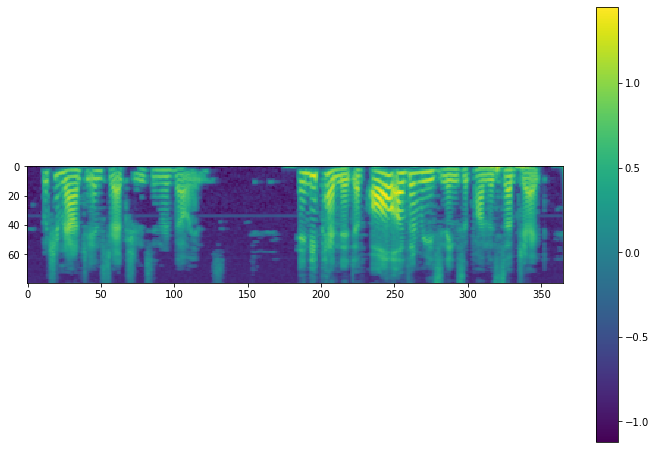

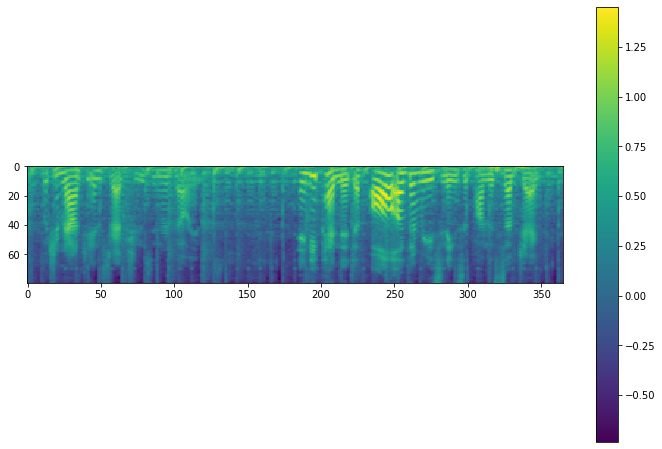

In [316]:
ind1 = 199 
ind2 = 1
img_clean = train_clean[ind1][ind2].astype(float)
img_noisy = train_noisy[ind1][ind2].astype(float)
plt.imshow(img_clean.T)
plt.colorbar()
plt.show()
plt.imshow(img_noisy.T)
plt.colorbar()

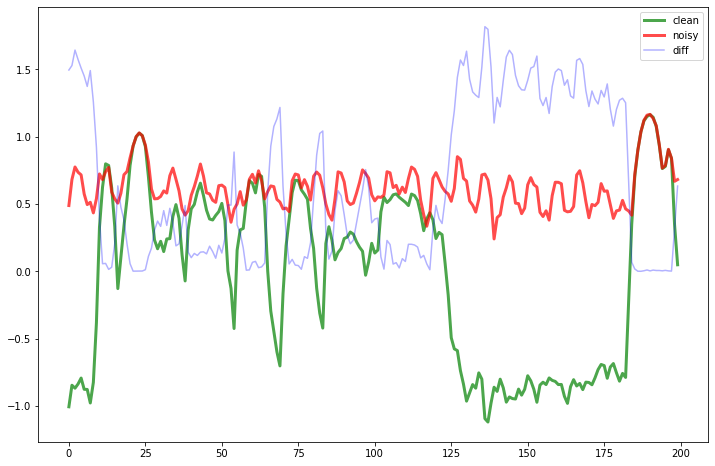

In [317]:
ind = 5
part = slice(0, 200)
plt.plot(img_clean[part, ind], color='g', label='clean', linewidth=3, alpha=.7)
plt.plot(img_noisy[part, ind], color='r', label='noisy', linewidth=3, alpha=.7)
plt.plot(np.abs(img_noisy[part, ind] - img_clean[part, ind]), color='b', label='diff', alpha=.3)
plt.legend()
plt.show()

На разных частотах шумы разные. более того, почти всегда шум импульсный - поднимает кусочек спектра во времени на +- постоянное значение. Разброс амплитуды вносит лишь минорный вклад.  
Также, похоже что чистые спектрограммы - это спектрограммы, обработанные какими-то алгоритмическими алгоритмами шумоподавления. Часто убранный шум имеет блочную структуру.

In [450]:
def data_mse(clean, noisy, fun=lambda x: x):
    ret = []
    for key in tqdm(list(clean.keys())):
        for clean_elem, noisy_elem in zip(clean[key], noisy[key]):
            ret.append(np.mean((clean_elem - fun(noisy_elem))**2))
    return np.mean(ret)

print('original mse train: ', data_mse(train_clean, train_noisy))
print('original mse val: ', data_mse(val_clean, val_noisy))


original mse train:  0.1326



original mse val:  0.1328


Самое простое решение - отрезать в спектрограмме значения ниже определенной квантили. При этом есть два варианта - общая квантиль для спектрограммы или собственноая квантиль для каждой частоты.

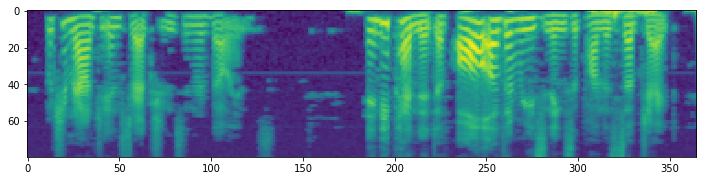

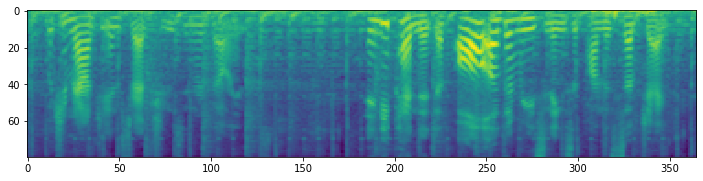

(0.2505094777518039, 0.2509530987835128)

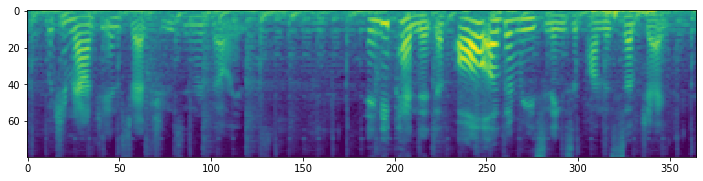

In [321]:
def cut_quantile(img, for_each_freq=False, q=.1):
    if for_each_freq:
        quantile = np.quantile(img, q, axis=0)
    else:
        quantile = np.quantile(img, q)
    img = np.clip(img, quantile, None)
    return img

plt.imshow(img_clean.T)
plt.show()
plt.imshow(img_noisy.T)
plt.show()
denoised = cut_quantile(img_noisy, for_each_freq=False, q=.01)
plt.imshow(denoised.T)
np.mean((img_clean - img_noisy)**2), np.mean((img_clean - denoised)**2)

In [331]:
np.min(img_clean)

-1.1201171875

In [337]:
img_clean.T[45, 140]

-0.86474609375

In [344]:
np.min(img_noisy)

-0.734375

Оба варианта не работают, так как срезают верхние частоты, оставляя шумы на нижних. Можно, конечно, подбирать квантили для каждой в отдельности, но для бэйзлайна я хочу протестировать еще один подход. Пользуемся тем, что записывается голос - значит, на спектрограмме для определенного момента будут пики на кратных частотах. Будем проверять их наличие, и, если их нет, выкидывать весь звук в этот момент времени целиком. 

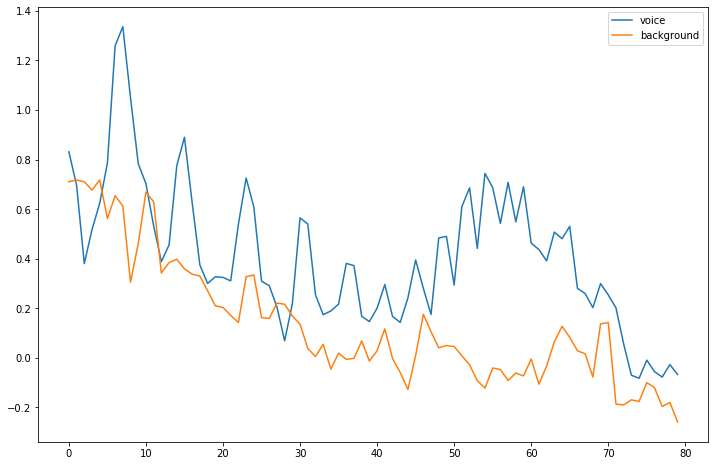

In [426]:
t_voice = 195 
t_back = 158
plt.plot(img_noisy[t_voice], label='voice')
plt.plot(img_noisy[t_back], label='background')
plt.legend()

In [427]:
find_peaks(img_noisy[t_voice, :40], 0.5)[0], find_peaks(img_noisy[t_back, :40], 0.5)[0]

(array([ 7, 15, 23, 30]), array([ 1,  4,  6, 10]))

In [425]:
np.quantile(img_noisy, .85)

0.591796875

Опытным путем понимаем, что человеческий голос определяется примерно первыми 40 рядами спектра, а октава - это 4-6 рядов спектра. Будем смотреть на пики выше определенной квантили, если среди них есть ряд из n_min, находящихся на одном расстоянии, но в этот момент времени голос был и мы его оставляем, если нет - убираем.  

In [446]:
def mask_non_voice(img, q=0.8, n_min=3):
    peak_thresh = np.quantile(img, q)
    mask = []
    for i, t_slice in enumerate(img[:,:40]):
        peaks = find_peaks(t_slice, peak_thresh)[0]
        if len(peaks) < n_min:
            mask.append(False)
            continue
        diffs = peaks[1:] - peaks[:-1]
        last = None
        count = 0
        for diff in diffs:
            if last is None or abs(last - diff) < 2 and diff >= 4:
                count += 1
            else:
                count = 0
            last = diff
            if count >= n_min-1:
                mask.append(True)
                break
        if len(mask) < i+1:
            mask.append(False)
    buf = np.ones(img.shape[1])*np.min(img)
    mask = np.array(mask)
    sliding_mask = mask.astype(int)
    sliding_mask[1:] += mask[:-1]
    sliding_mask[:-1] += mask[1:]
    mask[sliding_mask == 3] = True
    mask[sliding_mask <= 1] = False 
#     buf = np.zeros(img.shape[1])
    img = img.copy()
    img[np.logical_not(mask)] = buf
    return img

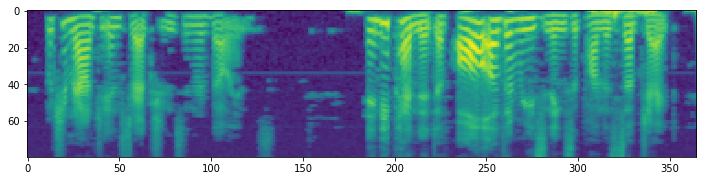

In [447]:
plt.imshow(img_clean.T)

In [456]:
denoised = mask_non_voice(img_noisy, q=.85, n_min=2)
plt.imshow(denoised.T)
np.mean((img_clean - img_noisy)**2), np.mean((img_clean - denoised)**2)

(0.2505094777518039, 0.17324380786014987)

In [458]:
ffun = lambda x: mask_non_voice(x, q=.5, n_min=3)
print('denoised mse train: ', data_mse(train_clean, train_noisy, ffun))
print('denoised mse val: ', data_mse(val_clean, val_noisy, ffun))

denoised mse train:  0.3892


denoised mse val:  0.4043


Попробуем еще вырезать определенные моменты времени по значению дисперсии

In [408]:
def mask_by_disp(img, thresh=0.1):
    mask = np.var(img, axis=1) > thresh
    
    sliding_mask = mask.astype(int)
    sliding_mask[1:] += mask[:-1]
    sliding_mask[:-1] += mask[1:]
    mask[sliding_mask == 3] = True
    mask[sliding_mask <= 1] = False 
    
    buf = np.ones(img.shape[1])*np.quantile(img, .01)
    img = img.copy()
    img[np.logical_not(mask)] = buf
    return img

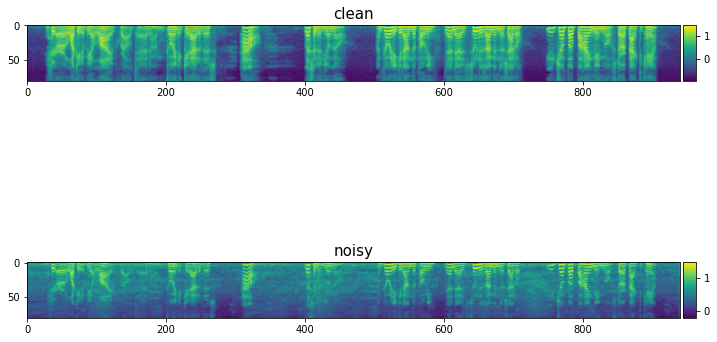

(80, 940)


original mse: 0.2391
denoised mse: 0.1260955363318984


In [444]:
rand_clean, rand_noisy = random_pair(train_clean, train_noisy)
denoised = restore_fun(mask_by_disp(norm_fun(rand_noisy), .006)).astype(float)
print(denoised.T.shape)
plt.imshow(denoised.T)
plt.title('denoised', fontsize=20)
plt.show()
print('original mse:', np.mean((rand_noisy - rand_clean)**2))
print('denoised mse:', np.mean((denoised - rand_clean)**2))

визуально этот метод неплохо определяет куски речи (иногда), но универсальное значение для паддинга подобрать не так просто + на некоторых данных появляются максимумы, точно не являющиеся голосом, но почему-то пресутствующие на clean.

## Улучшение

In [7]:
from models import Regressor
from training import validate, train, collate_fn, MSE_masked_loss, SpectrogramDataset
from utils import load_best_model, train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
%load_ext autoreload
%autoreload 2

/home/warden/miniconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/warden/miniconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/warden/miniconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/warden/miniconda3/lib/python3.7/site-packages/tensor

### сырые данные

In [8]:
train_part_clean, train_part_noisy, test_part_clean, test_part_noisy = train_test_split(train_clean, train_noisy)

In [105]:
model = Regressor(gradient_clip=50, blocks=((1, 16), (16, 32), (32, 64), (64, 128))) # 0.721

#2 convs
# model = Regressor(gradient_clip=50, blocks=((1, 8), (8, 16), (16, 32))) # 
cp_folder = 'checkpoints/regression_checkpoints3'

train_dataset = SpectrogramDataset(train_part_clean, train_part_noisy)
test_dataset = SpectrogramDataset(test_part_clean, test_part_noisy)
print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1, collate_fn=collate_fn) 
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=collate_fn) 

criterion = MSE_masked_loss
# criterion = nn.MSELoss() 
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

train: 9607, test: 2393


In [ ]:
train(model, optimizer, criterion, train_loader, test_loader, n_epochs=30, n_verbose=30, jupyter=True, checkpoints=cp_folder, mode='regression')

[0, 30] avg_mse: 0.20165316760540009 avg_loss: 0.20165319641431173
[0, 60] avg_mse: 0.17945989966392517 avg_loss: 0.17945988227923712
[0, 90] avg_mse: 0.15101642906665802 avg_loss: 0.15101641962925594
[0, 120] avg_mse: 0.1542077660560608 avg_loss: 0.15420774246255556
[0, 150] avg_mse: 0.1281745284795761 avg_loss: 0.1281745155652364
[0, 180] avg_mse: 0.12520620226860046 avg_loss: 0.12520621245106062
[0, 210] avg_mse: 0.12791936099529266 avg_loss: 0.1279193341732025
[0, 240] avg_mse: 0.12035078555345535 avg_loss: 0.12035078306992848
[0, 270] avg_mse: 0.12718401849269867 avg_loss: 0.12718401129047077
[0, 300] avg_mse: 0.1102791279554367 avg_loss: 0.11027911727627118

validating



epoch 0 train | mse: 0.14244556427001953, loss: 0.14244562276079012
epoch 0 test | mse: 0.10472298413515091, loss: 0.10472298413515091
saving checkpoint to checkpoints/regression_checkpoints3/epoch_0__mse_0.1047.pth


[1, 30] avg_mse: 0.11171837151050568 avg_loss: 0.11171836405992508
[1, 60] avg_mse: 0.10663048923015594 avg_loss: 0.10663048798839252
[1, 90] avg_mse: 0.10483553260564804 avg_loss: 0.10483552018801372
[1, 120] avg_mse: 0.10445820540189743 avg_loss: 0.1044581929842631
[1, 150] avg_mse: 0.09903065115213394 avg_loss: 0.09903065214554468
[1, 180] avg_mse: 0.10219132155179977 avg_loss: 0.10219132751226426
[1, 210] avg_mse: 0.10499699413776398 avg_loss: 0.10499697948495547
[1, 240] avg_mse: 0.1022963747382164 avg_loss: 0.10229636455575625
[1, 270] avg_mse: 0.10073982924222946 avg_loss: 0.10073981806635857
[1, 300] avg_mse: 0.1011708453297615 avg_loss: 0.10117085352540016

validating



epoch 1 train | mse: 0.10376940667629242, loss: 0.10376943459740509
epoch 1 test | mse: 0.09022427350282669, loss: 0.09022427350282669
saving checkpoint to checkpoints/regression_checkpoints3/epoch_1__mse_0.0902.pth


[2, 30] avg_mse: 0.09862963110208511 avg_loss: 0.09862962638338407
[2, 60] avg_mse: 0.09547533094882965 avg_loss: 0.09547531555096309
[2, 90] avg_mse: 0.10324355959892273 avg_loss: 0.10324355661869049
[2, 120] avg_mse: 0.09881951659917831 avg_loss: 0.09881951262553533
[2, 150] avg_mse: 0.0892464891076088 avg_loss: 0.08924648823837439
[2, 180] avg_mse: 0.09161398559808731 avg_loss: 0.09161397454639277
[2, 210] avg_mse: 0.09395813941955566 avg_loss: 0.09395813917120298
[2, 240] avg_mse: 0.0923960953950882 avg_loss: 0.09239608769615491
[2, 270] avg_mse: 0.0902005285024643 avg_loss: 0.09020053793986639
[2, 300] avg_mse: 0.1003529280424118 avg_loss: 0.1003529225786527

validating



epoch 2 train | mse: 0.09522737562656403, loss: 0.0952273346731235
epoch 2 test | mse: 0.0879773199558258, loss: 0.0879773199558258
saving checkpoint to checkpoints/regression_checkpoints3/epoch_2__mse_0.0880.pth


[3, 30] avg_mse: 0.09885327517986298 avg_loss: 0.09885326698422432
[3, 60] avg_mse: 0.097261443734169 avg_loss: 0.09726143230994543
[3, 90] avg_mse: 0.09151297807693481 avg_loss: 0.0915129774560531
[3, 120] avg_mse: 0.09306948632001877 avg_loss: 0.09306949190795422
[3, 150] avg_mse: 0.08758948743343353 avg_loss: 0.08758948569496473
[3, 180] avg_mse: 0.09094902127981186 avg_loss: 0.09094901978969575
[3, 210] avg_mse: 0.08924988657236099 avg_loss: 0.08924988483389219
[3, 240] avg_mse: 0.08796904981136322 avg_loss: 0.08796904521683852
[3, 270] avg_mse: 0.08328036218881607 avg_loss: 0.083280340457956
[3, 300] avg_mse: 0.09178861230611801 avg_loss: 0.09178861329952875

validating



epoch 3 train | mse: 0.09103890508413315, loss: 0.09103891939122812
epoch 3 test | mse: 0.08285598456859589, loss: 0.08285598456859589
saving checkpoint to checkpoints/regression_checkpoints3/epoch_3__mse_0.0829.pth


[4, 30] avg_mse: 0.08926074951887131 avg_loss: 0.08926074778040251
[4, 60] avg_mse: 0.08851969987154007 avg_loss: 0.08851969552536805
[4, 90] avg_mse: 0.08804042637348175 avg_loss: 0.08804042016466458
[4, 120] avg_mse: 0.08782074600458145 avg_loss: 0.08782072961330414
[4, 150] avg_mse: 0.08431663364171982 avg_loss: 0.08431661973396937
[4, 180] avg_mse: 0.09209827333688736 avg_loss: 0.09209825495878855
[4, 210] avg_mse: 0.08856233209371567 avg_loss: 0.08856230701009432
[4, 240] avg_mse: 0.08542948961257935 avg_loss: 0.0854294914752245
[4, 270] avg_mse: 0.08867213875055313 avg_loss: 0.08867213564614455
[4, 300] avg_mse: 0.09102779626846313 avg_loss: 0.09102779775857925

validating



epoch 4 train | mse: 0.0882619321346283, loss: 0.08826194128077292
epoch 4 test | mse: 0.08190486580133438, loss: 0.08190486580133438
saving checkpoint to checkpoints/regression_checkpoints3/epoch_4__mse_0.0819.pth


[5, 30] avg_mse: 0.0912657305598259 avg_loss: 0.09126571590701739
[5, 60] avg_mse: 0.0847044363617897 avg_loss: 0.08470442903538546
[5, 90] avg_mse: 0.08376530557870865 avg_loss: 0.08376529514789581
[5, 120] avg_mse: 0.08974576741456985 avg_loss: 0.0897457638134559
[5, 150] avg_mse: 0.08847220242023468 avg_loss: 0.08847220415870348
[5, 180] avg_mse: 0.08245442807674408 avg_loss: 0.08245443254709243
[5, 210] avg_mse: 0.08674052357673645 avg_loss: 0.08674050557116668
[5, 240] avg_mse: 0.08729276061058044 avg_loss: 0.08729276458422343
[5, 270] avg_mse: 0.08565271645784378 avg_loss: 0.08565270354350409
[5, 300] avg_mse: 0.08432415872812271 avg_loss: 0.08432417151828607

validating



epoch 5 train | mse: 0.08645020425319672, loss: 0.0864501822232408
epoch 5 test | mse: 0.07988414913415909, loss: 0.07988414913415909
saving checkpoint to checkpoints/regression_checkpoints3/epoch_5__mse_0.0799.pth


[6, 30] avg_mse: 0.08464554697275162 avg_loss: 0.0846455325682958
[6, 60] avg_mse: 0.07932136952877045 avg_loss: 0.0793213665485382
[6, 90] avg_mse: 0.08481008559465408 avg_loss: 0.08481009105841318
[6, 120] avg_mse: 0.08331460505723953 avg_loss: 0.0833145981033643
[6, 150] avg_mse: 0.08225692808628082 avg_loss: 0.08225692361593247
[6, 180] avg_mse: 0.08423358201980591 avg_loss: 0.0842335768043995
[6, 210] avg_mse: 0.08804937452077866 avg_loss: 0.08804936458667119
[6, 240] avg_mse: 0.08866322785615921 avg_loss: 0.08866321071982383
[6, 270] avg_mse: 0.08575710654258728 avg_loss: 0.08575709958871205
[6, 300] avg_mse: 0.0873824805021286 avg_loss: 0.08738249676922957

validating



epoch 6 train | mse: 0.08499222993850708, loss: 0.08499223205486801
epoch 6 test | mse: 0.07934468239545822, loss: 0.07934468239545822
saving checkpoint to checkpoints/regression_checkpoints3/epoch_6__mse_0.0793.pth


[7, 30] avg_mse: 0.09118784964084625 avg_loss: 0.09118784988919894
[7, 60] avg_mse: 0.08573158830404282 avg_loss: 0.08573157700399557
[7, 90] avg_mse: 0.08657906204462051 avg_loss: 0.08657906763255596
[7, 120] avg_mse: 0.08781739324331284 avg_loss: 0.08781738939384619
[7, 150] avg_mse: 0.08552935719490051 avg_loss: 0.08552933894097806
[7, 180] avg_mse: 0.07982698827981949 avg_loss: 0.0798269797116518
[7, 210] avg_mse: 0.08561387658119202 avg_loss: 0.08561386354267597
[7, 240] avg_mse: 0.08556224405765533 avg_loss: 0.08556223946313063
[7, 270] avg_mse: 0.07538937777280807 avg_loss: 0.07538937653104465
[7, 300] avg_mse: 0.07940465956926346 avg_loss: 0.07940466391543548

validating



epoch 7 train | mse: 0.08437596261501312, loss: 0.08437598563507942
epoch 7 test | mse: 0.078127421438694, loss: 0.078127421438694
saving checkpoint to checkpoints/regression_checkpoints3/epoch_7__mse_0.0781.pth


[8, 30] avg_mse: 0.08403415232896805 avg_loss: 0.0840341504663229
[8, 60] avg_mse: 0.08286071568727493 avg_loss: 0.08286070500810941
[8, 90] avg_mse: 0.08479633182287216 avg_loss: 0.08479631332059702
[8, 120] avg_mse: 0.08165808022022247 avg_loss: 0.0816580777366956
[8, 150] avg_mse: 0.08265653997659683 avg_loss: 0.08265652519961199
[8, 180] avg_mse: 0.08766303211450577 avg_loss: 0.08766302901009719
[8, 210] avg_mse: 0.08624440431594849 avg_loss: 0.08624440518518289
[8, 240] avg_mse: 0.08426623791456223 avg_loss: 0.08426622599363327
[8, 270] avg_mse: 0.08083155006170273 avg_loss: 0.08083153863747915
[8, 300] avg_mse: 0.07769925147294998 avg_loss: 0.07769924340148766

validating



epoch 8 train | mse: 0.08328362554311752, loss: 0.0832836439344178
epoch 8 test | mse: 0.07882425934076309, loss: 0.07882425934076309
saving checkpoint to checkpoints/regression_checkpoints3/epoch_8__mse_0.0788.pth


[9, 30] avg_mse: 0.07737046480178833 avg_loss: 0.07737045350174108
[9, 60] avg_mse: 0.08112397789955139 avg_loss: 0.08112397889296213
[9, 90] avg_mse: 0.07905298471450806 avg_loss: 0.07905297167599201
[9, 120] avg_mse: 0.0808548778295517 avg_loss: 0.08085488453507424
[9, 150] avg_mse: 0.08201011270284653 avg_loss: 0.08201009978850683
[9, 180] avg_mse: 0.08406899124383926 avg_loss: 0.08406899720430375
[9, 210] avg_mse: 0.08644522726535797 avg_loss: 0.08644521757960319
[9, 240] avg_mse: 0.08474209904670715 avg_loss: 0.08474209296206633
[9, 270] avg_mse: 0.08829481154680252 avg_loss: 0.08829480260610581
[9, 300] avg_mse: 0.08517994731664658 avg_loss: 0.08517993688583374

validating



epoch 9 train | mse: 0.08278494328260422, loss: 0.08278494426033822
epoch 9 test | mse: 0.07684091478586197, loss: 0.07684091478586197
saving checkpoint to checkpoints/regression_checkpoints3/epoch_9__mse_0.0768.pth


[10, 30] avg_mse: 0.07957011461257935 avg_loss: 0.07957010827958584
[10, 60] avg_mse: 0.08286170661449432 avg_loss: 0.08286169953644276
[10, 90] avg_mse: 0.08854792267084122 avg_loss: 0.08854792068401972
[10, 120] avg_mse: 0.0850537121295929 avg_loss: 0.08505370741089185
[10, 150] avg_mse: 0.08388970792293549 avg_loss: 0.08388970953722795
[10, 180] avg_mse: 0.08321911841630936 avg_loss: 0.08321911233166854
[10, 210] avg_mse: 0.08161895722150803 avg_loss: 0.08161894616981348
[10, 240] avg_mse: 0.07679135352373123 avg_loss: 0.0767913660655419
[10, 270] avg_mse: 0.08215727657079697 avg_loss: 0.08215726055204868
[10, 300] avg_mse: 0.07839278876781464 avg_loss: 0.07839278851946195

validating



epoch 10 train | mse: 0.08213787525892258, loss: 0.08213787039500535
epoch 10 test | mse: 0.07699732482433319, loss: 0.07699732482433319
saving checkpoint to checkpoints/regression_checkpoints3/epoch_10__mse_0.0770.pth


[11, 30] avg_mse: 0.08687905222177505 avg_loss: 0.08687905135254065
[11, 60] avg_mse: 0.08716043084859848 avg_loss: 0.08716042439142863
[11, 90] avg_mse: 0.07680173218250275 avg_loss: 0.0768017292022705
[11, 120] avg_mse: 0.08226785808801651 avg_loss: 0.0822678546110789
[11, 150] avg_mse: 0.07932548969984055 avg_loss: 0.07932548485696315
[11, 180] avg_mse: 0.08127161860466003 avg_loss: 0.08127162543435891
[11, 210] avg_mse: 0.0799022689461708 avg_loss: 0.07990226745605469
[11, 240] avg_mse: 0.07852465659379959 avg_loss: 0.07852465733885765
[11, 270] avg_mse: 0.077189601957798 avg_loss: 0.07718958867092927
[11, 300] avg_mse: 0.0818767175078392 avg_loss: 0.08187671514848868

validating



epoch 11 train | mse: 0.08113469928503036, loss: 0.08113470937177984
epoch 11 test | mse: 0.07659909874200821, loss: 0.07659909874200821
saving checkpoint to checkpoints/regression_checkpoints3/epoch_11__mse_0.0766.pth


[12, 30] avg_mse: 0.08367233723402023 avg_loss: 0.08367232816914717
[12, 60] avg_mse: 0.07495879381895065 avg_loss: 0.07495879841347536
[12, 90] avg_mse: 0.08052832633256912 avg_loss: 0.08052832211057345
[12, 120] avg_mse: 0.08224304765462875 avg_loss: 0.08224303449193636
[12, 150] avg_mse: 0.0784863829612732 avg_loss: 0.07848638991514842
[12, 180] avg_mse: 0.08152057975530624 avg_loss: 0.0815205798794826
[12, 210] avg_mse: 0.0861443430185318 avg_loss: 0.08614434649546941
[12, 240] avg_mse: 0.07678882777690887 avg_loss: 0.07678882479667663
[12, 270] avg_mse: 0.08218107372522354 avg_loss: 0.08218107248346011
[12, 300] avg_mse: 0.08021679520606995 avg_loss: 0.08021679297089576

validating



epoch 12 train | mse: 0.08080348372459412, loss: 0.08080346329119119
epoch 12 test | mse: 0.07505903393030167, loss: 0.07505903393030167
saving checkpoint to checkpoints/regression_checkpoints3/epoch_12__mse_0.0751.pth


[13, 30] avg_mse: 0.07751967757940292 avg_loss: 0.07751966578265031
[13, 60] avg_mse: 0.07999376952648163 avg_loss: 0.0799937636901935
[13, 90] avg_mse: 0.07846222072839737 avg_loss: 0.07846221687893072
[13, 120] avg_mse: 0.08135245740413666 avg_loss: 0.0813524603843689
[13, 150] avg_mse: 0.08057936280965805 avg_loss: 0.08057935448984305
[13, 180] avg_mse: 0.08091402798891068 avg_loss: 0.08091403320431709
[13, 210] avg_mse: 0.08525159955024719 avg_loss: 0.08525159557660421
[13, 240] avg_mse: 0.0780753344297409 avg_loss: 0.0780753197769324
[13, 270] avg_mse: 0.08160672336816788 avg_loss: 0.08160671715935071
[13, 300] avg_mse: 0.08182588964700699 avg_loss: 0.08182588865359625

validating



epoch 13 train | mse: 0.08042702823877335, loss: 0.08042700417909115
epoch 13 test | mse: 0.07627800852060318, loss: 0.07627800852060318
saving checkpoint to checkpoints/regression_checkpoints3/epoch_13__mse_0.0763.pth


[14, 30] avg_mse: 0.08366803824901581 avg_loss: 0.08366803179184595
[14, 60] avg_mse: 0.08016251772642136 avg_loss: 0.08016251511871815
[14, 90] avg_mse: 0.07790764421224594 avg_loss: 0.07790764930347602
[14, 120] avg_mse: 0.07924680411815643 avg_loss: 0.07924679554998874
[14, 150] avg_mse: 0.07980898022651672 avg_loss: 0.07980897128582001
[14, 180] avg_mse: 0.07916513830423355 avg_loss: 0.07916514451305072
[14, 210] avg_mse: 0.07508135586977005 avg_loss: 0.0750813614577055
[14, 240] avg_mse: 0.08124250918626785 avg_loss: 0.08124248447517554
[14, 270] avg_mse: 0.08707910031080246 avg_loss: 0.08707909646133581
[14, 300] avg_mse: 0.07922932505607605 avg_loss: 0.07922931971649329

validating



epoch 14 train | mse: 0.08031395822763443, loss: 0.0803139319278275
epoch 14 test | mse: 0.07452022284269333, loss: 0.07452022284269333
saving checkpoint to checkpoints/regression_checkpoints3/epoch_14__mse_0.0745.pth


[15, 30] avg_mse: 0.07947982102632523 avg_loss: 0.07947981593509515
[15, 60] avg_mse: 0.07633981108665466 avg_loss: 0.07633980972071489
[15, 90] avg_mse: 0.08304136246442795 avg_loss: 0.08304135290284952
[15, 120] avg_mse: 0.07596708089113235 avg_loss: 0.07596706598997116
[15, 150] avg_mse: 0.08002904057502747 avg_loss: 0.08002903498709202
[15, 180] avg_mse: 0.07754319161176682 avg_loss: 0.07754317993919055
[15, 210] avg_mse: 0.0771595686674118 avg_loss: 0.0771595677981774
[15, 240] avg_mse: 0.08241627365350723 avg_loss: 0.0824162603666385
[15, 270] avg_mse: 0.08561958372592926 avg_loss: 0.08561959688862165
[15, 300] avg_mse: 0.08066389709711075 avg_loss: 0.08066390305757523

validating



epoch 15 train | mse: 0.07971914112567902, loss: 0.07971918608906657
epoch 15 test | mse: 0.07482826709747314, loss: 0.07482826709747314
saving checkpoint to checkpoints/regression_checkpoints3/epoch_15__mse_0.0748.pth


[16, 30] avg_mse: 0.07978401333093643 avg_loss: 0.07978401680787404
[16, 60] avg_mse: 0.08091655373573303 avg_loss: 0.08091655100385348
[16, 90] avg_mse: 0.07730977237224579 avg_loss: 0.07730976939201355
[16, 120] avg_mse: 0.08108238130807877 avg_loss: 0.08108237385749817
[16, 150] avg_mse: 0.08082365244626999 avg_loss: 0.08082365517814954
[16, 180] avg_mse: 0.07581625133752823 avg_loss: 0.07581625469028949
[16, 210] avg_mse: 0.080969899892807 avg_loss: 0.08096989542245865
[16, 240] avg_mse: 0.07551241666078568 avg_loss: 0.07551241566737493
[16, 270] avg_mse: 0.08110709488391876 avg_loss: 0.08110709227621556
[16, 300] avg_mse: 0.08448426425457001 avg_loss: 0.08448426760733127

validating



epoch 16 train | mse: 0.07972627878189087, loss: 0.07972629451226951
epoch 16 test | mse: 0.07415105402469635, loss: 0.07415105402469635
saving checkpoint to checkpoints/regression_checkpoints3/epoch_16__mse_0.0742.pth


[17, 30] avg_mse: 0.08083170652389526 avg_loss: 0.08083170192937056
[17, 60] avg_mse: 0.08018884062767029 avg_loss: 0.08018884311119716
[17, 90] avg_mse: 0.07788118720054626 avg_loss: 0.0778811939060688
[17, 120] avg_mse: 0.07832086831331253 avg_loss: 0.07832085999349753
[17, 150] avg_mse: 0.07970120012760162 avg_loss: 0.07970119267702103
[17, 180] avg_mse: 0.07890934497117996 avg_loss: 0.0789093387623628
[17, 210] avg_mse: 0.08405828475952148 avg_loss: 0.08405829258263112
[17, 240] avg_mse: 0.07622069120407104 avg_loss: 0.07622068300843239
[17, 270] avg_mse: 0.07206922769546509 avg_loss: 0.07206922521193822
[17, 300] avg_mse: 0.08340135961771011 avg_loss: 0.0834013544023037

validating



epoch 17 train | mse: 0.07921939343214035, loss: 0.07921938062258733
epoch 17 test | mse: 0.07423131912946701, loss: 0.07423131912946701
saving checkpoint to checkpoints/regression_checkpoints3/epoch_17__mse_0.0742.pth


[18, 30] avg_mse: 0.07610873878002167 avg_loss: 0.07610872834920883
[18, 60] avg_mse: 0.0734943300485611 avg_loss: 0.07349432172874609
[18, 90] avg_mse: 0.08413940668106079 avg_loss: 0.08413940978546937
[18, 120] avg_mse: 0.08085566759109497 avg_loss: 0.08085567032297453
[18, 150] avg_mse: 0.08011294901371002 avg_loss: 0.08011294379830361
[18, 180] avg_mse: 0.07614113390445709 avg_loss: 0.07614113266269366
[18, 210] avg_mse: 0.08114685863256454 avg_loss: 0.08114684832592806
[18, 240] avg_mse: 0.07886252552270889 avg_loss: 0.07886253098646799
[18, 270] avg_mse: 0.0789528340101242 avg_loss: 0.07895282370348772
[18, 300] avg_mse: 0.07736212760210037 avg_loss: 0.07736211878558

validating



epoch 18 train | mse: 0.07866732776165009, loss: 0.07866730930846791
epoch 18 test | mse: 0.07383925467729568, loss: 0.07383925467729568
saving checkpoint to checkpoints/regression_checkpoints3/epoch_18__mse_0.0738.pth


[19, 30] avg_mse: 0.07606090605258942 avg_loss: 0.07606088767449061
[19, 60] avg_mse: 0.07454206049442291 avg_loss: 0.07454206521312395
[19, 90] avg_mse: 0.0846136286854744 avg_loss: 0.0846136221041282
[19, 120] avg_mse: 0.07860872149467468 avg_loss: 0.07860872633755207
[19, 150] avg_mse: 0.08170298486948013 avg_loss: 0.08170298611124356
[19, 180] avg_mse: 0.07641817629337311 avg_loss: 0.07641817244390646
[19, 210] avg_mse: 0.07662918418645859 avg_loss: 0.07662918654580911
[19, 240] avg_mse: 0.0772036537528038 avg_loss: 0.07720364704728126
[19, 270] avg_mse: 0.08049103617668152 avg_loss: 0.08049103717009226
[19, 300] avg_mse: 0.07823274284601212 avg_loss: 0.07823275104165077

validating



epoch 19 train | mse: 0.07853610068559647, loss: 0.07853607471995179
epoch 19 test | mse: 0.0742727518081665, loss: 0.0742727518081665
saving checkpoint to checkpoints/regression_checkpoints3/epoch_19__mse_0.0743.pth


[20, 30] avg_mse: 0.07669563591480255 avg_loss: 0.07669563243786494
[20, 60] avg_mse: 0.08073294907808304 avg_loss: 0.08073294709126154
[20, 90] avg_mse: 0.08180288970470428 avg_loss: 0.08180288163324197
[20, 120] avg_mse: 0.07819835841655731 avg_loss: 0.0781983538220326
[20, 150] avg_mse: 0.08056006580591202 avg_loss: 0.08056005636850992
[20, 180] avg_mse: 0.07686790823936462 avg_loss: 0.07686790861189366
[20, 210] avg_mse: 0.08056895434856415 avg_loss: 0.08056893919905027
[20, 240] avg_mse: 0.07030875980854034 avg_loss: 0.07030874888102213
[20, 270] avg_mse: 0.07915255427360535 avg_loss: 0.0791525616000096
[20, 300] avg_mse: 0.07662812620401382 avg_loss: 0.07662812098860741

validating



epoch 20 train | mse: 0.07831918448209763, loss: 0.07831920604175112
epoch 20 test | mse: 0.07360860705375671, loss: 0.07360860705375671
saving checkpoint to checkpoints/regression_checkpoints3/epoch_20__mse_0.0736.pth


[21, 30] avg_mse: 0.07893450558185577 avg_loss: 0.07893450024227301
[21, 60] avg_mse: 0.07726629823446274 avg_loss: 0.07726629450917244
[21, 90] avg_mse: 0.07663574814796448 avg_loss: 0.07663574951390426
[21, 120] avg_mse: 0.07823681086301804 avg_loss: 0.07823681111137072
[21, 150] avg_mse: 0.08246996253728867 avg_loss: 0.0824699563284715
[21, 180] avg_mse: 0.07406352460384369 avg_loss: 0.07406353428959847
[21, 210] avg_mse: 0.07966244965791702 avg_loss: 0.07966245375573636
[21, 240] avg_mse: 0.07554476708173752 avg_loss: 0.0755447546641032
[21, 270] avg_mse: 0.08022428303956985 avg_loss: 0.08022426764170329
[21, 300] avg_mse: 0.08108578622341156 avg_loss: 0.08108579901357492

validating



epoch 21 train | mse: 0.07836859673261642, loss: 0.07836861245061869
epoch 21 test | mse: 0.0745859444141388, loss: 0.0745859444141388
saving checkpoint to checkpoints/regression_checkpoints3/epoch_21__mse_0.0746.pth


[22, 30] avg_mse: 0.07621771097183228 avg_loss: 0.07621771146853765
[22, 60] avg_mse: 0.08384573459625244 avg_loss: 0.0838457195709149
[22, 90] avg_mse: 0.07784213870763779 avg_loss: 0.07784213560322921
[22, 120] avg_mse: 0.07829134911298752 avg_loss: 0.07829134551187357
[22, 150] avg_mse: 0.07864435762166977 avg_loss: 0.07864435364802679
[22, 180] avg_mse: 0.07821494340896606 avg_loss: 0.0782149481276671
[22, 210] avg_mse: 0.07457228004932404 avg_loss: 0.0745722685009241
[22, 240] avg_mse: 0.07808662205934525 avg_loss: 0.07808661485711733
[22, 270] avg_mse: 0.07707565277814865 avg_loss: 0.0770756397396326
[22, 300] avg_mse: 0.08072048425674438 avg_loss: 0.08072048177321751

validating



epoch 22 train | mse: 0.07855565845966339, loss: 0.07855566978405085
epoch 22 test | mse: 0.07321781665086746, loss: 0.07321781665086746
saving checkpoint to checkpoints/regression_checkpoints3/epoch_22__mse_0.0732.pth


[23, 30] avg_mse: 0.07234445959329605 avg_loss: 0.0723444448163112
[23, 60] avg_mse: 0.07565372437238693 avg_loss: 0.0756537174185117
[23, 90] avg_mse: 0.07471155375242233 avg_loss: 0.07471155598759652
[23, 120] avg_mse: 0.07563740015029907 avg_loss: 0.07563738996783892
[23, 150] avg_mse: 0.08014180511236191 avg_loss: 0.08014180349806944
[23, 180] avg_mse: 0.07817519456148148 avg_loss: 0.07817517990867297
[23, 210] avg_mse: 0.08342913538217545 avg_loss: 0.08342911675572395
[23, 240] avg_mse: 0.0775664746761322 avg_loss: 0.07756647939483324
[23, 270] avg_mse: 0.07885685563087463 avg_loss: 0.07885683986047903
[23, 300] avg_mse: 0.0805947557091713 avg_loss: 0.08059474304318429

validating



epoch 23 train | mse: 0.07772260904312134, loss: 0.07772262212495472
epoch 23 test | mse: 0.072889544069767, loss: 0.072889544069767
saving checkpoint to checkpoints/regression_checkpoints3/epoch_23__mse_0.0729.pth


[24, 30] avg_mse: 0.07696455717086792 avg_loss: 0.07696456474562487
[24, 60] avg_mse: 0.07552283257246017 avg_loss: 0.07552283431092897
[24, 90] avg_mse: 0.07537224143743515 avg_loss: 0.07537222442527612
[24, 120] avg_mse: 0.07799119502305984 avg_loss: 0.07799119129776955
[24, 150] avg_mse: 0.07652410119771957 avg_loss: 0.0765241035570701
[24, 180] avg_mse: 0.0794198289513588 avg_loss: 0.07941983416676521
[24, 210] avg_mse: 0.07415800541639328 avg_loss: 0.07415800082186857
[24, 240] avg_mse: 0.0791475847363472 avg_loss: 0.0791475709527731
[24, 270] avg_mse: 0.07790351659059525 avg_loss: 0.07790351038177808
[24, 300] avg_mse: 0.07800335437059402 avg_loss: 0.07800335362553597

validating



epoch 24 train | mse: 0.07699491083621979, loss: 0.07699490988323855
epoch 24 test | mse: 0.07240406423807144, loss: 0.07240406423807144
saving checkpoint to checkpoints/regression_checkpoints3/epoch_24__mse_0.0724.pth


[25, 30] avg_mse: 0.07907803356647491 avg_loss: 0.07907803282141686
[25, 60] avg_mse: 0.07807989418506622 avg_loss: 0.0780798861136039
[25, 90] avg_mse: 0.07756094634532928 avg_loss: 0.07756094224750995
[25, 120] avg_mse: 0.07888011634349823 avg_loss: 0.07888011460502943
[25, 150] avg_mse: 0.07845553755760193 avg_loss: 0.07845552998284498
[25, 180] avg_mse: 0.0768243744969368 avg_loss: 0.07682437400023143
[25, 210] avg_mse: 0.07441160827875137 avg_loss: 0.0744116106381019
[25, 240] avg_mse: 0.07975252717733383 avg_loss: 0.07975252556304137
[25, 270] avg_mse: 0.07261203229427338 avg_loss: 0.0726120329151551
[25, 300] avg_mse: 0.07713107764720917 avg_loss: 0.07713106957574685

validating


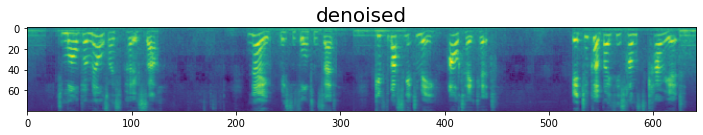

original mse: 0.0482
denoised mse: 0.027141849


In [40]:
rand_clean, rand_noisy = random_pair(train_clean, train_noisy)
denoised = model.process_image(rand_noisy)
plt.imshow(denoised.T)
plt.title('denoised', fontsize=20)
plt.show()
print('original mse:', np.mean((rand_noisy - rand_clean)**2))
print('denoised mse:', np.mean((denoised - rand_clean)**2))

In [59]:
val_dataset = SpectrogramDataset(val_clean, val_noisy)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=collate_fn) 
print(f'val: {len(val_dataset)}')

best_model = load_best_model(model, cp_folder, best_max=False)
# best_state = torch.load('checkpoints/regression_checkpoints2/epoch_24__mse_0.0702.pth')
model.load_state_dict(best_state)

best_model = model
mse = validate(model, val_loader, criterion, jupyter=True, mode='regression')
print(f'mse: {mse}')

val: 2000



mse: (tensor(0.0721, device='cuda:0'), tensor(0.0721, device='cuda:0'))


In [15]:
state_dict = torch.load(os.path.join(cp_folder, 'epoch_26__mse_0.0747.pth'))
state_dict.keys()

odict_keys(['e_conv1.weight', 'e_conv1.bias', 'e_conv2.weight', 'e_conv2.bias', 'd_tconv1.weight', 'd_tconv1.bias', 'd_tconv2.weight', 'd_tconv2.bias'])

In [16]:
model.state_dict().keys()

odict_keys(['encoder.0.0.weight', 'encoder.0.0.bias', 'encoder.1.0.weight', 'encoder.1.0.bias', 'decoder.0.1.weight', 'decoder.0.1.bias', 'decoder.1.1.weight', 'decoder.1.1.bias'])

In [17]:
from collections import OrderedDict
new_state = OrderedDict()

new_state['encoder.0.0.weight'] = state_dict['e_conv1.weight']
new_state['encoder.0.0.bias'] = state_dict['e_conv1.bias']
new_state['encoder.1.0.weight'] = state_dict['e_conv2.weight']
new_state['encoder.1.0.bias'] = state_dict['e_conv2.bias']

new_state['decoder.0.1.weight'] = state_dict['d_tconv1.weight']
new_state['decoder.0.1.bias'] = state_dict['d_tconv1.bias']
new_state['decoder.1.1.weight'] = state_dict['d_tconv2.weight']
new_state['decoder.1.1.bias'] = state_dict['d_tconv2.bias']

model.load_state_dict(new_state)

<All keys matched successfully>

### Нормированные данные

Примем во внимание, что mse, выдаваемый criterion'ом, меньше реального в scale^2 раз (так как все картинки на это значение поделены). При валидации нужно будет домножать.

In [21]:
model = Regressor(gradient_clip=50)
cp_folder = 'checkpoints/norm_regression_checkpoints'

norm_fun, restore_fun, scale = get_norm_function(train_part_clean, train_part_noisy)
train_dataset = SpectrogramDataset(train_part_clean, train_part_noisy, norm_fun)
test_dataset = SpectrogramDataset(test_part_clean, test_part_noisy, norm_fun)
print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1, collate_fn=collate_fn) 
test_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=collate_fn) 

criterion = MSE_masked_loss
# criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

train: 9607, test: 2393


In [22]:
train(model, optimizer, criterion, train_loader, test_loader, n_epochs=30, n_verbose=30, jupyter=True, checkpoints=cp_folder, mode='regression')

[0, 30]avg_loss: 0.03204368632286787
[0, 60]avg_loss: 0.016862450322757166
[0, 90]avg_loss: 0.013911607830474773
[0, 120]avg_loss: 0.013489304979642232
[0, 150]avg_loss: 0.012620105873793364
[0, 180]avg_loss: 0.011509694252163171
[0, 210]avg_loss: 0.01143326498568058
[0, 240]avg_loss: 0.011237213419129451
[0, 270]avg_loss: 0.010719830946375927
[0, 300]avg_loss: 0.010156408092007041

validating



epoch 0 train | loss: 0.014373861658588002
epoch 0 test | loss: 0.010641766712069511
saving checkpoint to checkpoints/norm_regression_checkpoints/epoch_0__mse_0.0106.pth


[1, 30]avg_loss: 0.00993248315838476
[1, 60]avg_loss: 0.010695644840598106
[1, 90]avg_loss: 0.010775203661372265
[1, 120]avg_loss: 0.01087219916904966
[1, 150]avg_loss: 0.010050184512510895
[1, 180]avg_loss: 0.010170784390841922
[1, 210]avg_loss: 0.009827355559294423
[1, 240]avg_loss: 0.010742525290697812
[1, 270]avg_loss: 0.010299275939663252
[1, 300]avg_loss: 0.010614656688024601

validating



epoch 1 train | loss: 0.010405758875375768
epoch 1 test | loss: 0.010235294699668884
saving checkpoint to checkpoints/norm_regression_checkpoints/epoch_1__mse_0.0102.pth


[2, 30]avg_loss: 0.010005277208983898
[2, 60]avg_loss: 0.01072497113297383
[2, 90]avg_loss: 0.01001061468074719
[2, 120]avg_loss: 0.010473557841032743
[2, 150]avg_loss: 0.01070831874385476
[2, 180]avg_loss: 0.010220202011987567
[2, 210]avg_loss: 0.009999992962305745
[2, 240]avg_loss: 0.010097113344818354
[2, 270]avg_loss: 0.009732795087620616
[2, 300]avg_loss: 0.010457829091077049

validating



epoch 2 train | loss: 0.010238243585631895
epoch 2 test | loss: 0.010203531943261623
saving checkpoint to checkpoints/norm_regression_checkpoints/epoch_2__mse_0.0102.pth


[3, 30]avg_loss: 0.010585733782500028
[3, 60]avg_loss: 0.010214488549778859
[3, 90]avg_loss: 0.010015253194918234
[3, 120]avg_loss: 0.009639229501287143
[3, 150]avg_loss: 0.01059390443066756
[3, 180]avg_loss: 0.01025271996234854
[3, 210]avg_loss: 0.00949717511733373
[3, 240]avg_loss: 0.0101312514860183
[3, 270]avg_loss: 0.010241887935747703
[3, 300]avg_loss: 0.010734804067760706

validating



epoch 3 train | loss: 0.01019507448693298
epoch 3 test | loss: 0.010173352435231209
saving checkpoint to checkpoints/norm_regression_checkpoints/epoch_3__mse_0.0102.pth


[4, 30]avg_loss: 0.01037031492839257
[4, 60]avg_loss: 0.010652681936820348
[4, 90]avg_loss: 0.010474115470424294
[4, 120]avg_loss: 0.009817662027974924
[4, 150]avg_loss: 0.010303872171789408
[4, 180]avg_loss: 0.010104606036717693
[4, 210]avg_loss: 0.009964603930711746
[4, 240]avg_loss: 0.010122941403339306
[4, 270]avg_loss: 0.010103626471633712
[4, 300]avg_loss: 0.009817768819630146

validating



epoch 4 train | loss: 0.010170850130819106
epoch 4 test | loss: 0.010230014100670815
saving checkpoint to checkpoints/norm_regression_checkpoints/epoch_4__mse_0.0102.pth


[5, 30]avg_loss: 0.010345629897589486
[5, 60]avg_loss: 0.010009662077451745
[5, 90]avg_loss: 0.009775638518234094
[5, 120]avg_loss: 0.010472374316304923
[5, 150]avg_loss: 0.010170649426678816
[5, 180]avg_loss: 0.009847195136050384
[5, 210]avg_loss: 0.010566972056403756
[5, 240]avg_loss: 0.010158188408240676
[5, 270]avg_loss: 0.010384291814019283
[5, 300]avg_loss: 0.010072855837643146

validating



epoch 5 train | loss: 0.010163004793214343
epoch 5 test | loss: 0.010209312662482262
saving checkpoint to checkpoints/norm_regression_checkpoints/epoch_5__mse_0.0102.pth


[6, 30]avg_loss: 0.009655134938657283
[6, 60]avg_loss: 0.010304443445056677
[6, 90]avg_loss: 0.010275634005665779
[6, 120]avg_loss: 0.01023123087361455
[6, 150]avg_loss: 0.010625870386138558
[6, 180]avg_loss: 0.010353746622179945
[6, 210]avg_loss: 0.01007999285745124
[6, 240]avg_loss: 0.010089754313230514
[6, 270]avg_loss: 0.010794212312127153
[6, 300]avg_loss: 0.0093649597838521

validating



epoch 6 train | loss: 0.010175433789574823
epoch 6 test | loss: 0.010158594697713852
saving checkpoint to checkpoints/norm_regression_checkpoints/epoch_6__mse_0.0102.pth


[7, 30]avg_loss: 0.010464543973406156
[7, 60]avg_loss: 0.009864668641239405
[7, 90]avg_loss: 0.010863051656633616
[7, 120]avg_loss: 0.010555914913614592
[7, 150]avg_loss: 0.009974236538012823
[7, 180]avg_loss: 0.009684657615919908
[7, 210]avg_loss: 0.009952218023439248
[7, 240]avg_loss: 0.009758068000276883
[7, 270]avg_loss: 0.010242659971117974
[7, 300]avg_loss: 0.01040372798840205

validating



epoch 7 train | loss: 0.010200061386704842
epoch 7 test | loss: 0.010181251913309097
saving checkpoint to checkpoints/norm_regression_checkpoints/epoch_7__mse_0.0102.pth


[8, 30]avg_loss: 0.010596060426905751
[8, 60]avg_loss: 0.01013505794107914
[8, 90]avg_loss: 0.010124470029647151
[8, 120]avg_loss: 0.009888052474707365
[8, 150]avg_loss: 0.010778839498137434
[8, 180]avg_loss: 0.009912137174978852
[8, 210]avg_loss: 0.010531589264671008
[8, 240]avg_loss: 0.009337667825942237
[8, 270]avg_loss: 0.0099761715469261
[8, 300]avg_loss: 0.010488411504775285

validating



epoch 8 train | loss: 0.010171941031339853
epoch 8 test | loss: 0.01016464363783598
saving checkpoint to checkpoints/norm_regression_checkpoints/epoch_8__mse_0.0102.pth


[9, 30]avg_loss: 0.00975550349491338
[9, 60]avg_loss: 0.010067265822241704
[9, 90]avg_loss: 0.010548192402347922
[9, 120]avg_loss: 0.010068703163415193
[9, 150]avg_loss: 0.010887312640746435
[9, 180]avg_loss: 0.01013786254140238
[9, 210]avg_loss: 0.010086186571667592
[9, 240]avg_loss: 0.009845656358326476
[9, 270]avg_loss: 0.010332012999181945
[9, 300]avg_loss: 0.010104970106234153

validating



epoch 9 train | loss: 0.010173149547691262
epoch 9 test | loss: 0.010143176652491093
saving checkpoint to checkpoints/norm_regression_checkpoints/epoch_9__mse_0.0101.pth


[10, 30]avg_loss: 0.010038529677937428
[10, 60]avg_loss: 0.010229608975350857
[10, 90]avg_loss: 0.010299883394812545
[10, 120]avg_loss: 0.010198294650763273
[10, 150]avg_loss: 0.010343768975387017
[10, 180]avg_loss: 0.00976714560141166
[10, 210]avg_loss: 0.010364757167796295
[10, 240]avg_loss: 0.010169536216805379
[10, 270]avg_loss: 0.010077565830821792
[10, 300]avg_loss: 0.010351005444924037

validating



epoch 10 train | loss: 0.010167552784790727
epoch 10 test | loss: 0.010190208442509174
saving checkpoint to checkpoints/norm_regression_checkpoints/epoch_10__mse_0.0102.pth


[11, 30]avg_loss: 0.010230128637825448
[11, 60]avg_loss: 0.010412341666718323
[11, 90]avg_loss: 0.009817175303275387
[11, 120]avg_loss: 0.009974593902006746
[11, 150]avg_loss: 0.009579910431057215
[11, 180]avg_loss: 0.010626446129754186
[11, 210]avg_loss: 0.010000384009132782
[11, 240]avg_loss: 0.01049781081577142
[11, 270]avg_loss: 0.010436751243347923
[11, 300]avg_loss: 0.010219731197382013

validating



epoch 11 train | loss: 0.010173738732983504
epoch 11 test | loss: 0.010175259783864021
saving checkpoint to checkpoints/norm_regression_checkpoints/epoch_11__mse_0.0102.pth


[12, 30]avg_loss: 0.010267013435562451
[12, 60]avg_loss: 0.010022348227600257
[12, 90]avg_loss: 0.009955846425145864
[12, 120]avg_loss: 0.010351282233993212
[12, 150]avg_loss: 0.010202705021947622
[12, 180]avg_loss: 0.01045450974876682
[12, 210]avg_loss: 0.009684332584341367
[12, 240]avg_loss: 0.01041374842946728
[12, 270]avg_loss: 0.010081940330564976
[12, 300]avg_loss: 0.010332410627355178

validating



epoch 12 train | loss: 0.010181531529762223
epoch 12 test | loss: 0.010173183865845203
saving checkpoint to checkpoints/norm_regression_checkpoints/epoch_12__mse_0.0102.pth


[13, 30]avg_loss: 0.010643403635670741
[13, 60]avg_loss: 0.010304500286777814
[13, 90]avg_loss: 0.009794970291356246
[13, 120]avg_loss: 0.01038975838261346
[13, 150]avg_loss: 0.010395385278388857
[13, 180]avg_loss: 0.009911316571136315
[13, 210]avg_loss: 0.009969282755628228
[13, 240]avg_loss: 0.010243258345872164
[13, 270]avg_loss: 0.01027021521391968
[13, 300]avg_loss: 0.009849527866269152

validating



epoch 13 train | loss: 0.010171747077999024
epoch 13 test | loss: 0.010190838016569614
saving checkpoint to checkpoints/norm_regression_checkpoints/epoch_13__mse_0.0102.pth


[14, 30]avg_loss: 0.010585787892341613
[14, 60]avg_loss: 0.010862496464202802
[14, 90]avg_loss: 0.010080317532022794
[14, 120]avg_loss: 0.01003050704797109
[14, 150]avg_loss: 0.010394122948249181
[14, 180]avg_loss: 0.009842662125205
[14, 210]avg_loss: 0.0103245980416735
[14, 240]avg_loss: 0.009978975697110096
[14, 270]avg_loss: 0.009698052797466517
[14, 300]avg_loss: 0.009988209512084723

validating



epoch 14 train | loss: 0.010206118620548434
epoch 14 test | loss: 0.010165209881961346
saving checkpoint to checkpoints/norm_regression_checkpoints/epoch_14__mse_0.0102.pth


[15, 30]avg_loss: 0.010623845659817258
[15, 60]avg_loss: 0.010844042990356684
[15, 90]avg_loss: 0.009575283294543624
[15, 120]avg_loss: 0.009873364306986331
[15, 150]avg_loss: 0.01039040006386737
[15, 180]avg_loss: 0.009854795318096876
[15, 210]avg_loss: 0.01022168385485808
[15, 240]avg_loss: 0.0097807962136964
[15, 270]avg_loss: 0.010434051354726156
[15, 300]avg_loss: 0.010272377139578263

validating



epoch 15 train | loss: 0.010178974241736125
epoch 15 test | loss: 0.010176273994147778
saving checkpoint to checkpoints/norm_regression_checkpoints/epoch_15__mse_0.0102.pth


[16, 30]avg_loss: 0.009974551992490888
[16, 60]avg_loss: 0.010126560569430391
[16, 90]avg_loss: 0.011048370848099391
[16, 120]avg_loss: 0.009731233616669973
[16, 150]avg_loss: 0.010211159692456324
[16, 180]avg_loss: 0.010168626174951593
[16, 210]avg_loss: 0.01007537116917471
[16, 240]avg_loss: 0.01003465112298727
[16, 270]avg_loss: 0.010499660903587938
[16, 300]avg_loss: 0.009958400173733633

validating



epoch 16 train | loss: 0.010168777036161914
epoch 16 test | loss: 0.01019263919442892
saving checkpoint to checkpoints/norm_regression_checkpoints/epoch_16__mse_0.0102.pth


[17, 30]avg_loss: 0.009498965973034502
[17, 60]avg_loss: 0.010399752001588543
[17, 90]avg_loss: 0.009618266796072325
[17, 120]avg_loss: 0.010158541612327099
[17, 150]avg_loss: 0.01034170634423693
[17, 180]avg_loss: 0.010569541373600562
[17, 210]avg_loss: 0.010577399361257752
[17, 240]avg_loss: 0.01032238124559323
[17, 270]avg_loss: 0.01041724927102526
[17, 300]avg_loss: 0.010013343052317698

validating



epoch 17 train | loss: 0.01018811125104065
epoch 17 test | loss: 0.010196289047598839
saving checkpoint to checkpoints/norm_regression_checkpoints/epoch_17__mse_0.0102.pth


[18, 30]avg_loss: 0.010432668045784037
[18, 60]avg_loss: 0.010555281272778909
[18, 90]avg_loss: 0.010200242946545283
[18, 120]avg_loss: 0.009749957639724017
[18, 150]avg_loss: 0.010136811000605424
[18, 180]avg_loss: 0.010564793677379688
[18, 210]avg_loss: 0.01015748620654146
[18, 240]avg_loss: 0.009906043857336044
[18, 270]avg_loss: 0.010353451625754436
[18, 300]avg_loss: 0.009894383465871215

validating



epoch 18 train | loss: 0.010190697414707703
epoch 18 test | loss: 0.010186735540628433
saving checkpoint to checkpoints/norm_regression_checkpoints/epoch_18__mse_0.0102.pth


[19, 30]avg_loss: 0.01020668651908636
[19, 60]avg_loss: 0.010096309737612804
[19, 90]avg_loss: 0.01053444251107673
[19, 120]avg_loss: 0.010299729804197947
[19, 150]avg_loss: 0.009889009548351169
[19, 180]avg_loss: 0.009922974075501164
[19, 210]avg_loss: 0.009957956957320373
[19, 240]avg_loss: 0.010247984466453393
[19, 270]avg_loss: 0.01032902424534162
[19, 300]avg_loss: 0.010350977381070455

validating



epoch 19 train | loss: 0.010173485020293152
epoch 19 test | loss: 0.010221922770142555
saving checkpoint to checkpoints/norm_regression_checkpoints/epoch_19__mse_0.0102.pth


[20, 30]avg_loss: 0.010076077096164227
[20, 60]avg_loss: 0.010193077195435763
[20, 90]avg_loss: 0.01017687381245196
[20, 120]avg_loss: 0.009745509829372168
[20, 150]avg_loss: 0.009933147315556804
[20, 180]avg_loss: 0.01044153505936265
[20, 210]avg_loss: 0.009531355664754907
[20, 240]avg_loss: 0.011118910135701298
[20, 270]avg_loss: 0.01042999445150296
[20, 300]avg_loss: 0.010277925509338577

validating



epoch 20 train | loss: 0.010201767162788053
epoch 20 test | loss: 0.01015874370932579
saving checkpoint to checkpoints/norm_regression_checkpoints/epoch_20__mse_0.0102.pth


[21, 30]avg_loss: 0.009697965734327832
[21, 60]avg_loss: 0.010231284704059363
[21, 90]avg_loss: 0.010277312078202764
[21, 120]avg_loss: 0.01001647807036837
[21, 150]avg_loss: 0.010374133568257093
[21, 180]avg_loss: 0.010201366789018115
[21, 210]avg_loss: 0.009769961175819238
[21, 240]avg_loss: 0.010034812117616336
[21, 270]avg_loss: 0.01059192141207556
[21, 300]avg_loss: 0.010672909626737236

validating



epoch 21 train | loss: 0.010192679827630618
epoch 21 test | loss: 0.010224555619060993
saving checkpoint to checkpoints/norm_regression_checkpoints/epoch_21__mse_0.0102.pth


[22, 30]avg_loss: 0.009740170401831469
[22, 60]avg_loss: 0.010416850789139669
[22, 90]avg_loss: 0.010086489251504342
[22, 120]avg_loss: 0.010476367563630145
[22, 150]avg_loss: 0.009970714012160898
[22, 180]avg_loss: 0.010549188281099001
[22, 210]avg_loss: 0.010238104624052842
[22, 240]avg_loss: 0.009936616833632192
[22, 270]avg_loss: 0.010610574344173073
[22, 300]avg_loss: 0.009878652480741342

validating



epoch 22 train | loss: 0.010171190207434256
epoch 22 test | loss: 0.01017469447106123
saving checkpoint to checkpoints/norm_regression_checkpoints/epoch_22__mse_0.0102.pth


[23, 30]avg_loss: 0.009973836379746597
[23, 60]avg_loss: 0.009761259673784177
[23, 90]avg_loss: 0.010463302272061508
[23, 120]avg_loss: 0.009721659791345398
[23, 150]avg_loss: 0.011061780558278164
[23, 180]avg_loss: 0.010526143278305729
[23, 210]avg_loss: 0.009795836824923753
[23, 240]avg_loss: 0.01005912289644281
[23, 270]avg_loss: 0.009959065945198138
[23, 300]avg_loss: 0.010554373916238546

validating



epoch 23 train | loss: 0.01017902602605596
epoch 23 test | loss: 0.010159927420318127
saving checkpoint to checkpoints/norm_regression_checkpoints/epoch_23__mse_0.0102.pth


[24, 30]avg_loss: 0.010752596395711104
[24, 60]avg_loss: 0.010242480024074515
[24, 90]avg_loss: 0.010013378349443276
[24, 120]avg_loss: 0.010133266650761167
[24, 150]avg_loss: 0.009676741063594818
[24, 180]avg_loss: 0.010092218685895205
[24, 210]avg_loss: 0.00967139423203965
[24, 240]avg_loss: 0.010432386087874572
[24, 270]avg_loss: 0.010268075857311487
[24, 300]avg_loss: 0.010556192137300968

validating



epoch 24 train | loss: 0.010175746242110416
epoch 24 test | loss: 0.0101529061794281
saving checkpoint to checkpoints/norm_regression_checkpoints/epoch_24__mse_0.0102.pth


[25, 30]avg_loss: 0.01031234705199798
[25, 60]avg_loss: 0.009837380501752098
[25, 90]avg_loss: 0.010347234550863504
[25, 120]avg_loss: 0.010097434309621652
[25, 150]avg_loss: 0.010427845610926549
[25, 180]avg_loss: 0.010337780819584926
[25, 210]avg_loss: 0.010281343152746559
[25, 240]avg_loss: 0.010066502618913849
[25, 270]avg_loss: 0.010069340374320746
[25, 300]avg_loss: 0.010105630212152997

validating



epoch 25 train | loss: 0.010175161725807428
epoch 25 test | loss: 0.010153565555810928
saving checkpoint to checkpoints/norm_regression_checkpoints/epoch_25__mse_0.0102.pth


[26, 30]avg_loss: 0.009940199879929423
[26, 60]avg_loss: 0.010516611921290556
[26, 90]avg_loss: 0.009847942600026726
[26, 120]avg_loss: 0.010186981161435444
[26, 150]avg_loss: 0.01006223753405114
[26, 180]avg_loss: 0.010455764054010311
[26, 210]avg_loss: 0.00997723052278161
[26, 240]avg_loss: 0.010533538088202477
[26, 270]avg_loss: 0.01033138451166451
[26, 300]avg_loss: 0.010045940522104502

validating



epoch 26 train | loss: 0.010188357053677308
epoch 26 test | loss: 0.0101454583927989
saving checkpoint to checkpoints/norm_regression_checkpoints/epoch_26__mse_0.0101.pth


[27, 30]avg_loss: 0.0102251712543269
[27, 60]avg_loss: 0.010535575076937675
[27, 90]avg_loss: 0.010290456283837558
[27, 120]avg_loss: 0.010205250016103189
[27, 150]avg_loss: 0.010248533155148228
[27, 180]avg_loss: 0.010236123949289322
[27, 210]avg_loss: 0.01039436417631805
[27, 240]avg_loss: 0.009894917036096256
[27, 270]avg_loss: 0.010032599931582809
[27, 300]avg_loss: 0.009842787683010102

validating



epoch 27 train | loss: 0.010177709389651237
epoch 27 test | loss: 0.010163328610360622
saving checkpoint to checkpoints/norm_regression_checkpoints/epoch_27__mse_0.0102.pth


[28, 30]avg_loss: 0.009902335237711668
[28, 60]avg_loss: 0.010317081958055497
[28, 90]avg_loss: 0.01005123727954924
[28, 120]avg_loss: 0.01033831841001908
[28, 150]avg_loss: 0.01070063402876258
[28, 180]avg_loss: 0.010126767540350556
[28, 210]avg_loss: 0.010180338456605872
[28, 240]avg_loss: 0.009900469022492567
[28, 270]avg_loss: 0.010107488961269458
[28, 300]avg_loss: 0.01015365634423991

validating



epoch 28 train | loss: 0.01018929690048346
epoch 28 test | loss: 0.010220292955636978
saving checkpoint to checkpoints/norm_regression_checkpoints/epoch_28__mse_0.0102.pth


[29, 30]avg_loss: 0.010323305753991008
[29, 60]avg_loss: 0.010418302689989408
[29, 90]avg_loss: 0.010135339759290218
[29, 120]avg_loss: 0.010797499120235443
[29, 150]avg_loss: 0.009893534348035853
[29, 180]avg_loss: 0.010262335852409403
[29, 210]avg_loss: 0.01077579390257597
[29, 240]avg_loss: 0.009880387146646777
[29, 270]avg_loss: 0.009644970778996747
[29, 300]avg_loss: 0.009787462061891954

validating



epoch 29 train | loss: 0.01019050734600306
epoch 29 test | loss: 0.0101964445784688
saving checkpoint to checkpoints/norm_regression_checkpoints/epoch_29__mse_0.0102.pth


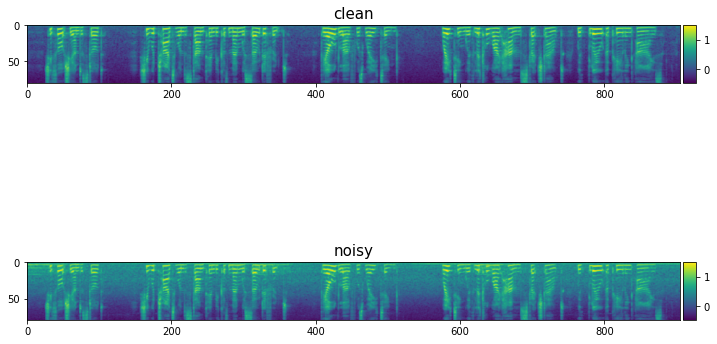

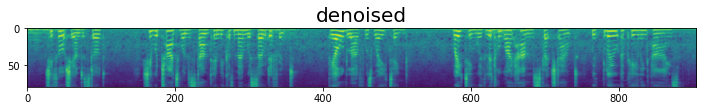

original mse: 0.03992
denoised mse: 0.030344255


In [23]:
rand_clean, rand_noisy = random_pair(train_clean, train_noisy)
denoised = restore_fun(model.process_image(norm_fun(rand_noisy)))
plt.imshow(denoised.T)
plt.title('denoised', fontsize=20)
plt.show()
print('original mse:', np.mean((rand_noisy - rand_clean)**2))
print('denoised mse:', np.mean((denoised - rand_clean)**2))

In [24]:
val_dataset = SpectrogramDataset(val_clean, val_noisy, norm_fun)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=collate_fn) 
print(f'val: {len(val_dataset)}')

best_model = load_best_model(best_model, cp_folder, best_max=False)
mse = validate(model, val_loader, criterion, jupyter=True, mode='regression')*scale**2
print(f'mse: {mse}')

val: 2000
loading epoch_9__mse_0.0101.pth



mse: 0.09299449622631073


## Альтернативная постановка задачи

Заметим, что регрессор, обученный чисто на mse, плохо обнуляет куски записи, на которых вообще нет звука. Можно попробовать предсказывать конкретно эти куски. Для этого сначала  проверим насколько это воообще может быть значимо с точки зрения mse.

In [43]:
def get_mask_by_disp(img, thresh=0.1):
    mask = np.var(img, axis=1) < thresh
    means = np.mean(img, axis=1)
    return mask, means

def apply_mask(img, mask, means):
    img = img.copy()
    img[mask, :] =  np.expand_dims(means[mask], 1) * np.ones((1, 80))
    return img

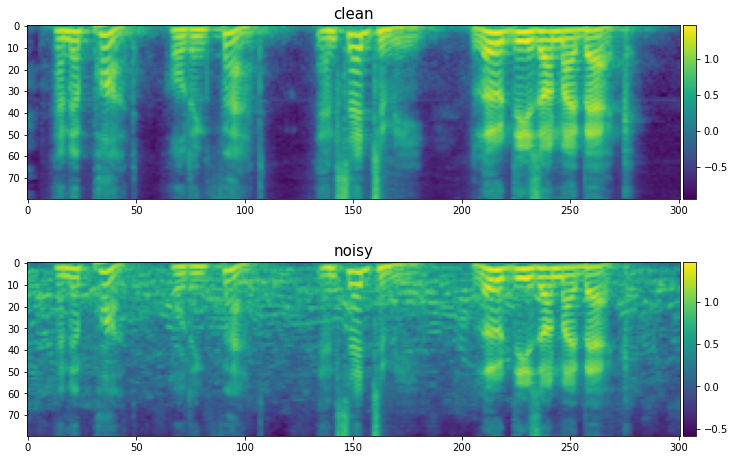

original mse: 0.2119
denoised mse: 0.07221685


In [49]:
rand_clean, rand_noisy = random_pair(train_clean, train_noisy)
mask, means = get_mask_by_disp(rand_clean.astype(float), .1)
denoised = apply_mask(rand_noisy, mask, means).astype(np.float32)
plt.imshow(denoised.T)
plt.title('denoised', fontsize=20)
plt.show()
print('original mse:', np.mean((rand_noisy - rand_clean)**2))
print('denoised mse:', np.mean((denoised - rand_clean)**2))

In [50]:
def data_mse_leak(clean, noisy, fun, fun_args={}):
    ret = []
    for key in tqdm(list(clean.keys())):
        for clean_elem, noisy_elem in zip(clean[key], noisy[key]):
            denoised = fun(noisy_elem, clean_elem, **fun_args)
            ret.append(np.mean((clean_elem - denoised)**2))
    return np.mean(ret)


def fun(noisy_elem, clean_elem, t=.1):
    mask, means = get_mask_by_disp(clean_elem, t)
    return apply_mask(noisy_elem, mask, means)
    


data_mse_leak(train_clean, train_noisy, fun)

0.05746

Достаточно многообещающе, даже без подбора параметров. Попробуем добавить это в регрессор. Но перед этим сформируем разметку для масок, для чего подберем правильный порог для дисперсии.

In [60]:
for t in np.arange(0.05, .15, .01):
    val = data_mse_leak(train_clean, train_noisy, fun, {'t': t})
    print(f'{t}: {val}')


0.05: 0.06610107421875



0.060000000000000005: 0.060272216796875



0.07: 0.0570068359375



0.08000000000000002: 0.05572509765625



0.09000000000000001: 0.055999755859375



0.1: 0.057464599609375



0.11000000000000001: 0.059844970703125



0.12000000000000001: 0.06292724609375



0.13: 0.06634521484375



0.14: 0.0699462890625


0.08

In [5]:
from models import SpectrogramDataset, BackgroundRegressor, collate_fn_bg, background_loss 
from training import validate, train
from utils import load_best_model, train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
%load_ext autoreload
%autoreload 2

/home/warden/miniconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/warden/miniconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/warden/miniconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/warden/miniconda3/lib/python3.7/site-packages/tensor

In [6]:
train_part_clean, train_part_noisy, test_part_clean, test_part_noisy = train_test_split(train_clean, train_noisy)

In [125]:
model = BackgroundRegressor(gradient_clip=50)
cp_folder = 'checkpoints/bg_regression_checkpoints'

train_dataset = SpectrogramDataset(train_part_clean, train_part_noisy)
test_dataset = SpectrogramDataset(test_part_clean, test_part_noisy)
print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1, collate_fn=collate_fn_bg) 
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=collate_fn_bg) 

criterion = background_loss 
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)


train: 9607, test: 2393


In [129]:
train(model, optimizer, criterion, train_loader, test_loader, n_epochs=30, n_verbose=30, jupyter=True, checkpoints=cp_folder, mode='bg_regression', bg_alpha=.1)

[0, 30] avg_omse: 0.2155635803937912, avg_acc: 78.07 avg_nll: 47.63 avg_mse: 0.08969324827194214 avg_loss: 0.137
[0, 60] avg_omse: 0.21654218435287476, avg_acc: 80.10 avg_nll: 45.50 avg_mse: 0.09180635958909988 avg_loss: 0.137
[0, 90] avg_omse: 0.20559090375900269, avg_acc: 80.29 avg_nll: 45.00 avg_mse: 0.09767743945121765 avg_loss: 0.143
[0, 120] avg_omse: 0.19611328840255737, avg_acc: 80.11 avg_nll: 45.27 avg_mse: 0.09629833698272705 avg_loss: 0.142
[0, 150] avg_omse: 0.19536547362804413, avg_acc: 80.87 avg_nll: 44.66 avg_mse: 0.07978182286024094 avg_loss: 0.124
[0, 180] avg_omse: 0.1839050054550171, avg_acc: 80.86 avg_nll: 44.62 avg_mse: 0.08780685812234879 avg_loss: 0.132
[0, 210] avg_omse: 0.20335008203983307, avg_acc: 81.19 avg_nll: 44.00 avg_mse: 0.08284884691238403 avg_loss: 0.127
[0, 240] avg_omse: 0.2188553810119629, avg_acc: 80.33 avg_nll: 44.85 avg_mse: 0.1009620949625969 avg_loss: 0.146
[0, 270] avg_omse: 0.2083372324705124, avg_acc: 80.41 avg_nll: 44.92 avg_mse: 0.0993745


epoch 0 train | omse: 0.2045966386795044, acc: 81.11, nll: 0.44991227984428406, mse: 0.09260080754756927, loss: 0.13759206245309888
epoch 0 test |  omse: 0.21600466966629028, acc: 81.11, nll: 0.4344293773174286, mse: 0.08044048398733139, loss: 0.5148699283599854
saving checkpoint to checkpoints/bg_regression_checkpoints/epoch_0__loss_0.5149.pth


[1, 30] avg_omse: 0.2263813614845276, avg_acc: 80.03 avg_nll: 45.25 avg_mse: 0.10416563600301743 avg_loss: 0.149
[1, 60] avg_omse: 0.20989829301834106, avg_acc: 80.29 avg_nll: 44.98 avg_mse: 0.09625446796417236 avg_loss: 0.141
[1, 90] avg_omse: 0.21592877805233002, avg_acc: 80.78 avg_nll: 44.43 avg_mse: 0.08930808305740356 avg_loss: 0.134
[1, 120] avg_omse: 0.1899520307779312, avg_acc: 81.24 avg_nll: 44.62 avg_mse: 0.08873637020587921 avg_loss: 0.133
[1, 150] avg_omse: 0.20029594004154205, avg_acc: 80.68 avg_nll: 44.29 avg_mse: 0.08050914853811264 avg_loss: 0.125
[1, 180] avg_omse: 0.2157595306634903, avg_acc: 80.67 avg_nll: 44.60 avg_mse: 0.10089011490345001 avg_loss: 0.145
[1, 210] avg_omse: 0.20428621768951416, avg_acc: 79.59 avg_nll: 45.54 avg_mse: 0.09534177929162979 avg_loss: 0.141
[1, 240] avg_omse: 0.19399380683898926, avg_acc: 81.39 avg_nll: 44.05 avg_mse: 0.08645886182785034 avg_loss: 0.131
[1, 270] avg_omse: 0.21170789003372192, avg_acc: 80.60 avg_nll: 44.42 avg_mse: 0.09965


epoch 1 train | omse: 0.20956185460090637, acc: 82.50, nll: 0.44656917452812195, mse: 0.09262032061815262, loss: 0.13727721928362038
epoch 1 test |  omse: 0.18239149451255798, acc: 82.50, nll: 0.4401378929615021, mse: 0.08313456922769547, loss: 0.5232723951339722
saving checkpoint to checkpoints/bg_regression_checkpoints/epoch_1__loss_0.5233.pth


[2, 30] avg_omse: 0.2033231407403946, avg_acc: 80.98 avg_nll: 44.47 avg_mse: 0.09511244297027588 avg_loss: 0.140
[2, 60] avg_omse: 0.21132227778434753, avg_acc: 80.65 avg_nll: 44.24 avg_mse: 0.08632206916809082 avg_loss: 0.131
[2, 90] avg_omse: 0.19513143599033356, avg_acc: 81.08 avg_nll: 43.57 avg_mse: 0.09532689303159714 avg_loss: 0.139
[2, 120] avg_omse: 0.21934671700000763, avg_acc: 80.30 avg_nll: 45.00 avg_mse: 0.09047441184520721 avg_loss: 0.135
[2, 150] avg_omse: 0.2041717916727066, avg_acc: 80.81 avg_nll: 43.81 avg_mse: 0.0801815539598465 avg_loss: 0.124
[2, 180] avg_omse: 0.21602581441402435, avg_acc: 80.90 avg_nll: 44.20 avg_mse: 0.08289580792188644 avg_loss: 0.127
[2, 210] avg_omse: 0.20997890830039978, avg_acc: 80.72 avg_nll: 44.76 avg_mse: 0.090497225522995 avg_loss: 0.135
[2, 240] avg_omse: 0.20669643580913544, avg_acc: 80.53 avg_nll: 45.35 avg_mse: 0.0820586308836937 avg_loss: 0.127
[2, 270] avg_omse: 0.2068248689174652, avg_acc: 80.60 avg_nll: 44.69 avg_mse: 0.112237222


epoch 2 train | omse: 0.2074171006679535, acc: 81.88, nll: 0.4441160559654236, mse: 0.09019015729427338, loss: 0.13460175237584351
epoch 2 test |  omse: 0.1831551343202591, acc: 81.88, nll: 0.43338918685913086, mse: 0.08164795488119125, loss: 0.5150373578071594
saving checkpoint to checkpoints/bg_regression_checkpoints/epoch_2__loss_0.5150.pth


[3, 30] avg_omse: 0.20450352132320404, avg_acc: 80.37 avg_nll: 45.20 avg_mse: 0.08255406469106674 avg_loss: 0.128
[3, 60] avg_omse: 0.2140904664993286, avg_acc: 80.30 avg_nll: 45.37 avg_mse: 0.08346755057573318 avg_loss: 0.129
[3, 90] avg_omse: 0.22005435824394226, avg_acc: 80.41 avg_nll: 44.42 avg_mse: 0.09706053137779236 avg_loss: 0.141
[3, 120] avg_omse: 0.221854567527771, avg_acc: 80.82 avg_nll: 44.67 avg_mse: 0.10428082942962646 avg_loss: 0.149
[3, 150] avg_omse: 0.22172608971595764, avg_acc: 80.06 avg_nll: 45.56 avg_mse: 0.10371094197034836 avg_loss: 0.149
[3, 180] avg_omse: 0.20041775703430176, avg_acc: 80.59 avg_nll: 44.35 avg_mse: 0.08773791790008545 avg_loss: 0.132
[3, 210] avg_omse: 0.18400783836841583, avg_acc: 81.27 avg_nll: 44.10 avg_mse: 0.0898849293589592 avg_loss: 0.134
[3, 240] avg_omse: 0.20879802107810974, avg_acc: 80.27 avg_nll: 45.12 avg_mse: 0.08483600616455078 avg_loss: 0.130
[3, 270] avg_omse: 0.21633699536323547, avg_acc: 81.07 avg_nll: 43.88 avg_mse: 0.096408


epoch 3 train | omse: 0.20813848078250885, acc: 79.65, nll: 0.44572022557258606, mse: 0.09038284420967102, loss: 0.134954884450301
epoch 3 test |  omse: 0.18762299418449402, acc: 79.65, nll: 0.4406898617744446, mse: 0.08419422060251236, loss: 0.524884045124054
saving checkpoint to checkpoints/bg_regression_checkpoints/epoch_3__loss_0.5249.pth


[4, 30] avg_omse: 0.20851971209049225, avg_acc: 80.70 avg_nll: 44.37 avg_mse: 0.09042377769947052 avg_loss: 0.135
[4, 60] avg_omse: 0.20897965133190155, avg_acc: 81.16 avg_nll: 43.88 avg_mse: 0.0914488360285759 avg_loss: 0.135
[4, 90] avg_omse: 0.18751132488250732, avg_acc: 80.65 avg_nll: 44.69 avg_mse: 0.07910443842411041 avg_loss: 0.124
[4, 120] avg_omse: 0.21216163039207458, avg_acc: 81.39 avg_nll: 43.10 avg_mse: 0.09542336314916611 avg_loss: 0.139
[4, 150] avg_omse: 0.19024673104286194, avg_acc: 81.43 avg_nll: 43.73 avg_mse: 0.0815136581659317 avg_loss: 0.125
[4, 180] avg_omse: 0.22422407567501068, avg_acc: 80.10 avg_nll: 45.25 avg_mse: 0.09648241102695465 avg_loss: 0.142
[4, 210] avg_omse: 0.19658774137496948, avg_acc: 79.88 avg_nll: 45.53 avg_mse: 0.10288549214601517 avg_loss: 0.148
[4, 240] avg_omse: 0.19873839616775513, avg_acc: 80.13 avg_nll: 45.42 avg_mse: 0.08732517063617706 avg_loss: 0.133
[4, 270] avg_omse: 0.20514801144599915, avg_acc: 80.27 avg_nll: 44.98 avg_mse: 0.0977


epoch 4 train | omse: 0.20669108629226685, acc: 78.23, nll: 0.4465967118740082, mse: 0.09124590456485748, loss: 0.1359055592768216
epoch 4 test |  omse: 0.18877093493938446, acc: 78.23, nll: 0.45041412115097046, mse: 0.08407361060380936, loss: 0.5344879031181335
saving checkpoint to checkpoints/bg_regression_checkpoints/epoch_4__loss_0.5345.pth


[5, 30] avg_omse: 0.18740758299827576, avg_acc: 80.38 avg_nll: 45.05 avg_mse: 0.08652103692293167 avg_loss: 0.132
[5, 60] avg_omse: 0.2079979032278061, avg_acc: 80.73 avg_nll: 44.31 avg_mse: 0.08475906401872635 avg_loss: 0.129
[5, 90] avg_omse: 0.20170745253562927, avg_acc: 81.02 avg_nll: 43.98 avg_mse: 0.10733351111412048 avg_loss: 0.151
[5, 120] avg_omse: 0.19291557371616364, avg_acc: 81.30 avg_nll: 43.92 avg_mse: 0.08867699652910233 avg_loss: 0.133
[5, 150] avg_omse: 0.22433070838451385, avg_acc: 80.29 avg_nll: 45.31 avg_mse: 0.08219287544488907 avg_loss: 0.128
[5, 180] avg_omse: 0.21182049810886383, avg_acc: 80.45 avg_nll: 44.26 avg_mse: 0.0928134098649025 avg_loss: 0.137
[5, 210] avg_omse: 0.20700660347938538, avg_acc: 80.46 avg_nll: 45.06 avg_mse: 0.08276315778493881 avg_loss: 0.128
[5, 240] avg_omse: 0.21474088728427887, avg_acc: 80.88 avg_nll: 44.04 avg_mse: 0.09169212728738785 avg_loss: 0.136
[5, 270] avg_omse: 0.19868320226669312, avg_acc: 81.14 avg_nll: 43.53 avg_mse: 0.0870


epoch 5 train | omse: 0.20484256744384766, acc: 82.00, nll: 0.4437740445137024, mse: 0.08898501098155975, loss: 0.1333624319578722
epoch 5 test |  omse: 0.1770346760749817, acc: 82.00, nll: 0.4327574372291565, mse: 0.08102227002382278, loss: 0.5137798190116882
saving checkpoint to checkpoints/bg_regression_checkpoints/epoch_5__loss_0.5138.pth


[6, 30] avg_omse: 0.2043381929397583, avg_acc: 80.96 avg_nll: 44.44 avg_mse: 0.08273742347955704 avg_loss: 0.127
[6, 60] avg_omse: 0.18646268546581268, avg_acc: 79.31 avg_nll: 46.36 avg_mse: 0.10218586027622223 avg_loss: 0.149
[6, 90] avg_omse: 0.20686055719852448, avg_acc: 80.65 avg_nll: 44.12 avg_mse: 0.09029629826545715 avg_loss: 0.134
[6, 120] avg_omse: 0.1983908861875534, avg_acc: 80.96 avg_nll: 44.00 avg_mse: 0.08581126481294632 avg_loss: 0.130
[6, 150] avg_omse: 0.21013228595256805, avg_acc: 80.72 avg_nll: 44.19 avg_mse: 0.08850149810314178 avg_loss: 0.133
[6, 180] avg_omse: 0.1961570829153061, avg_acc: 80.23 avg_nll: 44.92 avg_mse: 0.07664535939693451 avg_loss: 0.122
[6, 210] avg_omse: 0.2041979730129242, avg_acc: 81.11 avg_nll: 43.67 avg_mse: 0.09207730740308762 avg_loss: 0.136
[6, 240] avg_omse: 0.20048919320106506, avg_acc: 80.68 avg_nll: 44.97 avg_mse: 0.0961001068353653 avg_loss: 0.141
[6, 270] avg_omse: 0.1980157047510147, avg_acc: 80.91 avg_nll: 44.36 avg_mse: 0.09036400


epoch 6 train | omse: 0.1987890601158142, acc: 81.68, nll: 0.44461581110954285, mse: 0.0889434888958931, loss: 0.13340508002181387
epoch 6 test |  omse: 0.19121353328227997, acc: 81.68, nll: 0.4309205710887909, mse: 0.07864634692668915, loss: 0.5095669031143188
saving checkpoint to checkpoints/bg_regression_checkpoints/epoch_6__loss_0.5096.pth


[7, 30] avg_omse: 0.20393617451190948, avg_acc: 81.13 avg_nll: 44.47 avg_mse: 0.0832870602607727 avg_loss: 0.128
[7, 60] avg_omse: 0.19115687906742096, avg_acc: 80.79 avg_nll: 44.18 avg_mse: 0.08440478146076202 avg_loss: 0.129
[7, 90] avg_omse: 0.19289332628250122, avg_acc: 81.46 avg_nll: 43.52 avg_mse: 0.0900152251124382 avg_loss: 0.134
[7, 120] avg_omse: 0.1858825832605362, avg_acc: 80.19 avg_nll: 44.86 avg_mse: 0.0887688398361206 avg_loss: 0.134
[7, 150] avg_omse: 0.17978182435035706, avg_acc: 80.40 avg_nll: 45.10 avg_mse: 0.07936599105596542 avg_loss: 0.124
[7, 180] avg_omse: 0.18827033042907715, avg_acc: 80.90 avg_nll: 44.41 avg_mse: 0.08076231926679611 avg_loss: 0.125
[7, 210] avg_omse: 0.19577710330486298, avg_acc: 81.27 avg_nll: 43.46 avg_mse: 0.08777693659067154 avg_loss: 0.131
[7, 240] avg_omse: 0.2016359567642212, avg_acc: 80.38 avg_nll: 44.53 avg_mse: 0.10383827239274979 avg_loss: 0.148
[7, 270] avg_omse: 0.21130791306495667, avg_acc: 80.06 avg_nll: 45.17 avg_mse: 0.0878682


epoch 7 train | omse: 0.19446925818920135, acc: 81.85, nll: 0.4442152678966522, mse: 0.08650314807891846, loss: 0.13092471084919483
epoch 7 test |  omse: 0.18103589117527008, acc: 81.85, nll: 0.4313340485095978, mse: 0.07592204958200455, loss: 0.507256031036377
saving checkpoint to checkpoints/bg_regression_checkpoints/epoch_7__loss_0.5073.pth


[8, 30] avg_omse: 0.1916102021932602, avg_acc: 81.09 avg_nll: 43.51 avg_mse: 0.08169596642255783 avg_loss: 0.125
[8, 60] avg_omse: 0.19184958934783936, avg_acc: 81.16 avg_nll: 43.01 avg_mse: 0.08442565053701401 avg_loss: 0.127
[8, 90] avg_omse: 0.1928332895040512, avg_acc: 81.19 avg_nll: 43.60 avg_mse: 0.0913076102733612 avg_loss: 0.135
[8, 120] avg_omse: 0.18543973565101624, avg_acc: 80.40 avg_nll: 44.31 avg_mse: 0.07979346066713333 avg_loss: 0.124
[8, 150] avg_omse: 0.19112469255924225, avg_acc: 81.26 avg_nll: 44.14 avg_mse: 0.0913563072681427 avg_loss: 0.136
[8, 180] avg_omse: 0.18892426788806915, avg_acc: 80.57 avg_nll: 44.58 avg_mse: 0.09258908778429031 avg_loss: 0.137
[8, 210] avg_omse: 0.17594552040100098, avg_acc: 80.89 avg_nll: 44.33 avg_mse: 0.07325619459152222 avg_loss: 0.118
[8, 240] avg_omse: 0.18207336962223053, avg_acc: 80.31 avg_nll: 44.97 avg_mse: 0.09289517253637314 avg_loss: 0.138
[8, 270] avg_omse: 0.18416832387447357, avg_acc: 80.23 avg_nll: 45.58 avg_mse: 0.087222


epoch 8 train | omse: 0.18885309994220734, acc: 82.49, nll: 0.4419924020767212, mse: 0.08575782924890518, loss: 0.12995706429315168
epoch 8 test |  omse: 0.20526111125946045, acc: 82.49, nll: 0.4321017563343048, mse: 0.07758517563343048, loss: 0.5096869468688965
saving checkpoint to checkpoints/bg_regression_checkpoints/epoch_8__loss_0.5097.pth


[9, 30] avg_omse: 0.19247351586818695, avg_acc: 80.58 avg_nll: 44.58 avg_mse: 0.08281327784061432 avg_loss: 0.127
[9, 60] avg_omse: 0.20344950258731842, avg_acc: 81.11 avg_nll: 44.07 avg_mse: 0.08355841040611267 avg_loss: 0.128
[9, 90] avg_omse: 0.18316467106342316, avg_acc: 80.88 avg_nll: 43.93 avg_mse: 0.09043832868337631 avg_loss: 0.134
[9, 120] avg_omse: 0.18209029734134674, avg_acc: 80.97 avg_nll: 43.87 avg_mse: 0.07701079547405243 avg_loss: 0.121
[9, 150] avg_omse: 0.19198162853717804, avg_acc: 81.09 avg_nll: 44.32 avg_mse: 0.09381461888551712 avg_loss: 0.138
[9, 180] avg_omse: 0.17621901631355286, avg_acc: 81.25 avg_nll: 43.31 avg_mse: 0.08959583193063736 avg_loss: 0.133
[9, 210] avg_omse: 0.18751280009746552, avg_acc: 81.02 avg_nll: 44.14 avg_mse: 0.08788315951824188 avg_loss: 0.132
[9, 240] avg_omse: 0.2094886302947998, avg_acc: 81.11 avg_nll: 43.96 avg_mse: 0.08074011653661728 avg_loss: 0.125
[9, 270] avg_omse: 0.17558646202087402, avg_acc: 80.81 avg_nll: 44.05 avg_mse: 0.080


epoch 9 train | omse: 0.18854860961437225, acc: 82.15, nll: 0.4409988522529602, mse: 0.08459363132715225, loss: 0.12869346953705696
epoch 9 test |  omse: 0.18330754339694977, acc: 82.15, nll: 0.4299851059913635, mse: 0.07604721933603287, loss: 0.5060323476791382
saving checkpoint to checkpoints/bg_regression_checkpoints/epoch_9__loss_0.5060.pth


[10, 30] avg_omse: 0.17646196484565735, avg_acc: 81.24 avg_nll: 43.93 avg_mse: 0.08446313440799713 avg_loss: 0.128
[10, 60] avg_omse: 0.18645258247852325, avg_acc: 80.75 avg_nll: 44.41 avg_mse: 0.09359587728977203 avg_loss: 0.138
[10, 90] avg_omse: 0.1689177006483078, avg_acc: 81.02 avg_nll: 44.39 avg_mse: 0.08552024513483047 avg_loss: 0.130
[10, 120] avg_omse: 0.20625407993793488, avg_acc: 80.17 avg_nll: 45.48 avg_mse: 0.0878603607416153 avg_loss: 0.133
[10, 150] avg_omse: 0.2089061141014099, avg_acc: 80.90 avg_nll: 43.99 avg_mse: 0.08977559208869934 avg_loss: 0.134
[10, 180] avg_omse: 0.18539318442344666, avg_acc: 81.39 avg_nll: 43.00 avg_mse: 0.08715786039829254 avg_loss: 0.130
[10, 210] avg_omse: 0.1919199526309967, avg_acc: 80.35 avg_nll: 44.81 avg_mse: 0.08206679672002792 avg_loss: 0.127
[10, 240] avg_omse: 0.17290808260440826, avg_acc: 81.19 avg_nll: 43.93 avg_mse: 0.07186966389417648 avg_loss: 0.116
[10, 270] avg_omse: 0.17475134134292603, avg_acc: 81.05 avg_nll: 43.25 avg_mse:


epoch 10 train | omse: 0.18762804567813873, acc: 81.40, nll: 0.4406753480434418, mse: 0.08507415652275085, loss: 0.12914171030256044
epoch 10 test |  omse: 0.19023513793945312, acc: 81.40, nll: 0.4298182725906372, mse: 0.07669316977262497, loss: 0.506511390209198
saving checkpoint to checkpoints/bg_regression_checkpoints/epoch_10__loss_0.5065.pth


[11, 30] avg_omse: 0.19141720235347748, avg_acc: 80.80 avg_nll: 44.16 avg_mse: 0.0775785818696022 avg_loss: 0.122
[11, 60] avg_omse: 0.17818701267242432, avg_acc: 81.33 avg_nll: 43.28 avg_mse: 0.0824044942855835 avg_loss: 0.126
[11, 90] avg_omse: 0.19332434237003326, avg_acc: 81.23 avg_nll: 44.02 avg_mse: 0.08534614741802216 avg_loss: 0.129
[11, 120] avg_omse: 0.1768985390663147, avg_acc: 81.17 avg_nll: 43.86 avg_mse: 0.08746925741434097 avg_loss: 0.131
[11, 150] avg_omse: 0.18365253508090973, avg_acc: 81.11 avg_nll: 44.18 avg_mse: 0.09306726604700089 avg_loss: 0.137
[11, 180] avg_omse: 0.18030351400375366, avg_acc: 81.38 avg_nll: 43.30 avg_mse: 0.08276595175266266 avg_loss: 0.126
[11, 210] avg_omse: 0.20530427992343903, avg_acc: 80.26 avg_nll: 44.85 avg_mse: 0.08582431077957153 avg_loss: 0.131
[11, 240] avg_omse: 0.18430545926094055, avg_acc: 80.97 avg_nll: 44.35 avg_mse: 0.07692517340183258 avg_loss: 0.121
[11, 270] avg_omse: 0.19710634648799896, avg_acc: 80.33 avg_nll: 44.26 avg_mse


epoch 11 train | omse: 0.18807817995548248, acc: 81.23, nll: 0.4398641288280487, mse: 0.08442848175764084, loss: 0.12841487262534146
epoch 11 test |  omse: 0.14956839382648468, acc: 81.23, nll: 0.43075063824653625, mse: 0.07893331348896027, loss: 0.5096839666366577
saving checkpoint to checkpoints/bg_regression_checkpoints/epoch_11__loss_0.5097.pth


[12, 30] avg_omse: 0.18173371255397797, avg_acc: 81.30 avg_nll: 43.51 avg_mse: 0.08455051481723785 avg_loss: 0.128
[12, 60] avg_omse: 0.1831817775964737, avg_acc: 80.45 avg_nll: 44.18 avg_mse: 0.07689699530601501 avg_loss: 0.121
[12, 90] avg_omse: 0.19743716716766357, avg_acc: 80.24 avg_nll: 44.69 avg_mse: 0.08830070495605469 avg_loss: 0.133
[12, 120] avg_omse: 0.17921943962574005, avg_acc: 81.19 avg_nll: 43.51 avg_mse: 0.09244967252016068 avg_loss: 0.136
[12, 150] avg_omse: 0.18562427163124084, avg_acc: 81.11 avg_nll: 44.49 avg_mse: 0.09247643500566483 avg_loss: 0.137
[12, 180] avg_omse: 0.18293654918670654, avg_acc: 81.15 avg_nll: 43.53 avg_mse: 0.07536374777555466 avg_loss: 0.119
[12, 210] avg_omse: 0.17794516682624817, avg_acc: 81.53 avg_nll: 43.91 avg_mse: 0.07939652353525162 avg_loss: 0.123
[12, 240] avg_omse: 0.1832590103149414, avg_acc: 81.02 avg_nll: 43.50 avg_mse: 0.08599308133125305 avg_loss: 0.129
[12, 270] avg_omse: 0.19502581655979156, avg_acc: 80.92 avg_nll: 43.83 avg_ms


epoch 12 train | omse: 0.18564428389072418, acc: 81.25, nll: 0.4407394528388977, mse: 0.08501793444156647, loss: 0.1290919005474775
epoch 12 test |  omse: 0.1729610413312912, acc: 81.25, nll: 0.4334505796432495, mse: 0.07607725262641907, loss: 0.509527862071991
saving checkpoint to checkpoints/bg_regression_checkpoints/epoch_12__loss_0.5095.pth


[13, 30] avg_omse: 0.18317456543445587, avg_acc: 81.30 avg_nll: 43.98 avg_mse: 0.09437582641839981 avg_loss: 0.138
[13, 60] avg_omse: 0.18005086481571198, avg_acc: 80.97 avg_nll: 43.92 avg_mse: 0.08052472770214081 avg_loss: 0.124
[13, 90] avg_omse: 0.18067152798175812, avg_acc: 80.45 avg_nll: 44.67 avg_mse: 0.07767238467931747 avg_loss: 0.122
[13, 120] avg_omse: 0.19543509185314178, avg_acc: 80.79 avg_nll: 44.18 avg_mse: 0.07737180590629578 avg_loss: 0.122
[13, 150] avg_omse: 0.17896009981632233, avg_acc: 81.68 avg_nll: 42.73 avg_mse: 0.0775645449757576 avg_loss: 0.120
[13, 180] avg_omse: 0.19866099953651428, avg_acc: 81.11 avg_nll: 44.18 avg_mse: 0.0891675129532814 avg_loss: 0.133
[13, 210] avg_omse: 0.17286840081214905, avg_acc: 81.19 avg_nll: 43.46 avg_mse: 0.09152670204639435 avg_loss: 0.135
[13, 240] avg_omse: 0.19368471205234528, avg_acc: 80.98 avg_nll: 44.21 avg_mse: 0.0836431160569191 avg_loss: 0.128
[13, 270] avg_omse: 0.17432314157485962, avg_acc: 80.64 avg_nll: 44.49 avg_mse


epoch 13 train | omse: 0.18392163515090942, acc: 81.07, nll: 0.4401930868625641, mse: 0.08389128744602203, loss: 0.12791058916190137
epoch 13 test |  omse: 0.18002073466777802, acc: 81.07, nll: 0.43080776929855347, mse: 0.08029918372631073, loss: 0.5111070275306702
saving checkpoint to checkpoints/bg_regression_checkpoints/epoch_13__loss_0.5111.pth


[14, 30] avg_omse: 0.1903693825006485, avg_acc: 80.31 avg_nll: 44.53 avg_mse: 0.08783774077892303 avg_loss: 0.132
[14, 60] avg_omse: 0.18680275976657867, avg_acc: 81.25 avg_nll: 43.52 avg_mse: 0.08746608346700668 avg_loss: 0.131
[14, 90] avg_omse: 0.17145371437072754, avg_acc: 81.16 avg_nll: 43.62 avg_mse: 0.07575074583292007 avg_loss: 0.119
[14, 120] avg_omse: 0.17657023668289185, avg_acc: 81.41 avg_nll: 43.63 avg_mse: 0.07958590239286423 avg_loss: 0.123
[14, 150] avg_omse: 0.18006345629692078, avg_acc: 81.32 avg_nll: 43.57 avg_mse: 0.09083668887615204 avg_loss: 0.134
[14, 180] avg_omse: 0.19552843272686005, avg_acc: 81.11 avg_nll: 43.70 avg_mse: 0.0892968624830246 avg_loss: 0.133
[14, 210] avg_omse: 0.18637420237064362, avg_acc: 80.38 avg_nll: 44.52 avg_mse: 0.08211971819400787 avg_loss: 0.127
[14, 240] avg_omse: 0.1984204202890396, avg_acc: 81.13 avg_nll: 43.92 avg_mse: 0.09516754746437073 avg_loss: 0.139
[14, 270] avg_omse: 0.1880732923746109, avg_acc: 81.38 avg_nll: 44.05 avg_mse:


epoch 14 train | omse: 0.18495886027812958, acc: 82.25, nll: 0.43932920694351196, mse: 0.08463609963655472, loss: 0.12856900857829573
epoch 14 test |  omse: 0.1781505048274994, acc: 82.25, nll: 0.4317520260810852, mse: 0.075385682284832, loss: 0.5071375370025635
saving checkpoint to checkpoints/bg_regression_checkpoints/epoch_14__loss_0.5071.pth


[15, 30] avg_omse: 0.17462469637393951, avg_acc: 81.01 avg_nll: 43.92 avg_mse: 0.07828978449106216 avg_loss: 0.122
[15, 60] avg_omse: 0.1901799887418747, avg_acc: 81.04 avg_nll: 44.20 avg_mse: 0.08352996408939362 avg_loss: 0.128
[15, 90] avg_omse: 0.16796740889549255, avg_acc: 80.87 avg_nll: 44.05 avg_mse: 0.0726010873913765 avg_loss: 0.117
[15, 120] avg_omse: 0.18377624452114105, avg_acc: 81.04 avg_nll: 44.18 avg_mse: 0.0980696901679039 avg_loss: 0.142
[15, 150] avg_omse: 0.17918924987316132, avg_acc: 80.84 avg_nll: 44.44 avg_mse: 0.08496589958667755 avg_loss: 0.129
[15, 180] avg_omse: 0.18223156034946442, avg_acc: 81.37 avg_nll: 43.60 avg_mse: 0.08112214505672455 avg_loss: 0.125
[15, 210] avg_omse: 0.184447780251503, avg_acc: 80.28 avg_nll: 44.93 avg_mse: 0.08463754504919052 avg_loss: 0.130
[15, 240] avg_omse: 0.20746539533138275, avg_acc: 81.22 avg_nll: 43.56 avg_mse: 0.08631200343370438 avg_loss: 0.130
[15, 270] avg_omse: 0.1784941703081131, avg_acc: 81.53 avg_nll: 43.14 avg_mse: 0


epoch 15 train | omse: 0.18278761208057404, acc: 80.20, nll: 0.4394834339618683, mse: 0.08400019258260727, loss: 0.12794856113254827
epoch 15 test |  omse: 0.18219608068466187, acc: 80.20, nll: 0.4345085620880127, mse: 0.07658036798238754, loss: 0.5110890865325928
saving checkpoint to checkpoints/bg_regression_checkpoints/epoch_15__loss_0.5111.pth


[16, 30] avg_omse: 0.19081997871398926, avg_acc: 80.50 avg_nll: 44.27 avg_mse: 0.07523686438798904 avg_loss: 0.120
[16, 60] avg_omse: 0.17002785205841064, avg_acc: 81.34 avg_nll: 43.47 avg_mse: 0.07659976184368134 avg_loss: 0.120
[16, 90] avg_omse: 0.17722143232822418, avg_acc: 80.41 avg_nll: 45.09 avg_mse: 0.08617928624153137 avg_loss: 0.131
[16, 120] avg_omse: 0.20991843938827515, avg_acc: 81.05 avg_nll: 43.88 avg_mse: 0.0879107192158699 avg_loss: 0.132
[16, 150] avg_omse: 0.18277248740196228, avg_acc: 81.72 avg_nll: 43.17 avg_mse: 0.07679150998592377 avg_loss: 0.120
[16, 180] avg_omse: 0.19493824243545532, avg_acc: 80.69 avg_nll: 44.77 avg_mse: 0.07830141484737396 avg_loss: 0.123
[16, 210] avg_omse: 0.17715781927108765, avg_acc: 81.24 avg_nll: 43.21 avg_mse: 0.08668439835309982 avg_loss: 0.130
[16, 240] avg_omse: 0.17894667387008667, avg_acc: 81.44 avg_nll: 43.60 avg_mse: 0.08809714764356613 avg_loss: 0.132
[16, 270] avg_omse: 0.20032788813114166, avg_acc: 80.51 avg_nll: 44.45 avg_m


epoch 16 train | omse: 0.18786947429180145, acc: 82.41, nll: 0.43978986144065857, mse: 0.08478140085935593, loss: 0.1287603937708262
epoch 16 test |  omse: 0.18229694664478302, acc: 82.41, nll: 0.42908719182014465, mse: 0.07528338581323624, loss: 0.5043706893920898
saving checkpoint to checkpoints/bg_regression_checkpoints/epoch_16__loss_0.5044.pth


[17, 30] avg_omse: 0.17482778429985046, avg_acc: 81.56 avg_nll: 42.87 avg_mse: 0.0928618386387825 avg_loss: 0.136
[17, 60] avg_omse: 0.18596208095550537, avg_acc: 80.74 avg_nll: 44.02 avg_mse: 0.08291247487068176 avg_loss: 0.127
[17, 90] avg_omse: 0.1992519646883011, avg_acc: 80.96 avg_nll: 44.05 avg_mse: 0.08447127044200897 avg_loss: 0.129
[17, 120] avg_omse: 0.18623104691505432, avg_acc: 80.79 avg_nll: 43.87 avg_mse: 0.07996570318937302 avg_loss: 0.124
[17, 150] avg_omse: 0.18828807771205902, avg_acc: 80.88 avg_nll: 44.57 avg_mse: 0.0912959948182106 avg_loss: 0.136
[17, 180] avg_omse: 0.1960058957338333, avg_acc: 81.01 avg_nll: 44.11 avg_mse: 0.08266593515872955 avg_loss: 0.127
[17, 210] avg_omse: 0.18036723136901855, avg_acc: 81.01 avg_nll: 43.87 avg_mse: 0.07978901267051697 avg_loss: 0.124
[17, 240] avg_omse: 0.1661364734172821, avg_acc: 81.94 avg_nll: 42.76 avg_mse: 0.07503348588943481 avg_loss: 0.118
[17, 270] avg_omse: 0.18678642809391022, avg_acc: 80.43 avg_nll: 45.12 avg_mse: 


epoch 17 train | omse: 0.18606029450893402, acc: 82.50, nll: 0.4396626949310303, mse: 0.08411514759063721, loss: 0.12808144728705734
epoch 17 test |  omse: 0.1484643518924713, acc: 82.50, nll: 0.43052852153778076, mse: 0.07591811567544937, loss: 0.5064466595649719
saving checkpoint to checkpoints/bg_regression_checkpoints/epoch_17__loss_0.5064.pth


[18, 30] avg_omse: 0.18454788625240326, avg_acc: 80.52 avg_nll: 44.72 avg_mse: 0.08163881301879883 avg_loss: 0.126
[18, 60] avg_omse: 0.1779230684041977, avg_acc: 81.44 avg_nll: 43.37 avg_mse: 0.079901322722435 avg_loss: 0.123
[18, 90] avg_omse: 0.1901889145374298, avg_acc: 80.78 avg_nll: 44.18 avg_mse: 0.07676980644464493 avg_loss: 0.121
[18, 120] avg_omse: 0.20535072684288025, avg_acc: 80.29 avg_nll: 45.12 avg_mse: 0.0895259752869606 avg_loss: 0.135
[18, 150] avg_omse: 0.2011190801858902, avg_acc: 80.55 avg_nll: 44.36 avg_mse: 0.10802127420902252 avg_loss: 0.152
[18, 180] avg_omse: 0.191659614443779, avg_acc: 80.32 avg_nll: 44.77 avg_mse: 0.08288288116455078 avg_loss: 0.128
[18, 210] avg_omse: 0.17959406971931458, avg_acc: 81.50 avg_nll: 43.05 avg_mse: 0.07638432085514069 avg_loss: 0.119
[18, 240] avg_omse: 0.16520710289478302, avg_acc: 81.31 avg_nll: 43.22 avg_mse: 0.08325598388910294 avg_loss: 0.126
[18, 270] avg_omse: 0.15707983076572418, avg_acc: 81.23 avg_nll: 43.76 avg_mse: 0.0


epoch 18 train | omse: 0.18533095717430115, acc: 82.13, nll: 0.44121959805488586, mse: 0.08437444269657135, loss: 0.1284964076704361
epoch 18 test |  omse: 0.20033052563667297, acc: 82.13, nll: 0.42995452880859375, mse: 0.07645965367555618, loss: 0.5064142346382141
saving checkpoint to checkpoints/bg_regression_checkpoints/epoch_18__loss_0.5064.pth


[19, 30] avg_omse: 0.18697290122509003, avg_acc: 80.22 avg_nll: 44.52 avg_mse: 0.09528275579214096 avg_loss: 0.140
[19, 60] avg_omse: 0.1842997968196869, avg_acc: 81.35 avg_nll: 43.57 avg_mse: 0.08466436713933945 avg_loss: 0.128
[19, 90] avg_omse: 0.1857037991285324, avg_acc: 80.61 avg_nll: 44.80 avg_mse: 0.0744585245847702 avg_loss: 0.119
[19, 120] avg_omse: 0.1857181042432785, avg_acc: 80.79 avg_nll: 44.48 avg_mse: 0.09534890949726105 avg_loss: 0.140
[19, 150] avg_omse: 0.18821728229522705, avg_acc: 80.39 avg_nll: 44.59 avg_mse: 0.08463270217180252 avg_loss: 0.129
[19, 180] avg_omse: 0.1898306906223297, avg_acc: 81.11 avg_nll: 43.71 avg_mse: 0.07393019646406174 avg_loss: 0.118
[19, 210] avg_omse: 0.1844533383846283, avg_acc: 81.38 avg_nll: 43.82 avg_mse: 0.08625924587249756 avg_loss: 0.130
[19, 240] avg_omse: 0.20137804746627808, avg_acc: 81.28 avg_nll: 43.23 avg_mse: 0.08293125778436661 avg_loss: 0.126
[19, 270] avg_omse: 0.17439432442188263, avg_acc: 81.37 avg_nll: 43.65 avg_mse: 0


epoch 19 train | omse: 0.18497052788734436, acc: 81.42, nll: 0.439594030380249, mse: 0.08513486385345459, loss: 0.12909425797553553
epoch 19 test |  omse: 0.1652083396911621, acc: 81.42, nll: 0.42908382415771484, mse: 0.07151570916175842, loss: 0.5005993247032166
saving checkpoint to checkpoints/bg_regression_checkpoints/epoch_19__loss_0.5006.pth


[20, 30] avg_omse: 0.1979151964187622, avg_acc: 80.86 avg_nll: 44.15 avg_mse: 0.08780685067176819 avg_loss: 0.132
[20, 60] avg_omse: 0.20075395703315735, avg_acc: 81.33 avg_nll: 43.39 avg_mse: 0.10673099756240845 avg_loss: 0.150
[20, 90] avg_omse: 0.19734248518943787, avg_acc: 80.16 avg_nll: 44.67 avg_mse: 0.0765918716788292 avg_loss: 0.121
[20, 120] avg_omse: 0.1919785737991333, avg_acc: 80.88 avg_nll: 44.15 avg_mse: 0.08006227761507034 avg_loss: 0.124
[20, 150] avg_omse: 0.17563234269618988, avg_acc: 81.12 avg_nll: 44.28 avg_mse: 0.10011030733585358 avg_loss: 0.144
[20, 180] avg_omse: 0.17815157771110535, avg_acc: 80.94 avg_nll: 43.68 avg_mse: 0.07791279256343842 avg_loss: 0.122
[20, 210] avg_omse: 0.17566277086734772, avg_acc: 81.11 avg_nll: 44.30 avg_mse: 0.08056579530239105 avg_loss: 0.125
[20, 240] avg_omse: 0.17538419365882874, avg_acc: 81.17 avg_nll: 43.41 avg_mse: 0.07371259480714798 avg_loss: 0.117
[20, 270] avg_omse: 0.17493848502635956, avg_acc: 80.97 avg_nll: 44.25 avg_mse


epoch 20 train | omse: 0.18457846343517303, acc: 81.25, nll: 0.44006311893463135, mse: 0.08511848002672195, loss: 0.1291248213710183
epoch 20 test |  omse: 0.169561967253685, acc: 81.25, nll: 0.4301494359970093, mse: 0.07722079008817673, loss: 0.5073702931404114
saving checkpoint to checkpoints/bg_regression_checkpoints/epoch_20__loss_0.5074.pth


[21, 30] avg_omse: 0.17196549475193024, avg_acc: 81.68 avg_nll: 43.55 avg_mse: 0.0852699875831604 avg_loss: 0.129
[21, 60] avg_omse: 0.1898670494556427, avg_acc: 80.61 avg_nll: 44.06 avg_mse: 0.07811997085809708 avg_loss: 0.122
[21, 90] avg_omse: 0.20591679215431213, avg_acc: 80.05 avg_nll: 45.59 avg_mse: 0.08632069081068039 avg_loss: 0.132
[21, 120] avg_omse: 0.19076667726039886, avg_acc: 80.27 avg_nll: 44.42 avg_mse: 0.0845612958073616 avg_loss: 0.129
[21, 150] avg_omse: 0.18030864000320435, avg_acc: 81.34 avg_nll: 43.64 avg_mse: 0.07972390949726105 avg_loss: 0.123
[21, 180] avg_omse: 0.17340633273124695, avg_acc: 81.36 avg_nll: 43.27 avg_mse: 0.09753241389989853 avg_loss: 0.141
[21, 210] avg_omse: 0.19234584271907806, avg_acc: 81.31 avg_nll: 43.84 avg_mse: 0.08107177913188934 avg_loss: 0.125
[21, 240] avg_omse: 0.18371909856796265, avg_acc: 80.95 avg_nll: 44.27 avg_mse: 0.0753505527973175 avg_loss: 0.120
[21, 270] avg_omse: 0.18564796447753906, avg_acc: 80.70 avg_nll: 44.51 avg_mse:


epoch 21 train | omse: 0.18513235449790955, acc: 82.15, nll: 0.4393114745616913, mse: 0.08446674048900604, loss: 0.12839789673735533
epoch 21 test |  omse: 0.14897026121616364, acc: 82.15, nll: 0.4287913143634796, mse: 0.07468651980161667, loss: 0.5034778714179993
saving checkpoint to checkpoints/bg_regression_checkpoints/epoch_21__loss_0.5035.pth


[22, 30] avg_omse: 0.17104679346084595, avg_acc: 80.96 avg_nll: 44.05 avg_mse: 0.08128423988819122 avg_loss: 0.125
[22, 60] avg_omse: 0.17187444865703583, avg_acc: 80.58 avg_nll: 44.40 avg_mse: 0.0951438769698143 avg_loss: 0.140
[22, 90] avg_omse: 0.17494572699069977, avg_acc: 81.17 avg_nll: 43.33 avg_mse: 0.0741938054561615 avg_loss: 0.118
[22, 120] avg_omse: 0.18945154547691345, avg_acc: 81.22 avg_nll: 43.46 avg_mse: 0.0840660110116005 avg_loss: 0.128
[22, 150] avg_omse: 0.1925860196352005, avg_acc: 80.97 avg_nll: 44.60 avg_mse: 0.09122219681739807 avg_loss: 0.136
[22, 180] avg_omse: 0.18732964992523193, avg_acc: 80.91 avg_nll: 43.78 avg_mse: 0.0860736146569252 avg_loss: 0.130
[22, 210] avg_omse: 0.18576721847057343, avg_acc: 81.59 avg_nll: 43.31 avg_mse: 0.08194451779127121 avg_loss: 0.125
[22, 240] avg_omse: 0.20275022089481354, avg_acc: 80.98 avg_nll: 44.20 avg_mse: 0.09108420461416245 avg_loss: 0.135
[22, 270] avg_omse: 0.1943761557340622, avg_acc: 81.22 avg_nll: 44.08 avg_mse: 0


epoch 22 train | omse: 0.18503588438034058, acc: 81.56, nll: 0.4386809468269348, mse: 0.08473431318998337, loss: 0.12860244138791316
epoch 22 test |  omse: 0.1600172519683838, acc: 81.56, nll: 0.4289340376853943, mse: 0.07675063610076904, loss: 0.5056846737861633
saving checkpoint to checkpoints/bg_regression_checkpoints/epoch_22__loss_0.5057.pth


[23, 30] avg_omse: 0.1817077100276947, avg_acc: 81.26 avg_nll: 43.33 avg_mse: 0.07686778903007507 avg_loss: 0.120
[23, 60] avg_omse: 0.17607593536376953, avg_acc: 81.38 avg_nll: 43.25 avg_mse: 0.0834687352180481 avg_loss: 0.127
[23, 90] avg_omse: 0.1925985962152481, avg_acc: 80.51 avg_nll: 44.22 avg_mse: 0.0834241434931755 avg_loss: 0.128
[23, 120] avg_omse: 0.16813500225543976, avg_acc: 81.14 avg_nll: 44.07 avg_mse: 0.08045459538698196 avg_loss: 0.125
[23, 150] avg_omse: 0.19888721406459808, avg_acc: 80.73 avg_nll: 44.35 avg_mse: 0.08248954266309738 avg_loss: 0.127
[23, 180] avg_omse: 0.17847491800785065, avg_acc: 80.27 avg_nll: 45.30 avg_mse: 0.08320409059524536 avg_loss: 0.129
[23, 210] avg_omse: 0.18792934715747833, avg_acc: 81.17 avg_nll: 43.77 avg_mse: 0.08797090500593185 avg_loss: 0.132
[23, 240] avg_omse: 0.18146969377994537, avg_acc: 81.37 avg_nll: 42.90 avg_mse: 0.08740075677633286 avg_loss: 0.130
[23, 270] avg_omse: 0.18499556183815002, avg_acc: 81.12 avg_nll: 43.83 avg_mse:


epoch 23 train | omse: 0.1837850958108902, acc: 81.63, nll: 0.4400516152381897, mse: 0.08390981703996658, loss: 0.12791497874200541
epoch 23 test |  omse: 0.17104589939117432, acc: 81.63, nll: 0.4318508505821228, mse: 0.07764646410942078, loss: 0.5094972848892212
saving checkpoint to checkpoints/bg_regression_checkpoints/epoch_23__loss_0.5095.pth


[24, 30] avg_omse: 0.18516241014003754, avg_acc: 80.50 avg_nll: 44.54 avg_mse: 0.0890059545636177 avg_loss: 0.134
[24, 60] avg_omse: 0.1907871812582016, avg_acc: 81.01 avg_nll: 43.98 avg_mse: 0.07941786199808121 avg_loss: 0.123
[24, 90] avg_omse: 0.18880760669708252, avg_acc: 80.80 avg_nll: 44.09 avg_mse: 0.0765954777598381 avg_loss: 0.121
[24, 120] avg_omse: 0.18341316282749176, avg_acc: 81.23 avg_nll: 43.60 avg_mse: 0.0914313867688179 avg_loss: 0.135
[24, 150] avg_omse: 0.18309371173381805, avg_acc: 81.34 avg_nll: 43.55 avg_mse: 0.07783878594636917 avg_loss: 0.121
[24, 180] avg_omse: 0.1791490912437439, avg_acc: 80.98 avg_nll: 44.06 avg_mse: 0.07764444500207901 avg_loss: 0.122
[24, 210] avg_omse: 0.18053752183914185, avg_acc: 81.26 avg_nll: 43.53 avg_mse: 0.09073615819215775 avg_loss: 0.134
[24, 240] avg_omse: 0.18943524360656738, avg_acc: 81.46 avg_nll: 43.99 avg_mse: 0.09267998486757278 avg_loss: 0.137
[24, 270] avg_omse: 0.19172579050064087, avg_acc: 80.18 avg_nll: 44.82 avg_mse: 


epoch 24 train | omse: 0.18458032608032227, acc: 81.93, nll: 0.43963485956192017, mse: 0.08515471965074539, loss: 0.12911817874524284
epoch 24 test |  omse: 0.18039654195308685, acc: 81.93, nll: 0.4275229871273041, mse: 0.07957778126001358, loss: 0.5071007013320923
saving checkpoint to checkpoints/bg_regression_checkpoints/epoch_24__loss_0.5071.pth


[25, 30] avg_omse: 0.1930110603570938, avg_acc: 81.57 avg_nll: 43.41 avg_mse: 0.08862736076116562 avg_loss: 0.132
[25, 60] avg_omse: 0.21054771542549133, avg_acc: 80.21 avg_nll: 44.99 avg_mse: 0.08957463502883911 avg_loss: 0.135
[25, 90] avg_omse: 0.17261260747909546, avg_acc: 81.06 avg_nll: 43.55 avg_mse: 0.09069561213254929 avg_loss: 0.134
[25, 120] avg_omse: 0.17144133150577545, avg_acc: 81.09 avg_nll: 44.20 avg_mse: 0.07931400090456009 avg_loss: 0.124
[25, 150] avg_omse: 0.19170740246772766, avg_acc: 81.25 avg_nll: 43.74 avg_mse: 0.08571282029151917 avg_loss: 0.129
[25, 180] avg_omse: 0.19019101560115814, avg_acc: 80.83 avg_nll: 43.68 avg_mse: 0.08328316360712051 avg_loss: 0.127
[25, 210] avg_omse: 0.17468008399009705, avg_acc: 80.95 avg_nll: 44.22 avg_mse: 0.08654449135065079 avg_loss: 0.131
[25, 240] avg_omse: 0.18201713263988495, avg_acc: 81.65 avg_nll: 43.09 avg_mse: 0.07332945615053177 avg_loss: 0.116
[25, 270] avg_omse: 0.19264233112335205, avg_acc: 81.32 avg_nll: 43.82 avg_m


epoch 25 train | omse: 0.18639995157718658, acc: 82.58, nll: 0.43894997239112854, mse: 0.08414866775274277, loss: 0.1280437285371397
epoch 25 test |  omse: 0.16583146154880524, acc: 82.58, nll: 0.43097051978111267, mse: 0.07514286786317825, loss: 0.5061134696006775
saving checkpoint to checkpoints/bg_regression_checkpoints/epoch_25__loss_0.5061.pth


[26, 30] avg_omse: 0.17672011256217957, avg_acc: 81.48 avg_nll: 43.35 avg_mse: 0.0812971219420433 avg_loss: 0.125
[26, 60] avg_omse: 0.19752807915210724, avg_acc: 81.23 avg_nll: 43.85 avg_mse: 0.09312787652015686 avg_loss: 0.137
[26, 90] avg_omse: 0.17322741448879242, avg_acc: 80.95 avg_nll: 43.76 avg_mse: 0.07653041183948517 avg_loss: 0.120
[26, 120] avg_omse: 0.17103375494480133, avg_acc: 81.14 avg_nll: 44.15 avg_mse: 0.09325647354125977 avg_loss: 0.137
[26, 150] avg_omse: 0.18380612134933472, avg_acc: 80.52 avg_nll: 44.66 avg_mse: 0.07743971049785614 avg_loss: 0.122
[26, 180] avg_omse: 0.1922214776277542, avg_acc: 80.59 avg_nll: 43.95 avg_mse: 0.08362402766942978 avg_loss: 0.128
[26, 210] avg_omse: 0.18534734845161438, avg_acc: 81.17 avg_nll: 44.04 avg_mse: 0.0827699676156044 avg_loss: 0.127
[26, 240] avg_omse: 0.1809597760438919, avg_acc: 81.52 avg_nll: 43.34 avg_mse: 0.08383771032094955 avg_loss: 0.127
[26, 270] avg_omse: 0.17878790199756622, avg_acc: 80.82 avg_nll: 44.08 avg_mse:


epoch 26 train | omse: 0.18384063243865967, acc: 81.96, nll: 0.4393385946750641, mse: 0.08379776775836945, loss: 0.12773163512695668
epoch 26 test |  omse: 0.17748837172985077, acc: 81.96, nll: 0.429095983505249, mse: 0.07029363512992859, loss: 0.49938976764678955
saving checkpoint to checkpoints/bg_regression_checkpoints/epoch_26__loss_0.4994.pth


[27, 30] avg_omse: 0.17492303252220154, avg_acc: 81.29 avg_nll: 44.03 avg_mse: 0.08041500300168991 avg_loss: 0.124
[27, 60] avg_omse: 0.18983188271522522, avg_acc: 81.16 avg_nll: 44.20 avg_mse: 0.08380647748708725 avg_loss: 0.128
[27, 90] avg_omse: 0.19004788994789124, avg_acc: 80.57 avg_nll: 44.33 avg_mse: 0.08138300478458405 avg_loss: 0.126
[27, 120] avg_omse: 0.18475499749183655, avg_acc: 81.31 avg_nll: 43.96 avg_mse: 0.08801329880952835 avg_loss: 0.132
[27, 150] avg_omse: 0.17615962028503418, avg_acc: 81.09 avg_nll: 43.73 avg_mse: 0.08236579596996307 avg_loss: 0.126
[27, 180] avg_omse: 0.21256056427955627, avg_acc: 80.95 avg_nll: 43.81 avg_mse: 0.08727511018514633 avg_loss: 0.131
[27, 210] avg_omse: 0.19520322978496552, avg_acc: 81.06 avg_nll: 44.10 avg_mse: 0.07942178100347519 avg_loss: 0.124
[27, 240] avg_omse: 0.18636620044708252, avg_acc: 80.91 avg_nll: 43.83 avg_mse: 0.08119494467973709 avg_loss: 0.125
[27, 270] avg_omse: 0.17629176378250122, avg_acc: 81.02 avg_nll: 43.21 avg_


epoch 27 train | omse: 0.1857302486896515, acc: 81.68, nll: 0.4387233257293701, mse: 0.08375626057386398, loss: 0.1276286083746986
epoch 27 test |  omse: 0.16614457964897156, acc: 81.68, nll: 0.4289219379425049, mse: 0.07986817508935928, loss: 0.5087900757789612
saving checkpoint to checkpoints/bg_regression_checkpoints/epoch_27__loss_0.5088.pth


[28, 30] avg_omse: 0.17489004135131836, avg_acc: 81.41 avg_nll: 43.26 avg_mse: 0.0805722326040268 avg_loss: 0.124
[28, 60] avg_omse: 0.19264256954193115, avg_acc: 81.34 avg_nll: 43.14 avg_mse: 0.0923004224896431 avg_loss: 0.135
[28, 90] avg_omse: 0.1719987690448761, avg_acc: 81.09 avg_nll: 43.77 avg_mse: 0.07031701505184174 avg_loss: 0.114
[28, 120] avg_omse: 0.1881946623325348, avg_acc: 81.22 avg_nll: 43.59 avg_mse: 0.09521671384572983 avg_loss: 0.139
[28, 150] avg_omse: 0.19207602739334106, avg_acc: 80.91 avg_nll: 44.40 avg_mse: 0.08037260919809341 avg_loss: 0.125
[28, 180] avg_omse: 0.19357872009277344, avg_acc: 80.77 avg_nll: 44.34 avg_mse: 0.09264742583036423 avg_loss: 0.137
[28, 210] avg_omse: 0.1727934032678604, avg_acc: 80.96 avg_nll: 43.95 avg_mse: 0.08526095747947693 avg_loss: 0.129
[28, 240] avg_omse: 0.17876893281936646, avg_acc: 80.56 avg_nll: 44.64 avg_mse: 0.07818540930747986 avg_loss: 0.123
[28, 270] avg_omse: 0.19496113061904907, avg_acc: 81.56 avg_nll: 43.39 avg_mse: 


epoch 28 train | omse: 0.18330319225788116, acc: 82.52, nll: 0.4382881224155426, mse: 0.08491158485412598, loss: 0.12874039834321932
epoch 28 test |  omse: 0.160602405667305, acc: 82.52, nll: 0.4285368323326111, mse: 0.07430287450551987, loss: 0.5028398036956787
saving checkpoint to checkpoints/bg_regression_checkpoints/epoch_28__loss_0.5028.pth


[29, 30] avg_omse: 0.17652054131031036, avg_acc: 81.68 avg_nll: 42.64 avg_mse: 0.08079696446657181 avg_loss: 0.123
[29, 60] avg_omse: 0.2006097137928009, avg_acc: 81.58 avg_nll: 43.19 avg_mse: 0.09494514763355255 avg_loss: 0.138
[29, 90] avg_omse: 0.19624409079551697, avg_acc: 81.25 avg_nll: 43.47 avg_mse: 0.08672720938920975 avg_loss: 0.130
[29, 120] avg_omse: 0.19172103703022003, avg_acc: 80.96 avg_nll: 44.00 avg_mse: 0.07790107280015945 avg_loss: 0.122
[29, 150] avg_omse: 0.17279578745365143, avg_acc: 81.04 avg_nll: 44.34 avg_mse: 0.08543099462985992 avg_loss: 0.130
[29, 180] avg_omse: 0.159356489777565, avg_acc: 80.79 avg_nll: 44.94 avg_mse: 0.07806868106126785 avg_loss: 0.123
[29, 210] avg_omse: 0.1759711652994156, avg_acc: 81.03 avg_nll: 43.96 avg_mse: 0.08205587416887283 avg_loss: 0.126
[29, 240] avg_omse: 0.1861913949251175, avg_acc: 80.73 avg_nll: 44.02 avg_mse: 0.08475330471992493 avg_loss: 0.129
[29, 270] avg_omse: 0.19165177643299103, avg_acc: 81.14 avg_nll: 43.95 avg_mse: 


epoch 29 train | omse: 0.18431195616722107, acc: 79.48, nll: 0.4386841058731079, mse: 0.08315859735012054, loss: 0.12702699560065603
epoch 29 test |  omse: 0.17486542463302612, acc: 79.48, nll: 0.4384763240814209, mse: 0.07728154212236404, loss: 0.5157579779624939
saving checkpoint to checkpoints/bg_regression_checkpoints/epoch_29__loss_0.5158.pth


Не взлетело. Мне кажется, виновата низкая accuracy, из-за которой среднее значение вставляется в столбцы с большой дисперсией.